Praktikum NLP:

ToDo:
- Load dataset √

- Dependency Parsing √

- Extracting aspects (phrases/sentiment-words) √

    - Summarize aspects for each hotel √

    - Calculate sentiment scores for each aspect (TextBlob, VADER, etc...) √

- Analyse 5 most common aspects √

- Dump into graphs for the presentation √

In [296]:
#Imports and downloads

import pandas as pd
import re
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
import string
from collections import Counter
from textblob import TextBlob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pathlib
import numpy as np



path = pathlib.Path().resolve()

#nltk.download('wordnet')
#nltk.download('omw-1.4')

#!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")


# load data from previous session here if you dont want to run the entire extraction process 
''''
with open('../output/hotelFinalResults') as file:
    data = pd.read_json(file)
'''

    

"'\nwith open('../output/hotelFinalResults') as file:\n    data = pd.read_json(file)\n"

In [297]:
## Clean data

# Delete redundant and empty reviews

def preprocessing_reviews(df):
    df.drop(df[ df['Negative_Review'] == 'No Negative'].index)
    df.drop(df[ df['Positive_Review'] == 'No Positive'].index)
    df.drop_duplicates(keep=False)

# Split into sentences and add dots to positive reviews and negative reviews
    for text in df['Positive_Review']:
        parts_of_review = re.findall('[A-Z][^A-Z]*', text)
        for index, sentence in enumerate(parts_of_review):
            if "I " or "i " in sentence:
                parts_of_review[index : index +1] = [''.join(parts_of_review[index : index + 1])]
            parts_of_review[index] = sentence.strip() + "."
        complete_review = ' '.join(parts_of_review)

        # correct 'n t'|'nt'|'n t' to ' not'
        complete_review = re.sub(r'n\s+t |n\'t ', ' not',complete_review)
        df['Positive_Review'] = df['Positive_Review'].replace([text], complete_review)

    for text in df['Negative_Review']:
        parts_of_review = re.findall('[A-Z][^A-Z]*', text)
        for index, sentence in enumerate(parts_of_review):
            if "I " or "i " in sentence:
                parts_of_review[index : index +1] = [''.join(parts_of_review[index : index + 1])]
            parts_of_review[index] = sentence.strip() + "."
        complete_review = ' '.join(parts_of_review)

        # correct 'n t'|'nt'|'n t' to ' not'
        complete_review = re.sub(r'n\s+t |n\'t ', ' not',complete_review)
        #        complete_review = re.sub(r'n\s+t|n\'t|nt ', ' not',complete_review)
        df['Negative_Review'] = df['Negative_Review'].replace([text], complete_review)
    return df

#df = preprocessing_reviews(df)
#pd.set_option("display.max_colwidth", None) # -1?

In [298]:
# The main extraction function. Uses 6 rules.
# Rule 0 is self written. 1,3,4,6,7 are taken from https://github.com/ishikaarora/Aspect-Sentiment-Analysis-on-Amazon-Reviews
def extractAspects(listOfReviews, posFlag):
    # the return value
    aspects = []

    # for intermediate results
    rule0_pairs = []
    rule1_pairs = []
    rule3_pairs = []
    rule4_pairs = []
    rule6_pairs = []
    rule7_pairs = []

    # to id the aspects, used for removal of duplicates later on
    counter = 0

    # main extraction loop. Takes all the colums from the csv as variables, so if we want we could add any of them to the extracted data. For now, they are just placeholders
    for Hotel_Address, Additional_Number_of_Scoring, Review_Date, Average_Score, Hotel_Name,  Reviewer_Nationality, Negative_Review, Review_Total_Negative_Word_Counts, Total_Number_of_Reviews, Positive_Review, Review_Total_Positive_Word_Counts,  Total_Number_of_Reviews_Reviewer_Has_Given, Reviewer_Score, Tags, days_since_review, lat, lng in listOfReviews.values:

        # pipe the reviews, depending on the flag passed to the function only consider the prelabled positive or negative ones
        if(posFlag): doc = nlp(Positive_Review)
        else: doc = nlp(Negative_Review)
        

        ## MY (0) RULE OF DEPENDANCY PARSE -
        ## This is the original rule that was shown in our first presentation
        descriptors = '999999'
        aspect = '999999'

        for token in doc:
            # get all the nouns as aspects
            if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
                aspect = token.text
            # and the adjectives as descriptions...
            if token.pos_ == 'ADJ':
                prepend = ''
                negation = False 
                
                # catch negations as done in other rules 
                A_children = token.head.children
                for childa in A_children:
                    if(childa.dep_ == "det" and childa.text == 'no'):
                        negation = True


                for child in token.children:
                    # ... they can be modified by adverbs, so add them, too
                    if child.pos_ != 'ADV':
                        continue
                    prepend += child.text + ' '
                if negation: 
                    descriptors = 'not ' + prepend.strip(".") + token.text.strip(".")
                    negation = True
                else: 
                    descriptors = prepend.strip(".") + token.text.strip(".")
                    negation = True

        # pour into the array and make the dataframe
        if (aspect != '999999' and descriptors != '999999' and aspect != '' and descriptors != ''):
            rule0_pairs.append({'id':counter, 'rule': 0, 'aspect': aspect, 'description': descriptors,
             'sentiment':TextBlob(descriptors).sentiment, 'reviewerNationality': Reviewer_Nationality, 
             'tags':Tags, 'reviewerTotalNumberReviews':Total_Number_of_Reviews_Reviewer_Has_Given, 
             'reviewerScore':Reviewer_Score})



        ## All following rules stem from https://github.com/ishikaarora/Aspect-Sentiment-Analysis-on-Amazon-Reviews


        ## FIRST RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## RULE = M is child of A with a relationshio of amod
        for token in doc:
            A = "999999"
            M = "999999"
            if token.dep_ == "amod" and not token.is_stop:
                M = token.text
                A = token.head.text
                # add adverbial modifier of adjective (e.g. 'most comfortable headphones')
                M_children = token.children
                for child_m in M_children:
                    if(child_m.dep_ == "advmod"):
                        M_hash = child_m.text
                        M = M_hash + " " + M
                        break
                # negation in adjective, the "no" keyword is a 'det' of the noun (e.g. no interesting characters)
                A_children = token.head.children
                for child_a in A_children:
                    if(child_a.dep_ == "det" and child_a.text == 'no'):
                        neg_prefix = 'not'
                        M = neg_prefix + " " + M
                        break
            if(A != "999999" and M != "999999"):
                rule1_pairs.append({'id':counter, 'rule': 1, 'aspect': A, 'description': M, 'sentiment':TextBlob(M).sentiment , 'reviewerNationality': Reviewer_Nationality, 
             'tags':Tags, 'reviewerTotalNumberReviews':Total_Number_of_Reviews_Reviewer_Has_Given, 
             'reviewerScore':Reviewer_Score})
    


        # SEVENTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## ATTR - link between a verb like 'be/seem/appear' and its complement
        ## Example: 'this is garbage' -> (this, garbage)

        for token in doc:
            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)
                if((child.dep_ == "attr") and not child.is_stop):
                    M = child.text
                    #check_spelling(child.text)
                if(child.dep_ == "neg"):
                    neg_prefix = child.text
                    add_neg_pfx = True
            if (add_neg_pfx and M != "999999"):
                M = neg_prefix + " " + M
            if(A != "999999" and M != "999999"):
                rule7_pairs.append({'id':counter,'rule': 7, 'aspect': A, 'description': M, 'sentiment':TextBlob(M).sentiment, 'reviewerNationality': Reviewer_Nationality, 
             'tags':Tags, 'reviewerTotalNumberReviews':Total_Number_of_Reviews_Reviewer_Has_Given, 
             'reviewerScore':Reviewer_Score})




        ## THIRD RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Adjectival Complement - A is a child of something with relationship of nsubj, while
        ## M is a child of the same something with relationship of acomp
        ## Assumption - A verb will have only one NSUBJ and DOBJ
        ## "The sound of the speakers would be better. The sound of the speakers could be better" - handled using AUX dependency

        for token in doc:
            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)
                if(child.dep_ == "acomp" and not child.is_stop):
                    M = child.text
                # example - 'this could have been better' -> (this, not better)
                if(child.dep_ == "aux" and child.tag_ == "MD"):
                    neg_prefix = "not"
                    add_neg_pfx = True
                if(child.dep_ == "neg"):
                    neg_prefix = child.text
                    add_neg_pfx = True
            if (add_neg_pfx and M != "999999"):
                M = neg_prefix + " " + M
                    #check_spelling(child.text)
            if(A != "999999" and M != "999999"):
                rule3_pairs.append({'id':counter,'rule': 3, 'aspect': A, 'description': M, 'sentiment':TextBlob(M).sentiment, 'reviewerNationality': Reviewer_Nationality, 
             'tags':Tags, 'reviewerTotalNumberReviews':Total_Number_of_Reviews_Reviewer_Has_Given, 
             'reviewerScore':Reviewer_Score})
        ## FOURTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        #Adverbial modifier to a passive verb - A is a child of something with relationship of nsubjpass, while
        # M is a child of the same something with relationship of advmod
        #Assumption - A verb will have only one NSUBJ and DOBJ

        for token in doc:
            children = token.children
            A = "999999"
            M = "999999"
            add_neg_pfx = False
            for child in children :
                if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
                    A = child.text
                    # check_spelling(child.text)
                if(child.dep_ == "advmod" and not child.is_stop):
                    M = child.text
                    M_children = child.children
                    for child_m in M_children:
                        if(child_m.dep_ == "advmod"):
                            M_hash = child_m.text
                            M = M_hash + " " + child.text
                            break
                    #check_spelling(child.text)
                if(child.dep_ == "neg"):
                    neg_prefix = child.text
                    add_neg_pfx = True
            if (add_neg_pfx and M != "999999"):
                M = neg_prefix + " " + M
            if(A != "999999" and M != "999999"):
                rule4_pairs.append({'id':counter,'rule': 4, 'aspect': A, 'description': M, 'sentiment':TextBlob(M).sentiment, 'reviewerNationality': Reviewer_Nationality, 
             'tags':Tags, 'reviewerTotalNumberReviews':Total_Number_of_Reviews_Reviewer_Has_Given, 
             'reviewerScore':Reviewer_Score}) # )


        ## SIXTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Example - "It ok", "ok" is INTJ (interjections like bravo, great etc)

        for token in doc:
            children = token.children
            A = "999999"
            M = "999999"
            if(token.pos_ == "INTJ" and not token.is_stop):
                for child in children :
                    if(child.dep_ == "nsubj" and not child.is_stop):
                        A = child.text
                        M = token.text
                        # check_spelling(child.text)
            if(A != "999999" and M != "999999"):
                rule6_pairs.append({'id':counter,'rule': 6,  'aspect': A, 'description': M, 'sentiment':TextBlob(M).sentiment, 'reviewerNationality': Reviewer_Nationality, 
             'tags':Tags, 'reviewerTotalNumberReviews':Total_Number_of_Reviews_Reviewer_Has_Given, 
             'reviewerScore':Reviewer_Score})
        counter += 1

    aspects = rule0_pairs + rule1_pairs + rule3_pairs + rule4_pairs + rule6_pairs + rule7_pairs
    return pd.DataFrame(aspects)


In [299]:
#function for cleaning the extracted data. We lemmatize, remove duplicates plus zero-sentiment values and lowercase
#takes a df as parameter, specifically the one thats passed through the etractData function
def cleanAspects(listOfAspects):
    cleanedDF = []
    lemmatizer = WordNetLemmatizer()
    for id, rule, aspect, descriptor, sentiment, nationality, tags, rTotalReviews, rScore in listOfAspects.values:
        aspect = lemmatizer.lemmatize((aspect).lower()).lower()
        if aspect != '' and descriptor != '': cleanedDF.append({
            'id':id, 'rule': rule, 'aspect': lemmatizer.lemmatize(lemmatizer.lemmatize((aspect).lower())).lower(), 'description': descriptor, 'sentiment': TextBlob(descriptor).sentiment, 'reviewerNationality': nationality, 
             'tags':tags, 'reviewerTotalNumberReviews':rTotalReviews, 
             'reviewerScore':rScore})
    rtn = pd.DataFrame(cleanedDF).drop_duplicates()
    return rtn.drop(rtn[rtn['sentiment'] == (0.0, 0.0)].index)

#counting the number each aspect is mentioned
#takes a df as parameter, specifically the one thats passed through the etractData function
def countAspects(aspects):
    counter = Counter()
    lemmatizer = WordNetLemmatizer()
    for aspect in aspects['aspect']:
        counter[lemmatizer.lemmatize((aspect).lower()).lower()] += 1
    return counter

In [300]:
# getting to know our data and importing it

with open('../../include/Hotel_Reviews.csv') as file:
    df = pd.read_csv(file)

#lets see how many hotels we got
onlyAddresses = df["Hotel_Address"]
onlyNames = df["Hotel_Name"]
counterHotels = Counter()

for name in onlyNames:
    counterHotels[name] += 1
    
hotels = []
for name in onlyNames.drop_duplicates():
    hotels.append(name)

print("Total number of hotels in data: ", len(hotels))

i = 1
tenMostCommon = []
for hotel in counterHotels.most_common(10):
    print("Most reviewed hotel (\"name\"/\"number of reviews\") #", i, ": ", hotel)
    tenMostCommon.append(hotel[0])
    i += 1


Total number of hotels in data:  1492
Most reviewed hotel ("name"/"number of reviews") # 1 :  ('Britannia International Hotel Canary Wharf', 4789)
Most reviewed hotel ("name"/"number of reviews") # 2 :  ('Strand Palace Hotel', 4256)
Most reviewed hotel ("name"/"number of reviews") # 3 :  ('Park Plaza Westminster Bridge London', 4169)
Most reviewed hotel ("name"/"number of reviews") # 4 :  ('Copthorne Tara Hotel London Kensington', 3578)
Most reviewed hotel ("name"/"number of reviews") # 5 :  ('DoubleTree by Hilton Hotel London Tower of London', 3212)
Most reviewed hotel ("name"/"number of reviews") # 6 :  ('Grand Royale London Hyde Park', 2958)
Most reviewed hotel ("name"/"number of reviews") # 7 :  ('Holiday Inn London Kensington', 2768)
Most reviewed hotel ("name"/"number of reviews") # 8 :  ('Hilton London Metropole', 2628)
Most reviewed hotel ("name"/"number of reviews") # 9 :  ('Millennium Gloucester Hotel London', 2565)
Most reviewed hotel ("name"/"number of reviews") # 10 :  ('I

In [301]:
#These are manually made up collections of aspects. This grouping is later used to summarize several less common aspects to a 'super aspect'

aspectLocation = ['location', 'view', 'area', 'place', 'access', 'transport', 'walk', 
                    'parking', 'views', 'station', 'park', 'distance', 'centre', 'surroundings', 
                    'train', 'airport', 'shuttle', 'connection', 'rail', 'place' , 'sightseeing', 
                    'center', 'tram', 'bus', 'connectivity', 'wharf', 'pier', 'centre', 'center']

aspectProperty = ['building', 'atmosphere', 'lobby', 'tidy', 'carpet', 'balcony', 'floor', 
                    'interior', 'design', 'ambiance', 'stair', 'hall', 'staircase', 'door',
                    'chair', 'furnishing', 'corner', 'foyer', 'noise', 'furniture', 'window',
                    'decor', 'pool', 'lift', 'wall', 'windows', 'fan' , 'light', 'renovation',
                    'construction', 'property', 'surroundings', 'entrance', 'touch' , 'welcoming'
                    ,'spa']

aspectFood = ['food', 'restaurant', 'dinner', 'breakfast', 'lunch', 'bar', 'meal', 'buffet',   
                'drink', 'chef', 'beer' , 'cocktail', 'pizza', 'drinks', 'pizzeria', 'steak',
                'coffee', 'cocktails', 'restaurants', 'tea', 'meal' , 'croissant', 'egg',
                'juice', 'cup', 'milk', 'kettle', 'pot', 'fork', 'spoon', 'knife', 'plate',
                'table', 'chair', 'napkins', 'glass', 'bacon', 'cutlery']


aspectStaff = ['staff', 'service', 'upgrade', 'check', 'reception', 'receptionist', 'concierge',
                'lady', 'customer', 'guy', 'chef', 'welcome', 'job', 'staffs', 'man', 'queue', 'manager',
                'attitude', 'management', 'maid', 'woman', 'employee', 'employees', 'employe', 'member',
                'worker', 'workers', 'clerk', 'check-in']


aspectRoom = ['room', 'view', 'bed', 'price', 'size', 'stay', 'facility', 'bathroom',
                'shower', 'bath', 'bedroom', 'space', 'furniture', 'water', 'comfortable', 'rate', 'money',
                'temperature', 'tub', 'air', 'suite', 'towel', 'facilities', 'comfort', 'charge', 'discount',
                'maintenance', 'smell', 'tv', 'wifi', 'mirror', 'door', 'heating', 'cash', 'comfy',
                'airconditioning', 'conditioning', 'noise', 'internet', 'sheets', 'fan', 'cost', 'toilet',
                'socket', 'curtain', 'wallpaper', 'look', 'pressure', 'smoke', 'vent', 'phone', 'thermostat',
                'heater', 'toiletry', 'lock', 'usb', 'usb-port', 'gel', 'shampoo', 'roomservice', 'bathtub',
                'floor']


In [312]:
#here the processing takes place. We just look at the ten most common hotels. This however can be arbitrarily extended, it just takes longer
hotelResults = []
for hotelName in tenMostCommon:
    print("___________________________________________________________________________________")
    print("___________________________________________________________________________________")
    print("___________________________________________________________________________________")
    print("sentiment analysis for: ", hotelName, "\n")
    #lets get all we git for the current hotel..
    singleHotelDF = df.drop(df[df['Hotel_Name'] != hotelName].index)
    #and do a fist cleanup of our data
    preprocessedData = preprocessing_reviews(singleHotelDF)
    
    #run the extraction, cleanup and take the most mentioned positive aspects as prelabled
    extractedAspectsPos = extractAspects(preprocessedData, True)
    cleanedAspectsPos = cleanAspects(extractedAspectsPos)
    countAllAspectsPos = countAspects(extractedAspectsPos)
    fiveMostCommonPos = countAllAspectsPos.most_common(5)

    print("___________________________________________________________________________________")
    print("5 most mentioned positive aspects as pre-labled (aspect/count): \n", fiveMostCommonPos,  "\n")

    #run the extraction, cleanup and take the most mentioned negative aspects as prelabled
    extractedAspectsNeg = extractAspects(preprocessedData, False)
    cleanedAspectsNeg = cleanAspects(extractedAspectsNeg)
    countAllAspectsNeg = countAspects(extractedAspectsNeg)
    fiveMostCommonNeg = countAllAspectsNeg.most_common(5)
    
    print("5 most mentioned negative aspects as pre-labled (aspect/count): \n", fiveMostCommonNeg, "\n")

    # up to here we used the prelabled positive/negative split
    # now check with our own sentiment analysis
    aspectsTotal = pd.concat([extractedAspectsNeg, extractedAspectsPos])
    
    # counters for out aspect groups
    counterRoom = Counter()
    counterStaff = Counter()
    counterProperty = Counter()
    counterFood = Counter()
    counterLocation = Counter()

    # sentiment values for out aspect groups
    sentRoom = 0
    sentStaff = 0
    sentProperty = 0
    sentFood = 0
    sentLocation = 0

    print("___________________________________________________________________________________")
    print("5 most mentioned aspects in total (aspect/count): \n", countAspects(aspectsTotal).most_common(5), "\n")
 
    counterNeg = Counter()
    counterPos = Counter()
    counterNationality = Counter()
    sentPos = []
    sentNeg = []
    sentNationality = []

    for id, rule, aspect, descripton, sentiment, nationality, tags, rTotalReviews, rScore  in aspectsTotal.values:
        sentiment = sentiment[0]
        # lets see how different nationalities rank this hotel
        counterNationality[nationality] += 1            
        contains = False
        pair = []
        for nat, sent in sentNationality:
            if nat == nationality: contains = True
            pair = [nat, sent]
            break
        if contains:
            sentNationality.remove(pair)
            sentNationality.append([nationality, pair[1] + sentiment])
        else: sentNationality.append([nationality, sentiment])

        # this is for out own sentiment analysis 
        if(sentiment < 0.):
            contains = False
            pair = []
            for asp, sent in sentNeg:
                if asp == aspect: contains = True
                pair = [asp, sent]
                break
            counterNeg[aspect] += 1
            if contains:
                sentNeg.remove(pair)
                sentNeg.append([aspect, pair[1] + sentiment])
            else: sentNeg.append([aspect, sentiment])

        else: 
            contains = False
            pair = []
            for asp, sent in sentPos:
                if asp == aspect: contains = True
                pair = [asp, sent]
                break
            counterPos[aspect] += 1
            if contains:
                sentPos.remove(pair)
                sentPos.append([aspect, pair[1] + sentiment])
            else: sentPos.append([aspect, sentiment])

        # the grouping of aspects
        if aspect in aspectRoom:
            counterRoom[aspect] += 1
            sentRoom += sentiment
        if aspect in aspectStaff:
            counterStaff[aspect] += 1
            sentStaff += sentiment
        if aspect in aspectProperty:
            counterProperty[aspect] += 1
            sentProperty += sentiment
        if aspect in aspectFood:
            counterFood[aspect] += 1
            sentFood += sentiment
        if aspect in aspectLocation:
            counterLocation[aspect] += 1
            sentLocation += sentiment


    # calcualte mean scores for out aspect groups
    sentStaff = sentStaff / sum(i for i in counterStaff.values())
    sentProperty = sentProperty / sum(i for i in counterProperty.values())
    sentFood = sentFood / sum(i for i in counterFood.values())
    sentLocation = sentLocation / sum(i for i in counterLocation.values())
    sentRoom = sentRoom / sum(i for i in counterRoom.values())

    print("___________________________________________________________________________________")
    print("5 most mentioned negative aspects by our own sentAna (aspect/count): \n", counterNeg.most_common(5), "\n")
    print("5 most mentioned positive aspects by our own sentAna  (aspect/count): \n", counterPos.most_common(5), "\n")

    print("___________________________________________________________________________________")
    print("Mean sentiment score for average aspect room: ", sentRoom)
    print("Mean sentiment score for average aspect staff: ", sentStaff)
    print("Mean sentiment score for average aspect property: ", sentProperty)
    print("Mean sentiment score for average aspect food: ", sentFood)
    print("Mean sentiment score for average aspect location: ", sentLocation)
    print("___________________________________________________________________________________")
    print("___________________________________________________________________________________")
    print("___________________________________________________________________________________")

    # save the scores for each nationality and our own sentiment analysis scores
    sentNationalityFinal = []
    sentNegFinal = []  
    sentPosFinal = []
    for nat, sent in sentNationality:
        sentNationalityFinal.append([nat, sent / counterNationality[nat]])
    for asp, sent in sentNeg:
        sentNegFinal.append([nat, sent / counterNeg[asp]])
    for asp, sent in sentPos:
        sentPosFinal.append([nat, sent / counterPos[asp]])
    hotelResults.append({'name': hotelName, 'aspectsTotal': aspectsTotal,  'AspectsPos': cleanedAspectsPos,'CountAllAspectsPos': countAllAspectsPos, 'fiveMostCommonPos': fiveMostCommonPos,  'AspectsNeg': cleanedAspectsNeg,'CountAllAspectsNeg': countAllAspectsNeg, 'fiveMostCommonNeg': fiveMostCommonNeg,'sentRoom': sentRoom, 'sentProperty':sentProperty, 'sentFood': sentFood, 'sentLocation':sentLocation, 'sentStaff':sentStaff, 'sentNationality':sentNationalityFinal, 'sentNegSelf': sentNegFinal, 'sentPosSelf': sentPosFinal})

hotelResults = pd.DataFrame(hotelResults)


___________________________________________________________________________________
___________________________________________________________________________________
___________________________________________________________________________________
sentiment analysis for:  Britannia International Hotel Canary Wharf 

___________________________________________________________________________________
5 most mentioned positive aspects as pre-labled (aspect/count): 
 [('room', 1047), ('location', 946), ('staff', 839), ('hotel', 315), ('view', 314)] 

5 most mentioned negative aspects as pre-labled (aspect/count): 
 [('room', 975), ('bed', 576), ('staff', 501), ('hotel', 474), ('breakfast', 305)] 

___________________________________________________________________________________
5 most mentioned aspects in total (aspect/count): 
 [('room', 2022), ('staff', 1340), ('location', 1007), ('bed', 814), ('hotel', 789)] 

_______________________________________________________________________

In [313]:
print(hotelResults)

                                                name  \
0         Britannia International Hotel Canary Wharf   
1                                Strand Palace Hotel   
2               Park Plaza Westminster Bridge London   
3             Copthorne Tara Hotel London Kensington   
4  DoubleTree by Hilton Hotel London Tower of London   
5                      Grand Royale London Hyde Park   
6                      Holiday Inn London Kensington   
7                            Hilton London Metropole   
8                 Millennium Gloucester Hotel London   
9                     Intercontinental London The O2   

                                        aspectsTotal  \
0          id  rule    aspect description  \
0   ...   
1          id  rule    aspect           descripti...   
2          id  rule     aspect description       ...   
3          id  rule     aspect      description  ...   
4          id  rule       aspect     description ...   
5          id  rule   aspect description  \
0  

In [314]:
# get the path to save our data and dump the graphs
strPath = str(path)
hotelFinalResults = "\""+ strPath[0:len(strPath)-5] + '/output' + "\""
hotelResults.to_json('hotelFinalResults')

with open('../output/hotelFinalResults') as file:
    data = pd.read_json(file)

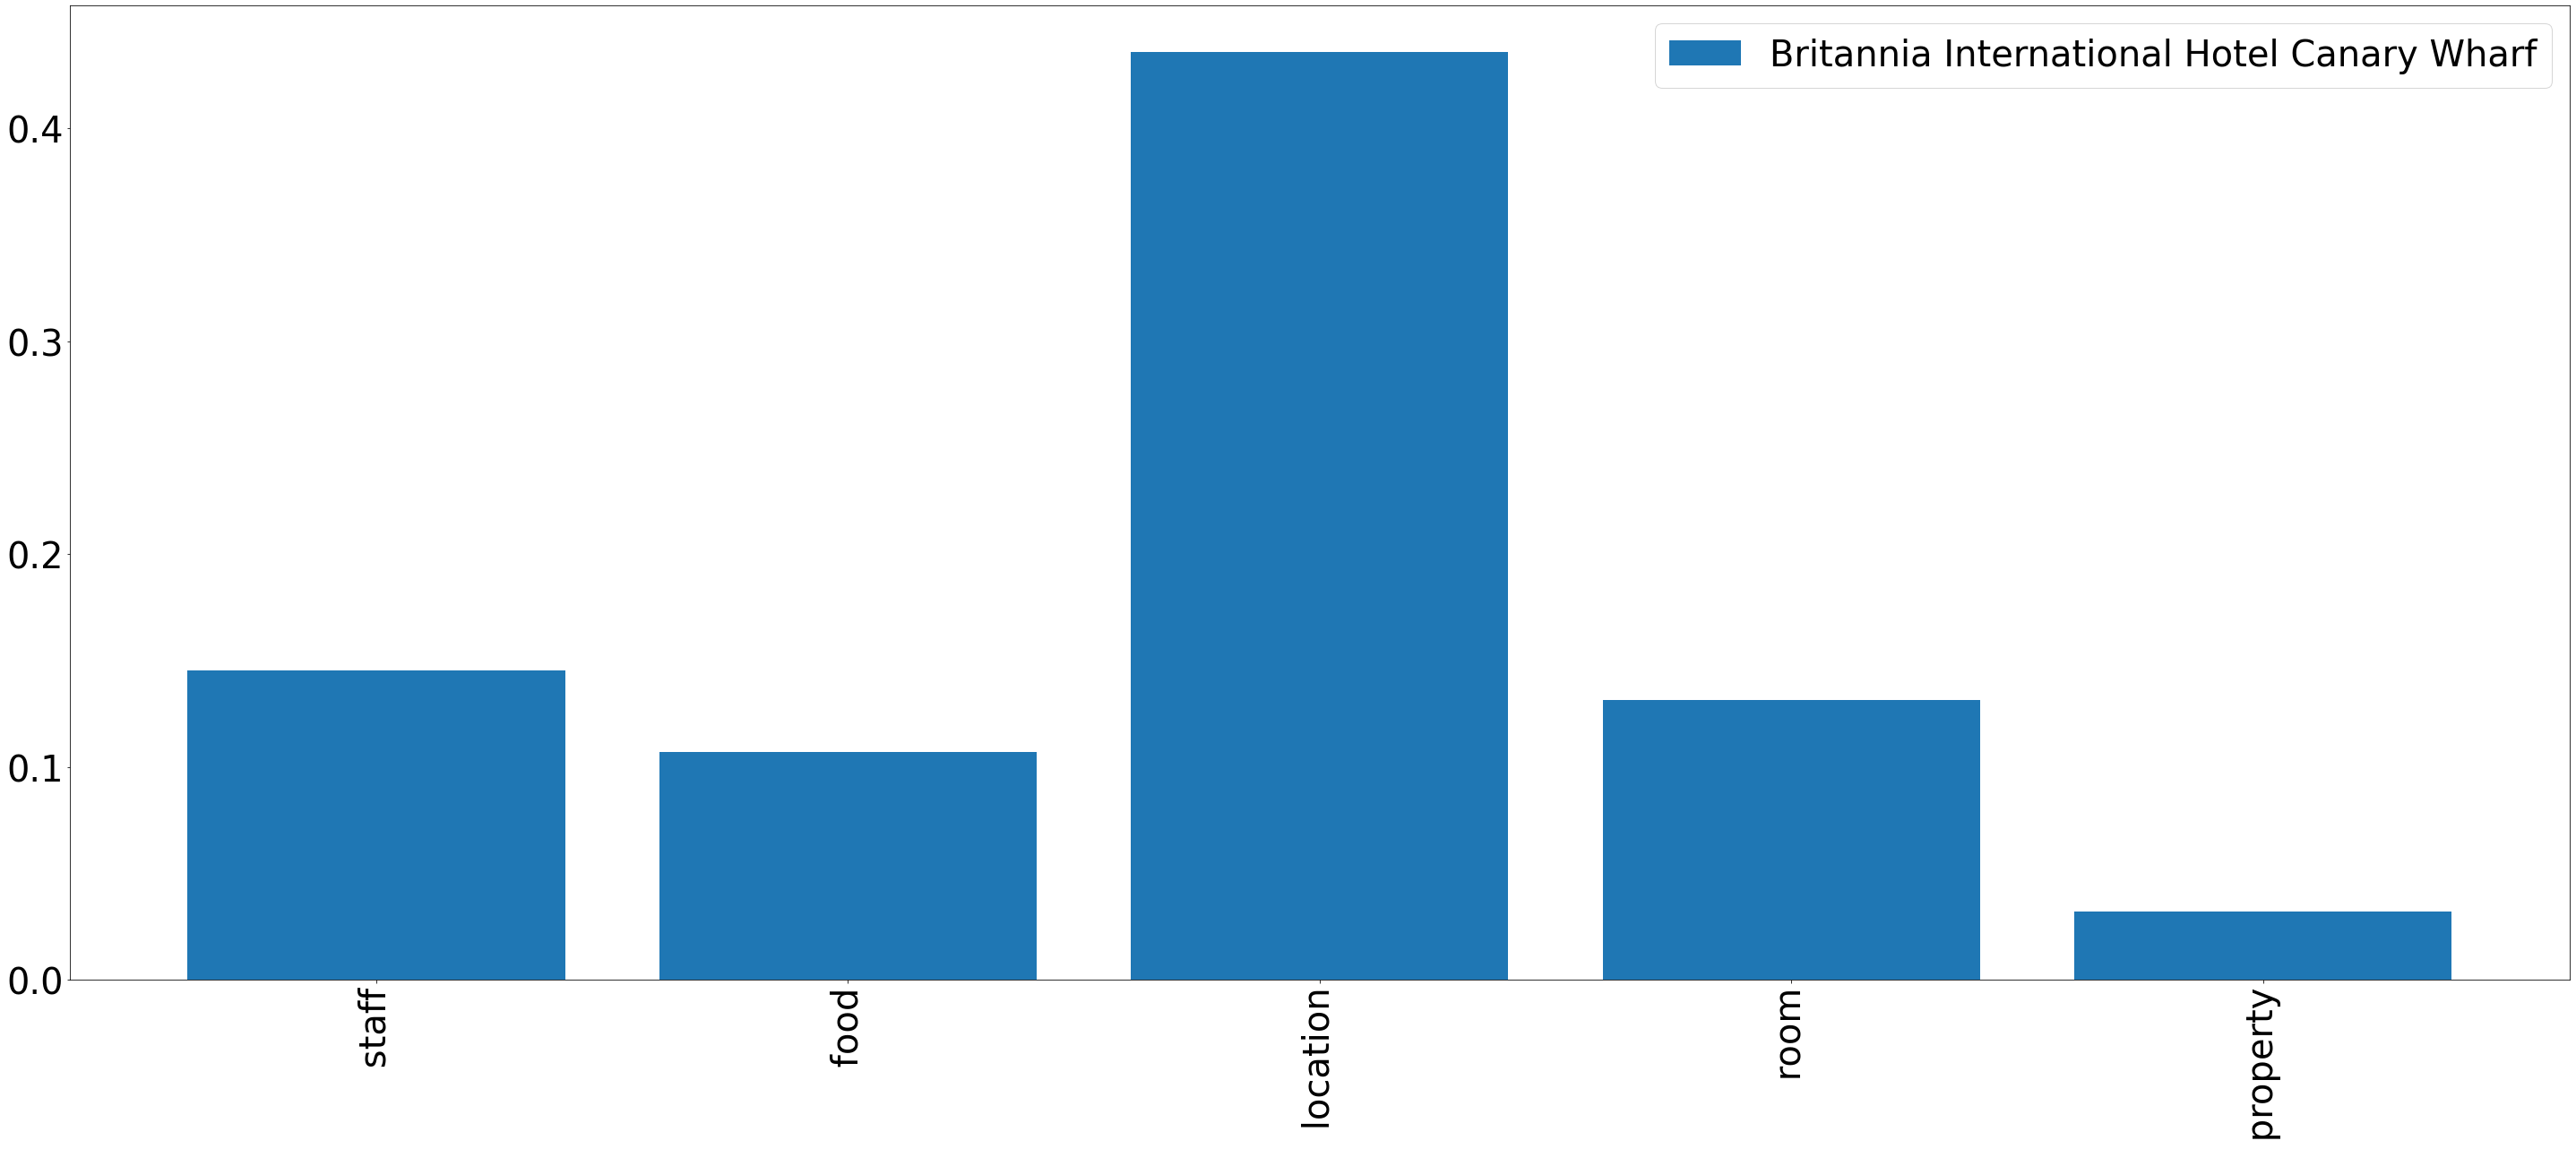

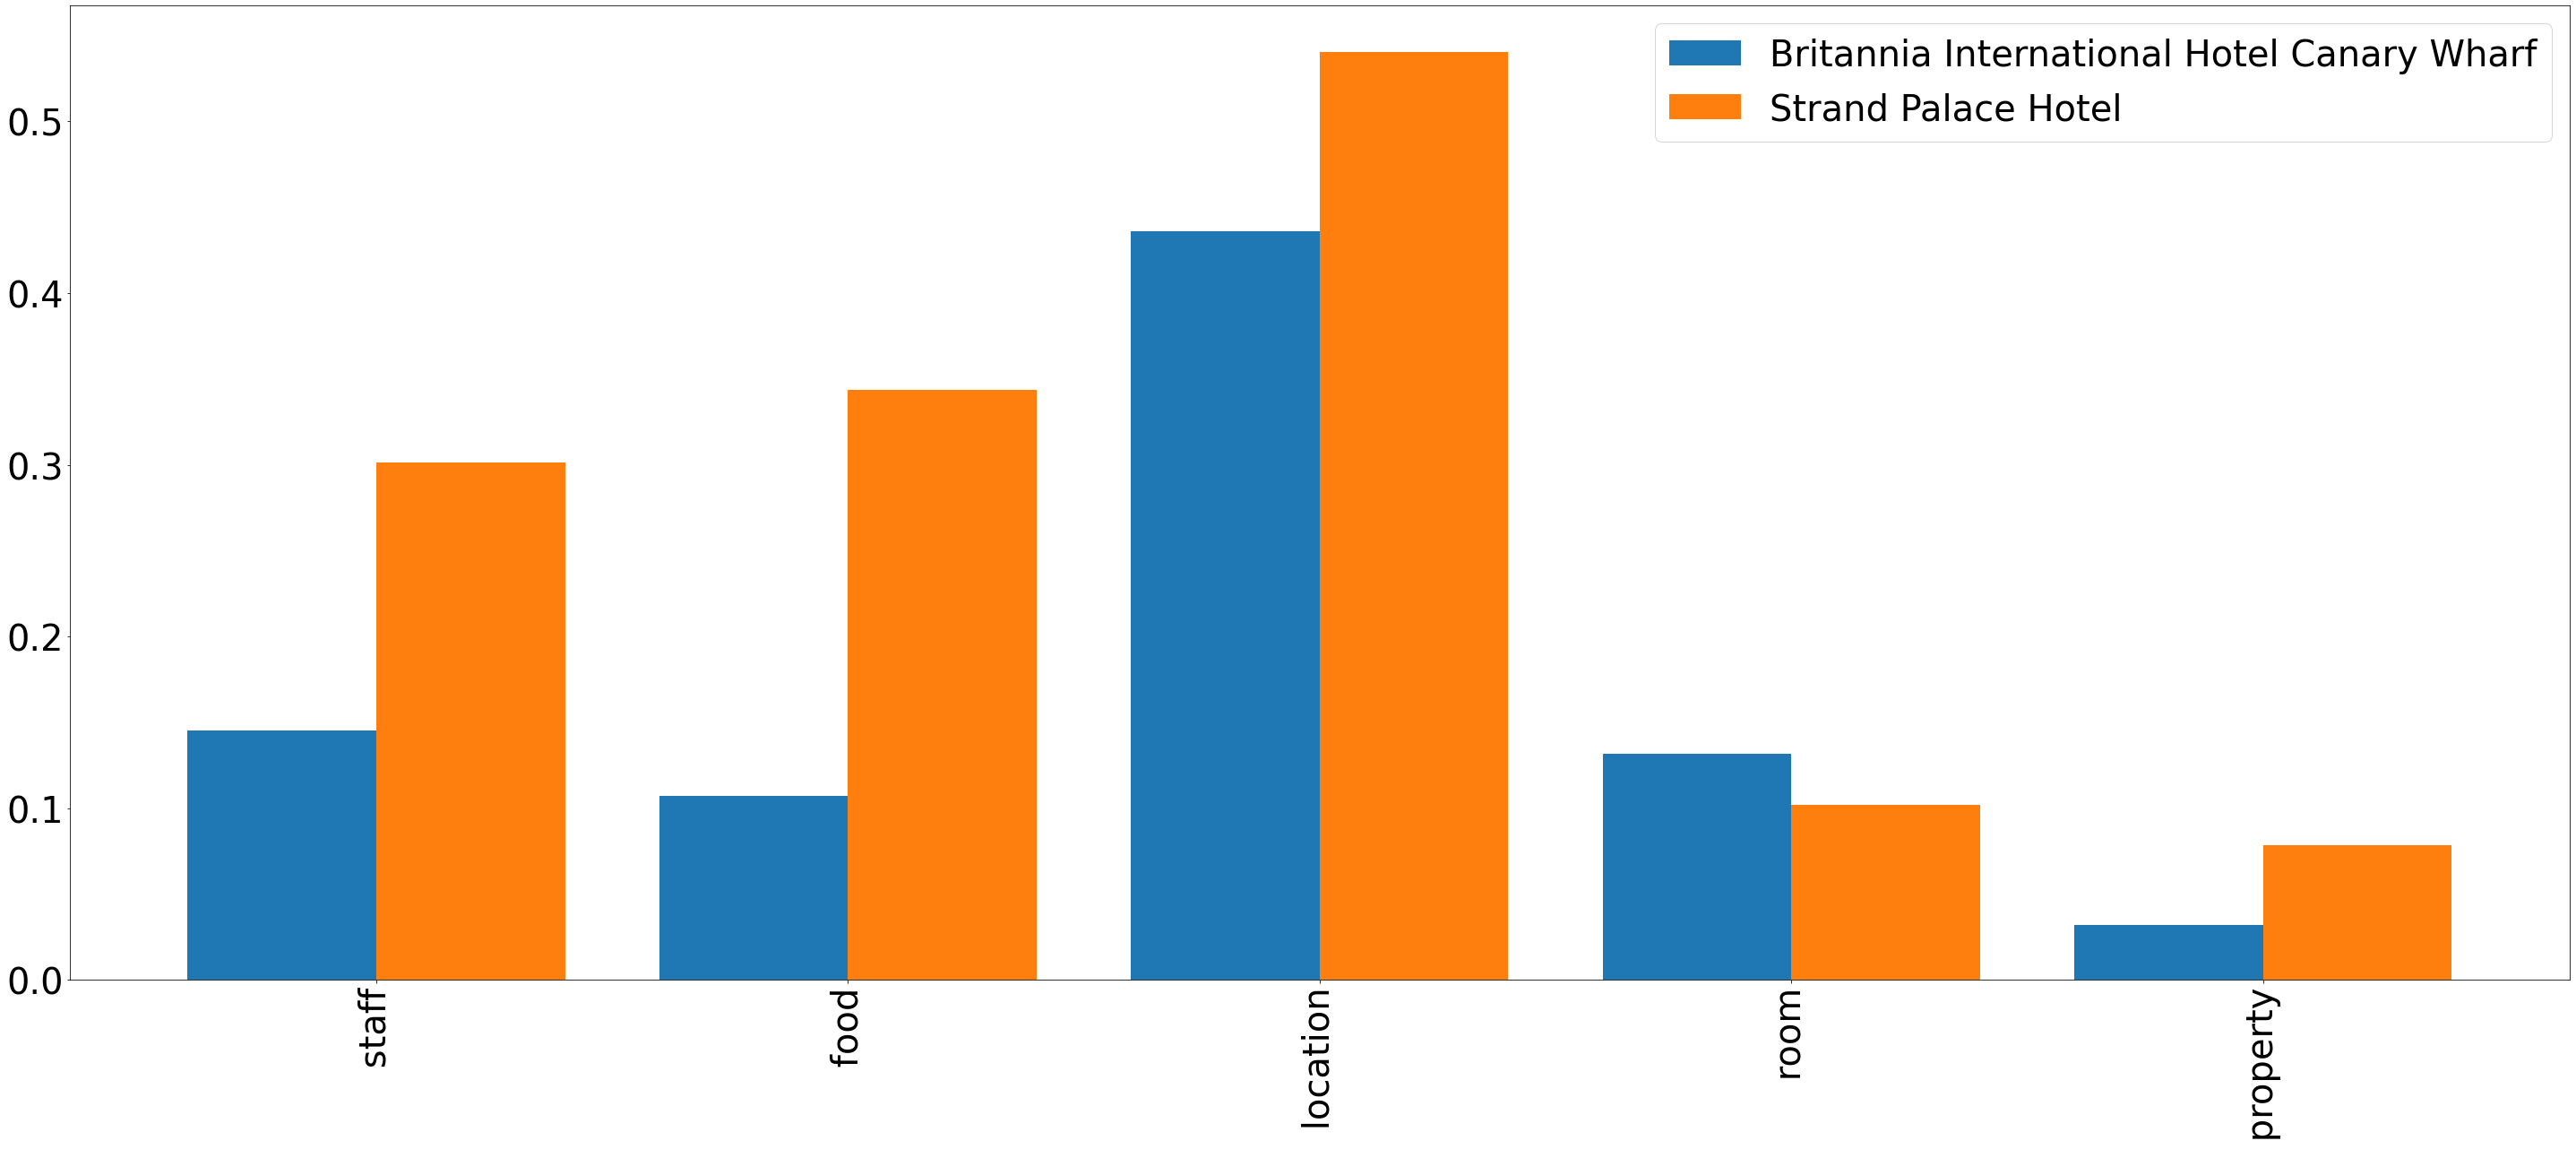

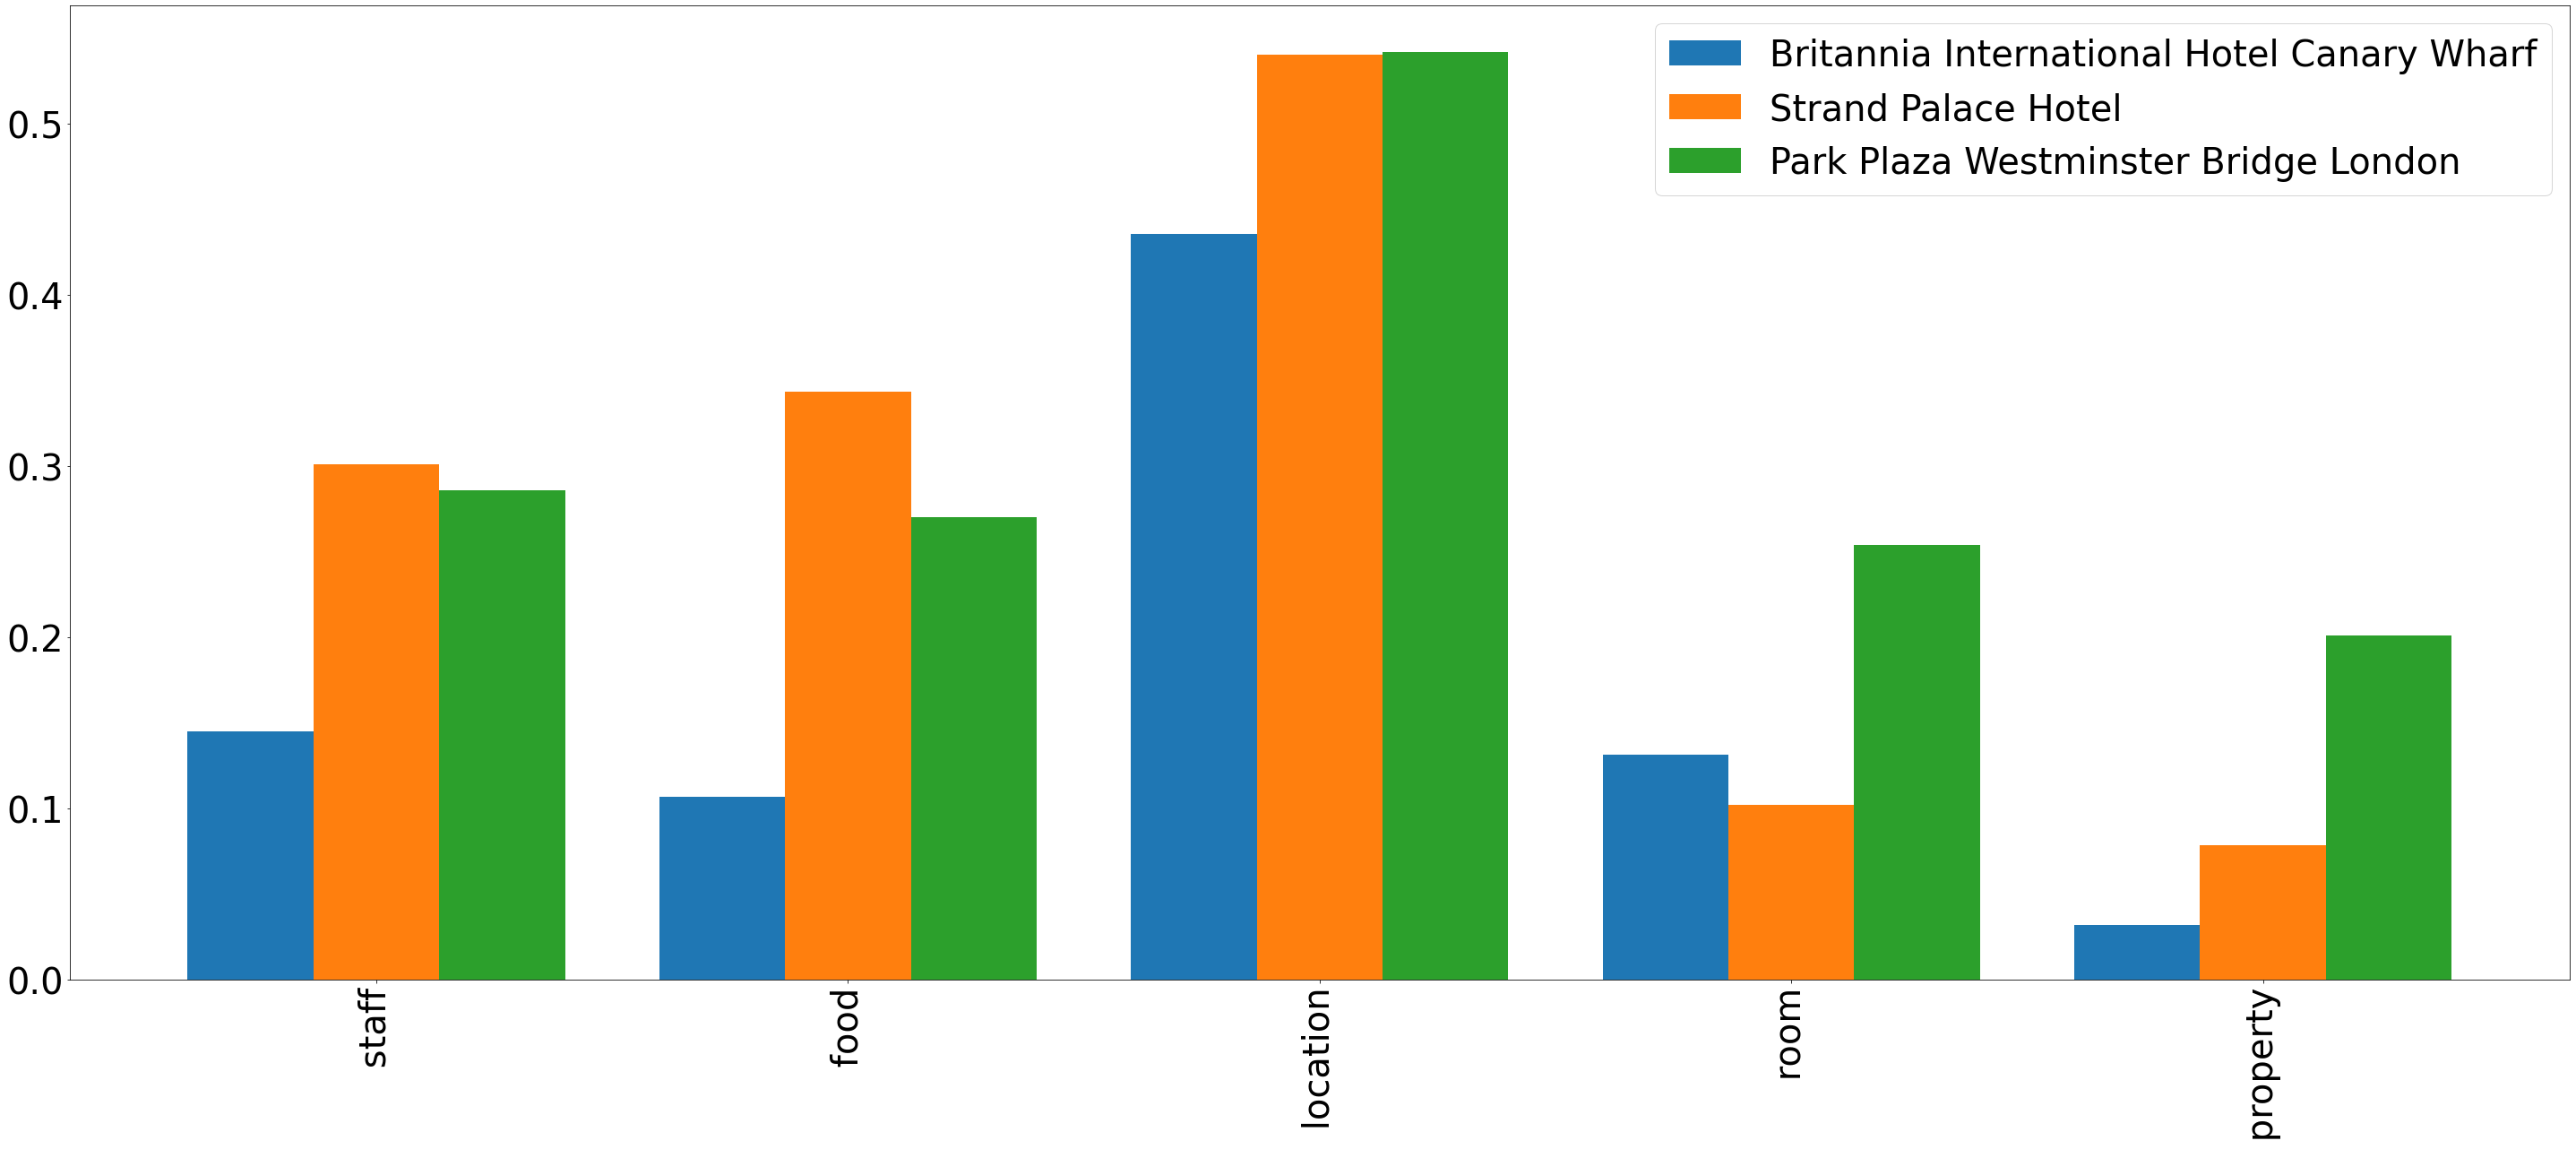

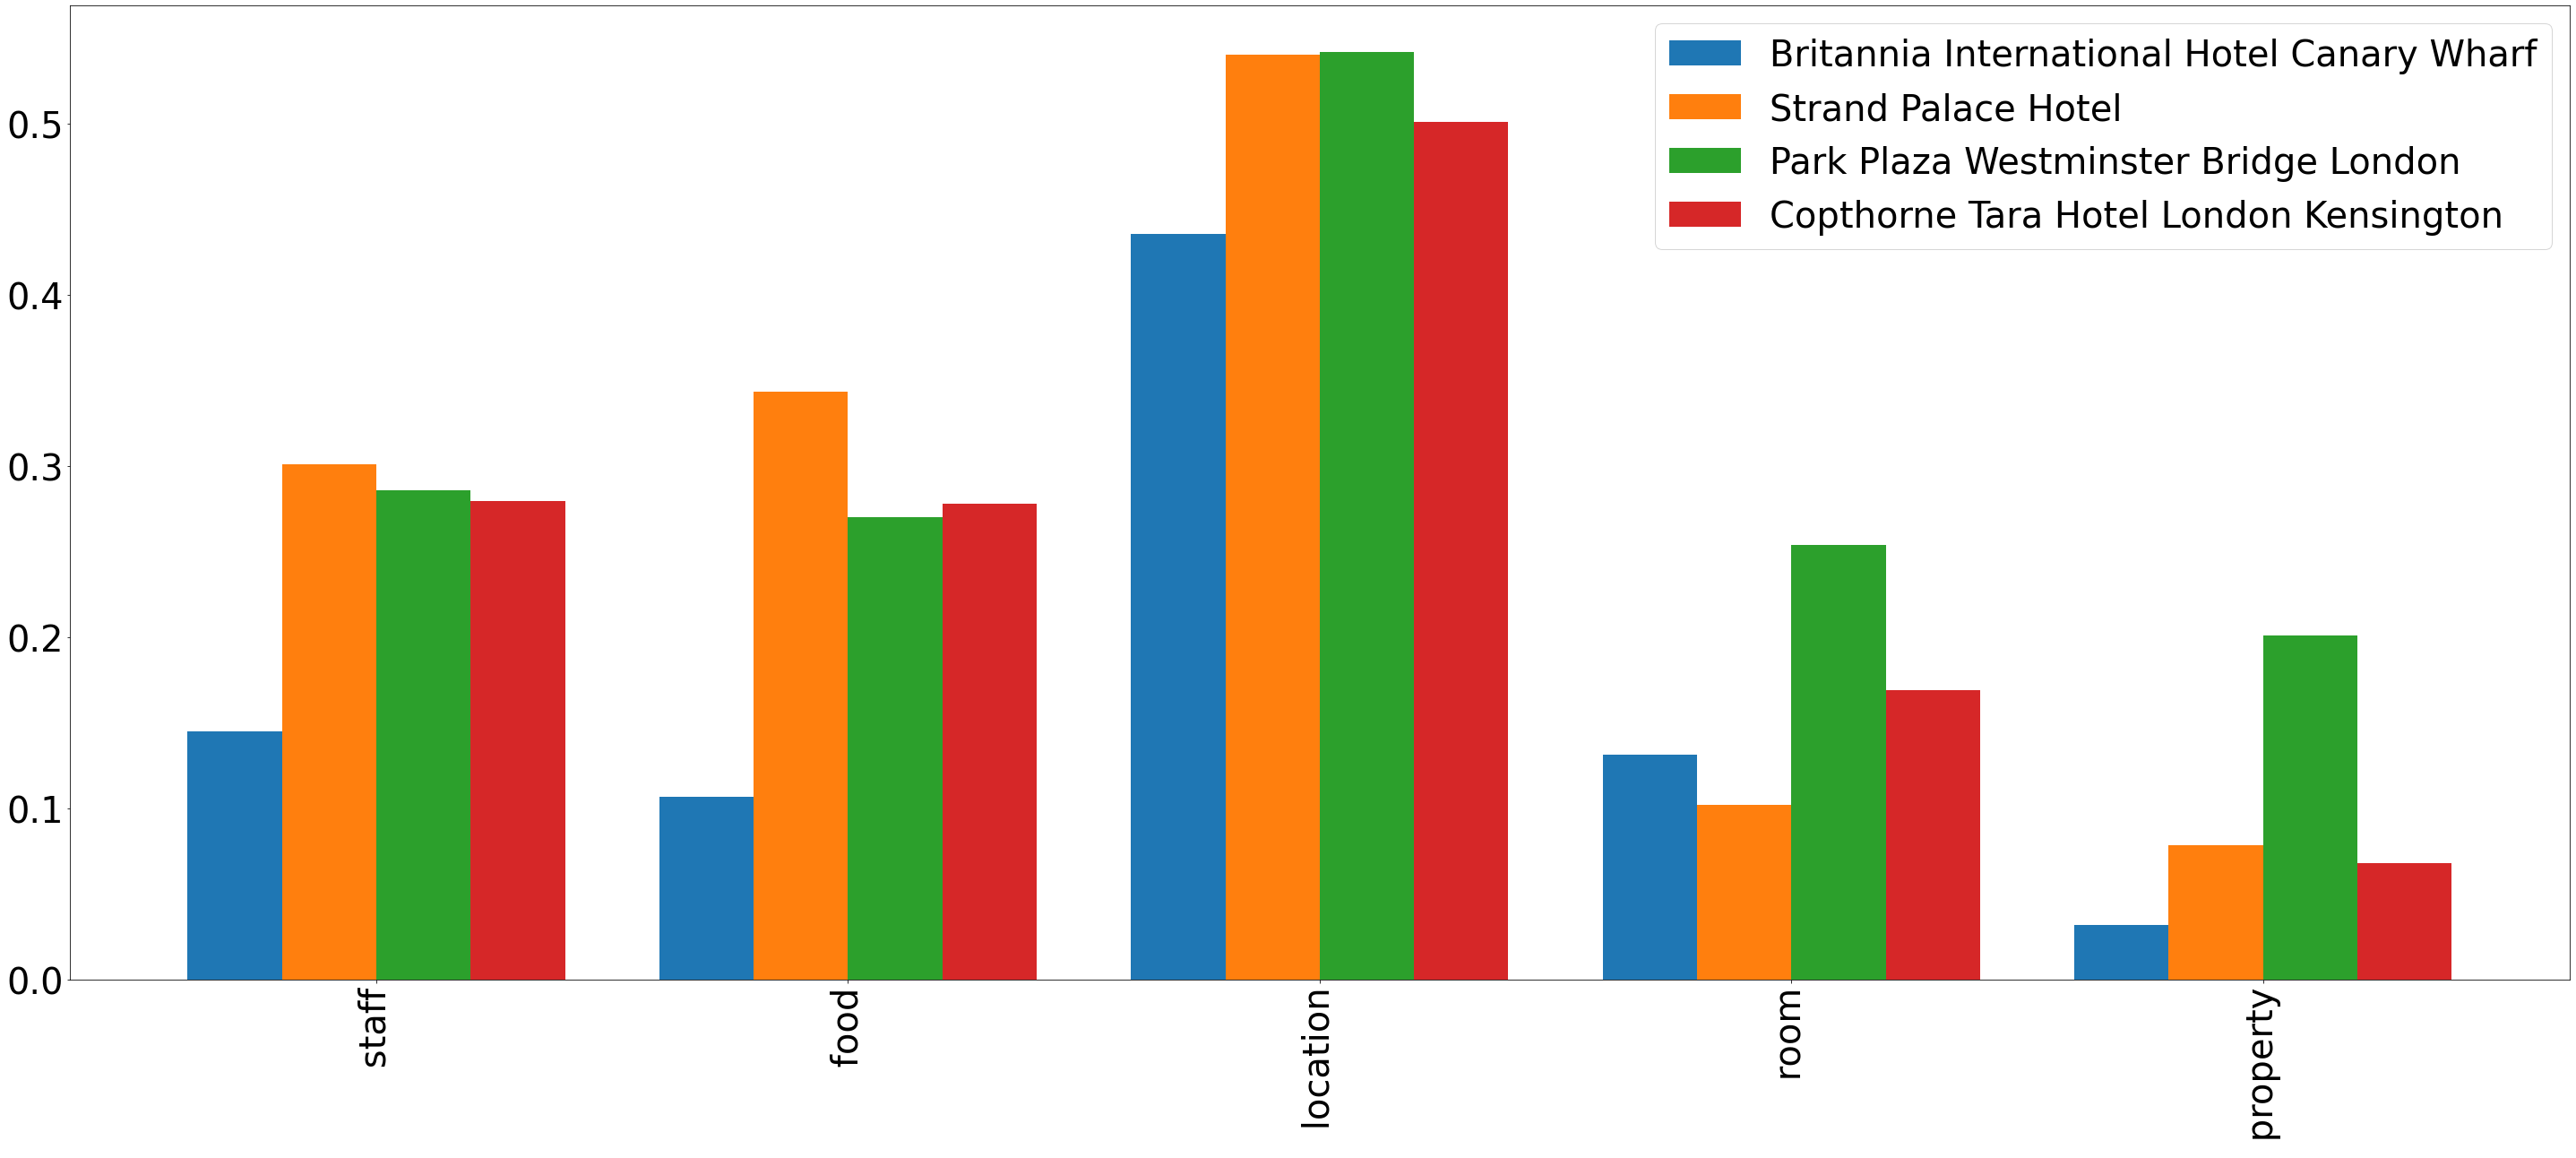

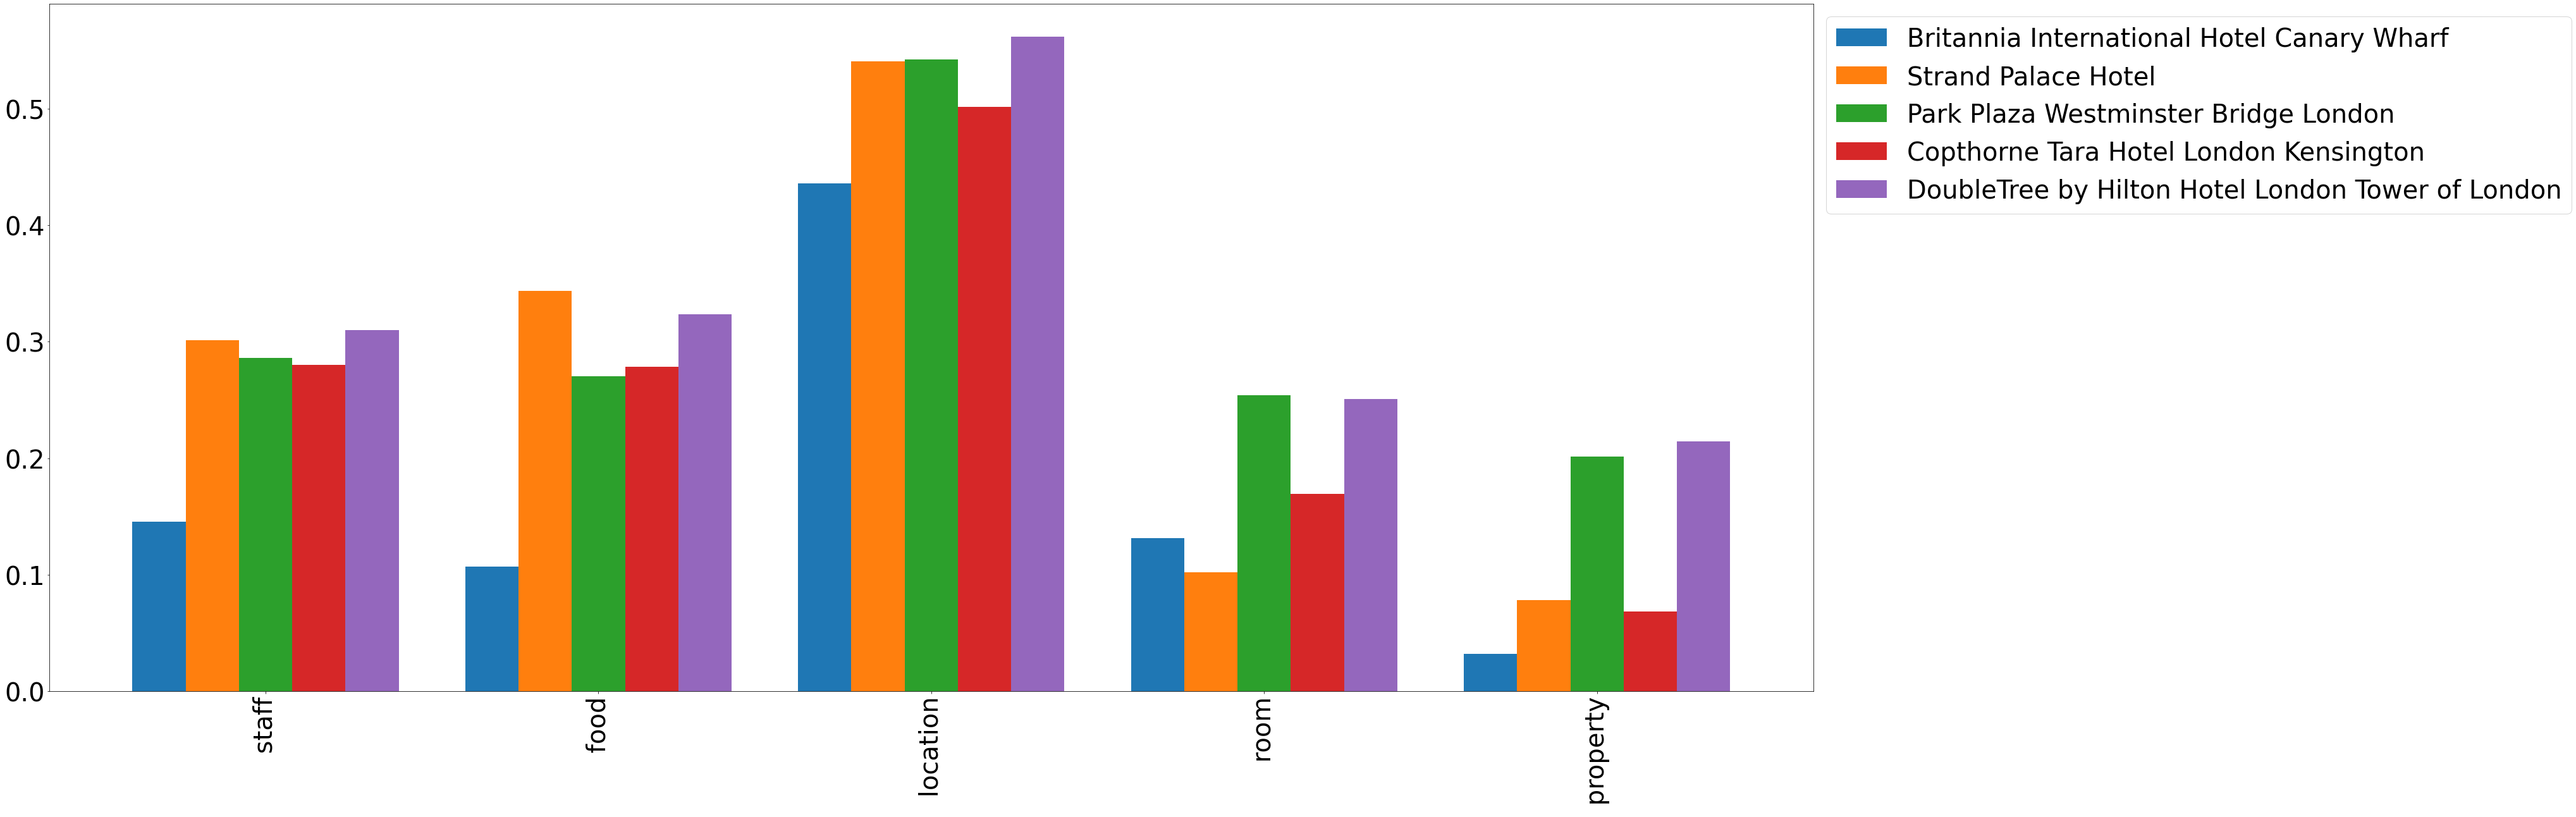

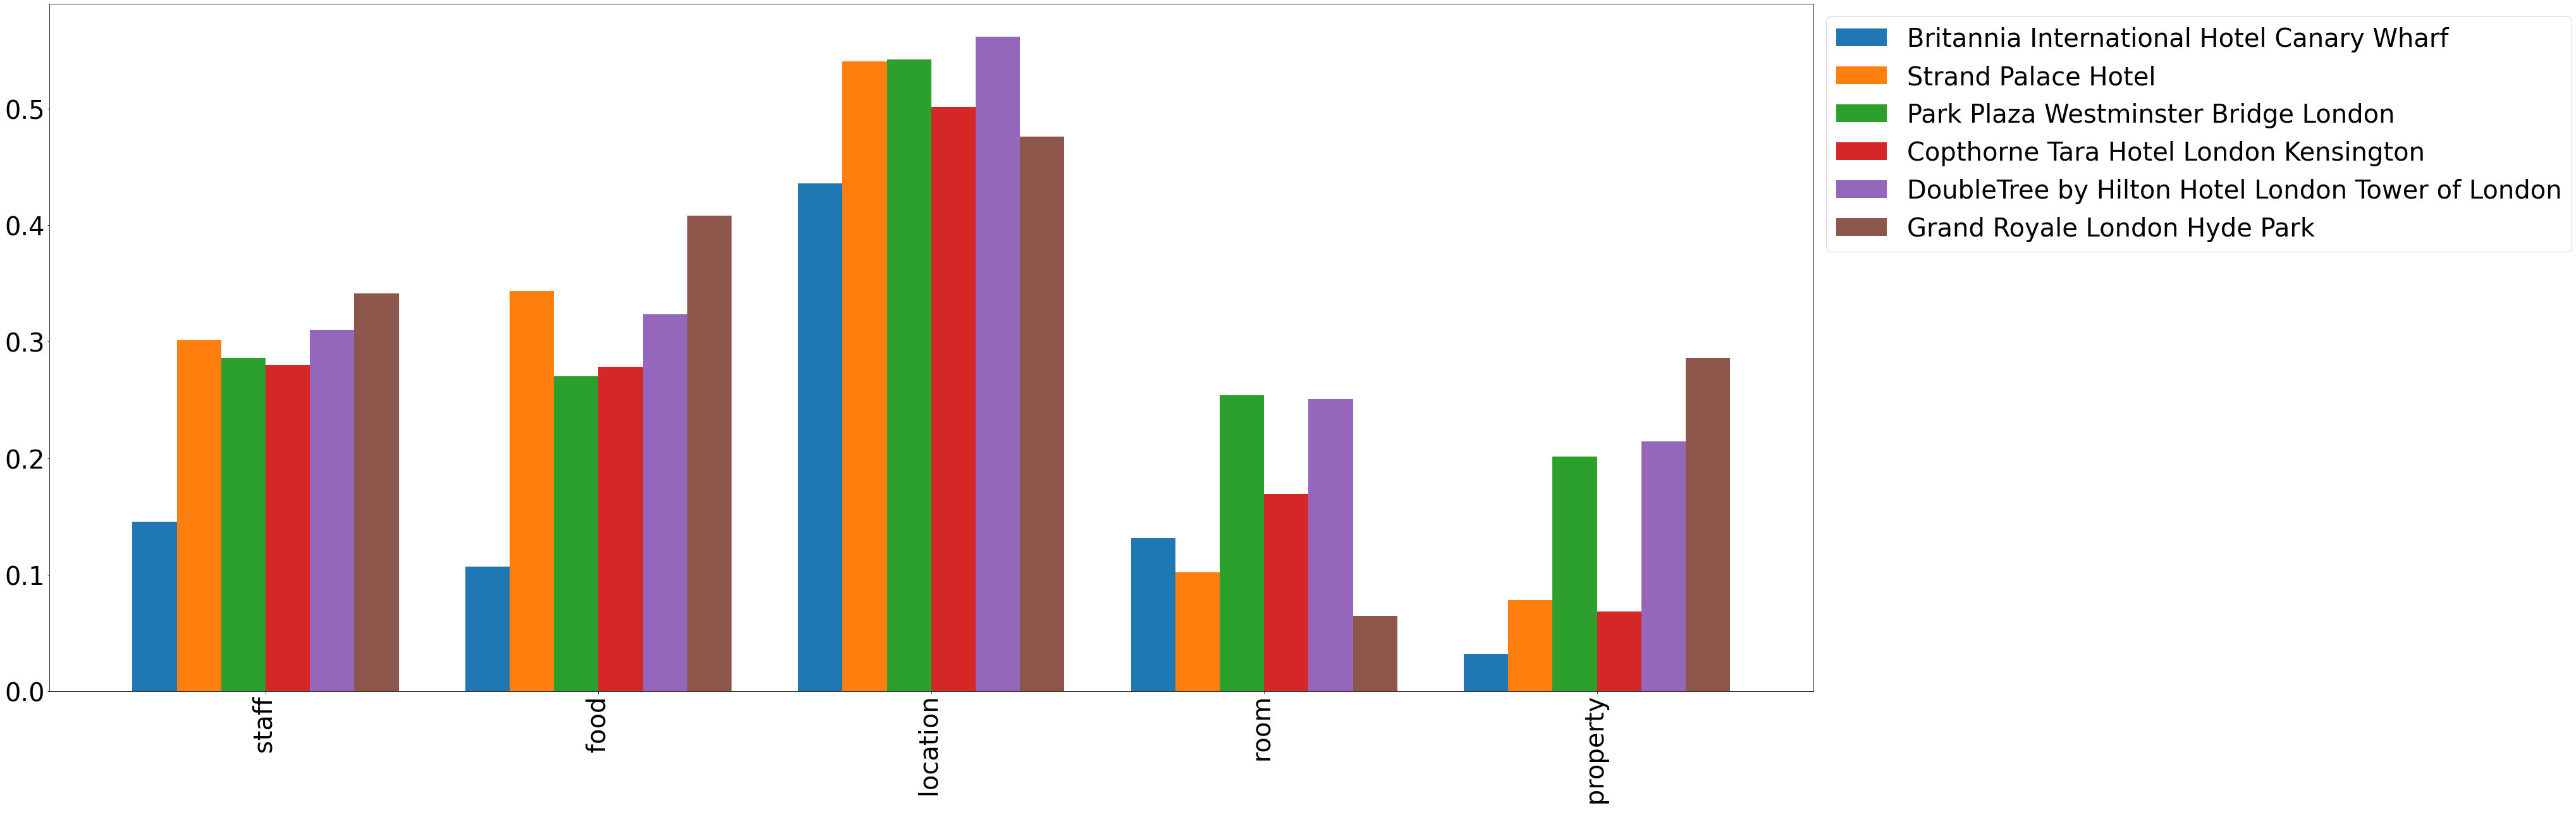

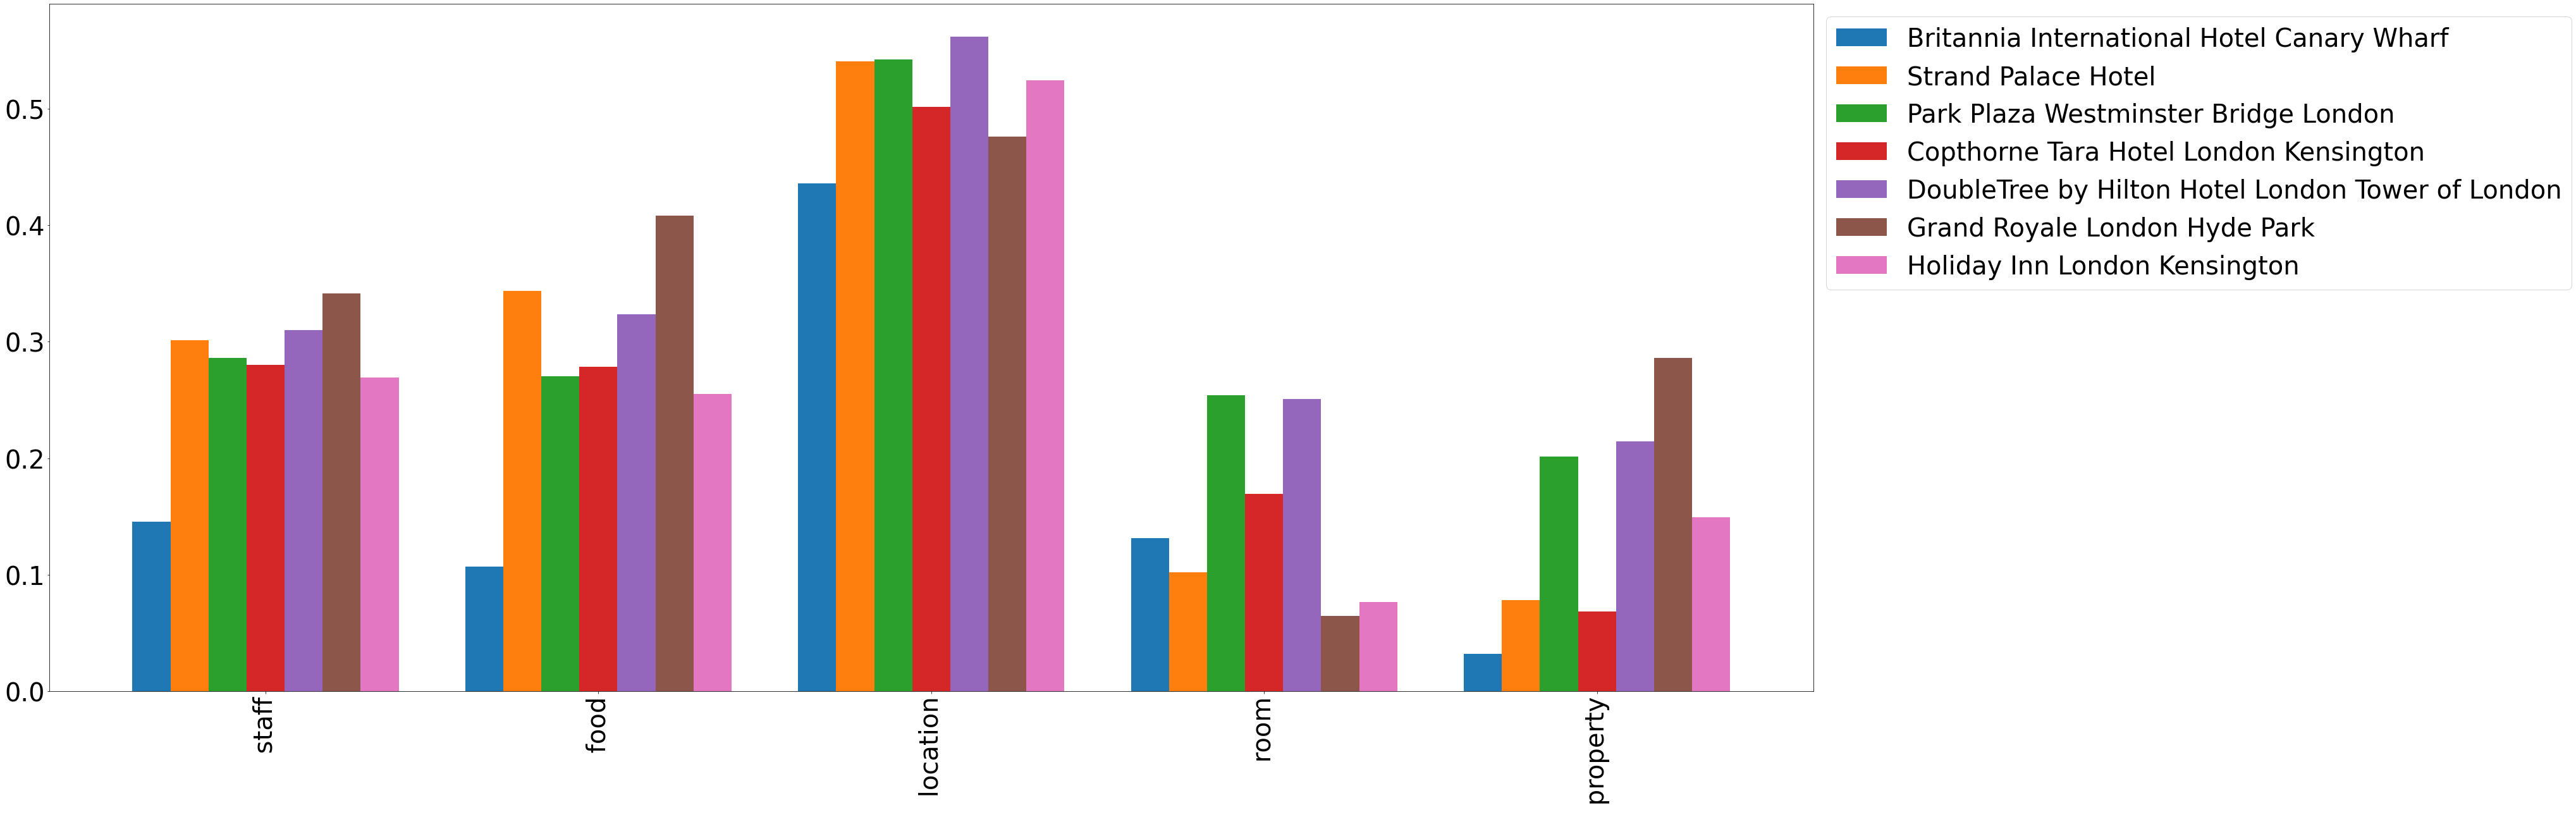

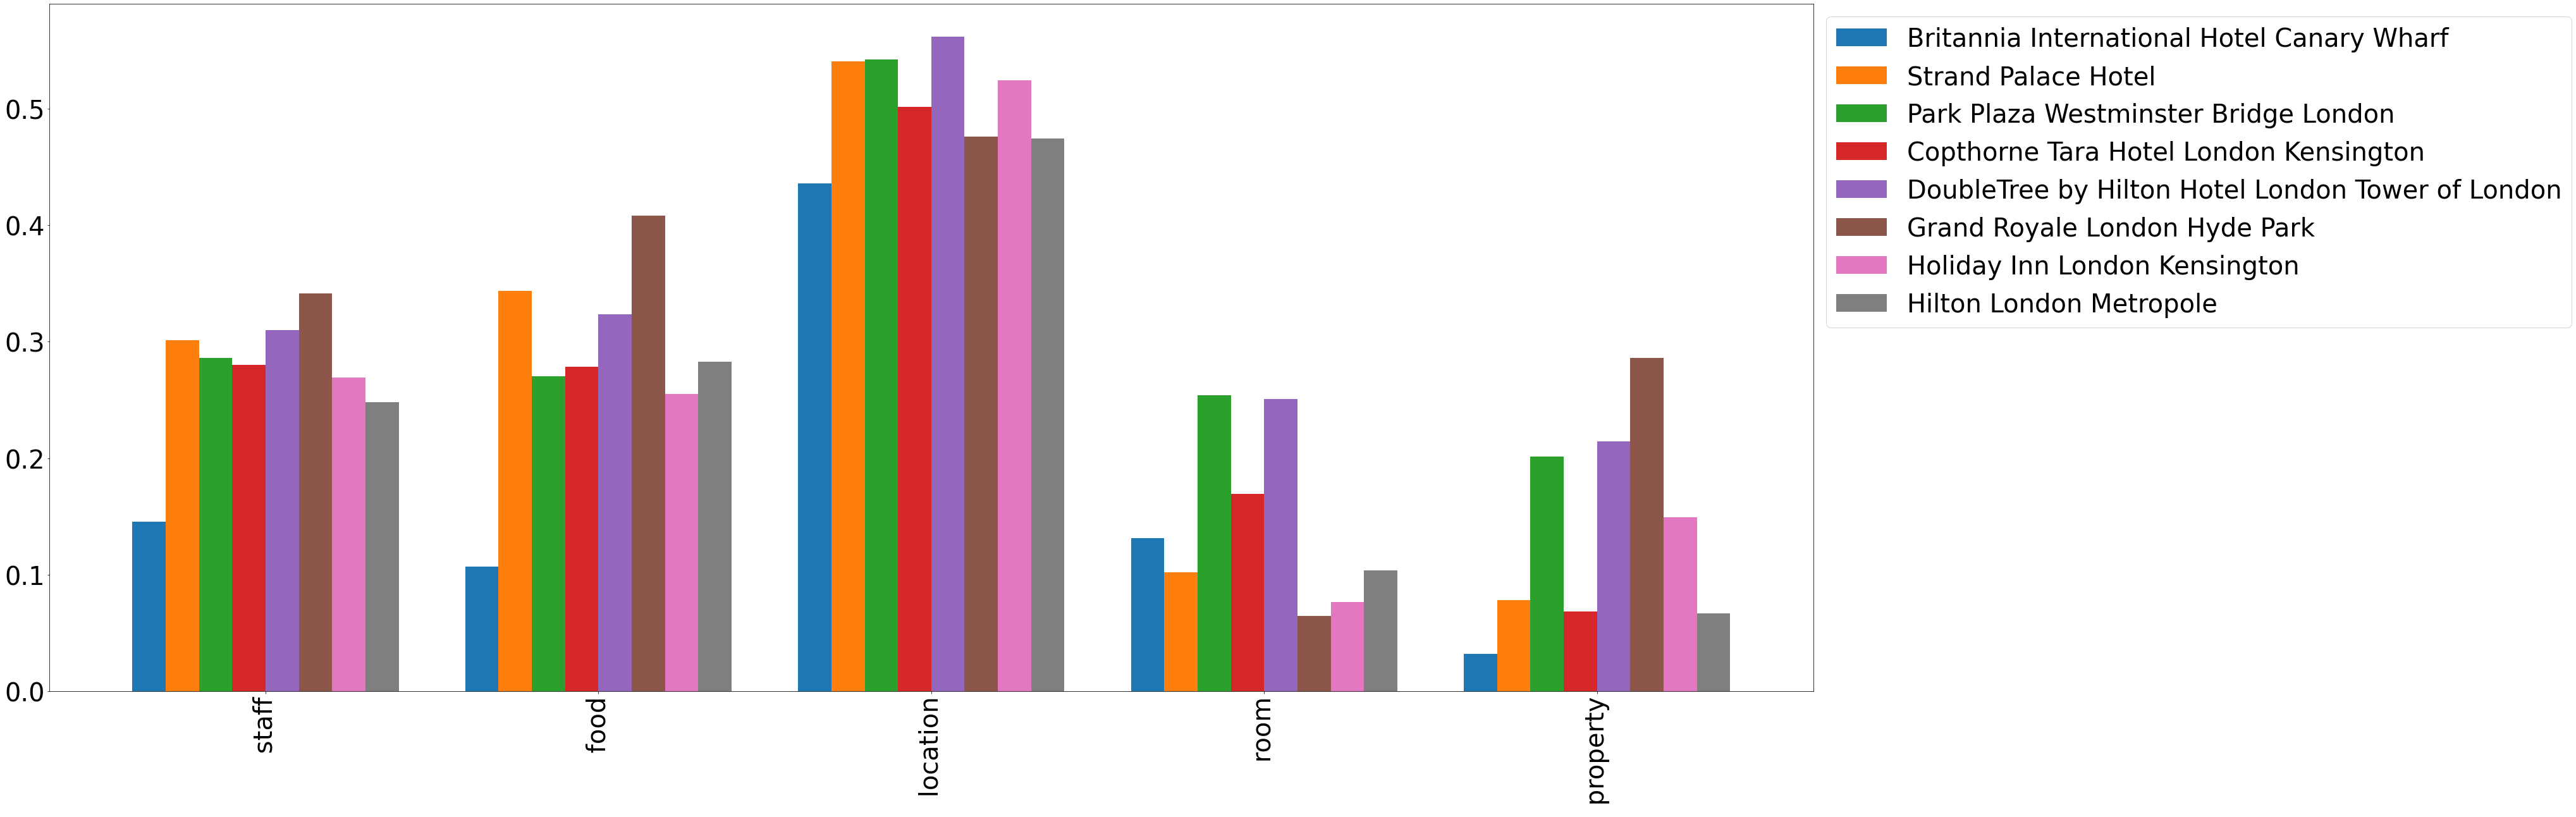

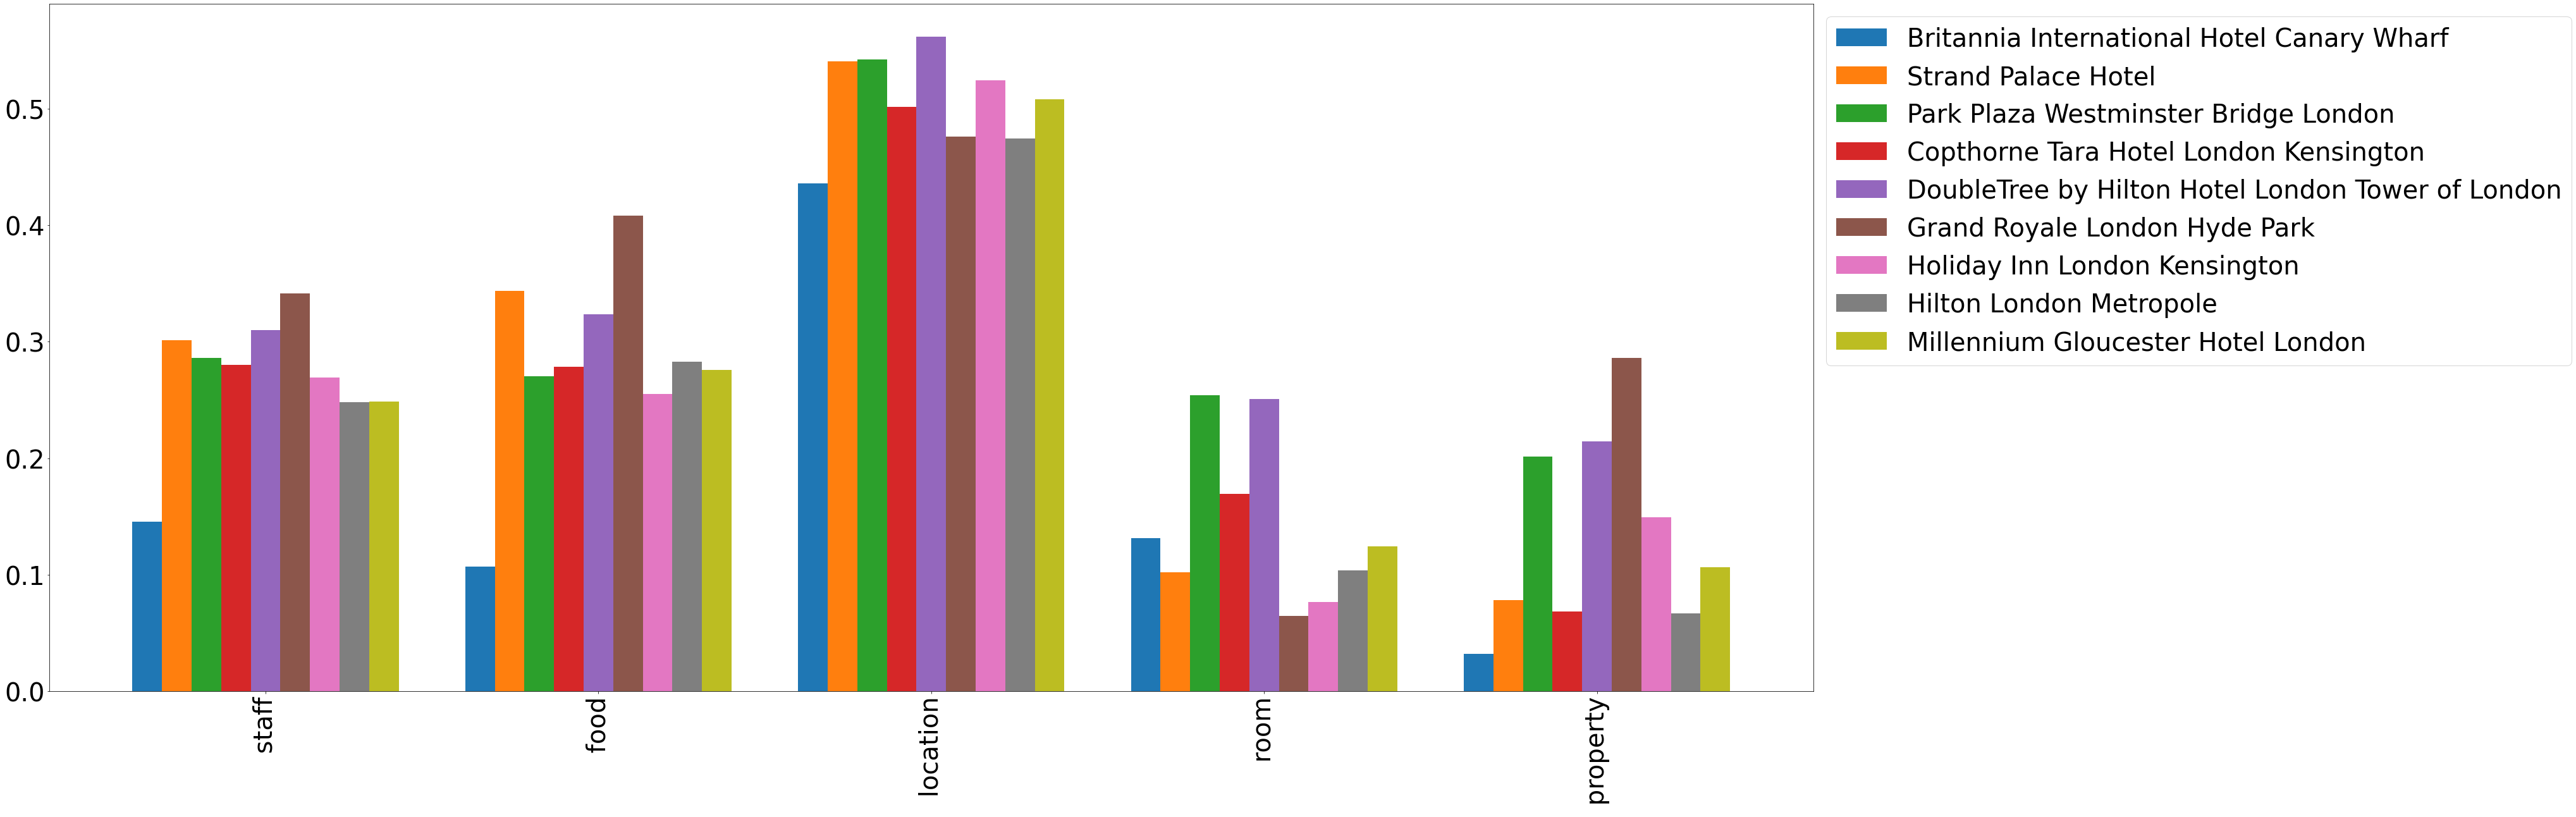

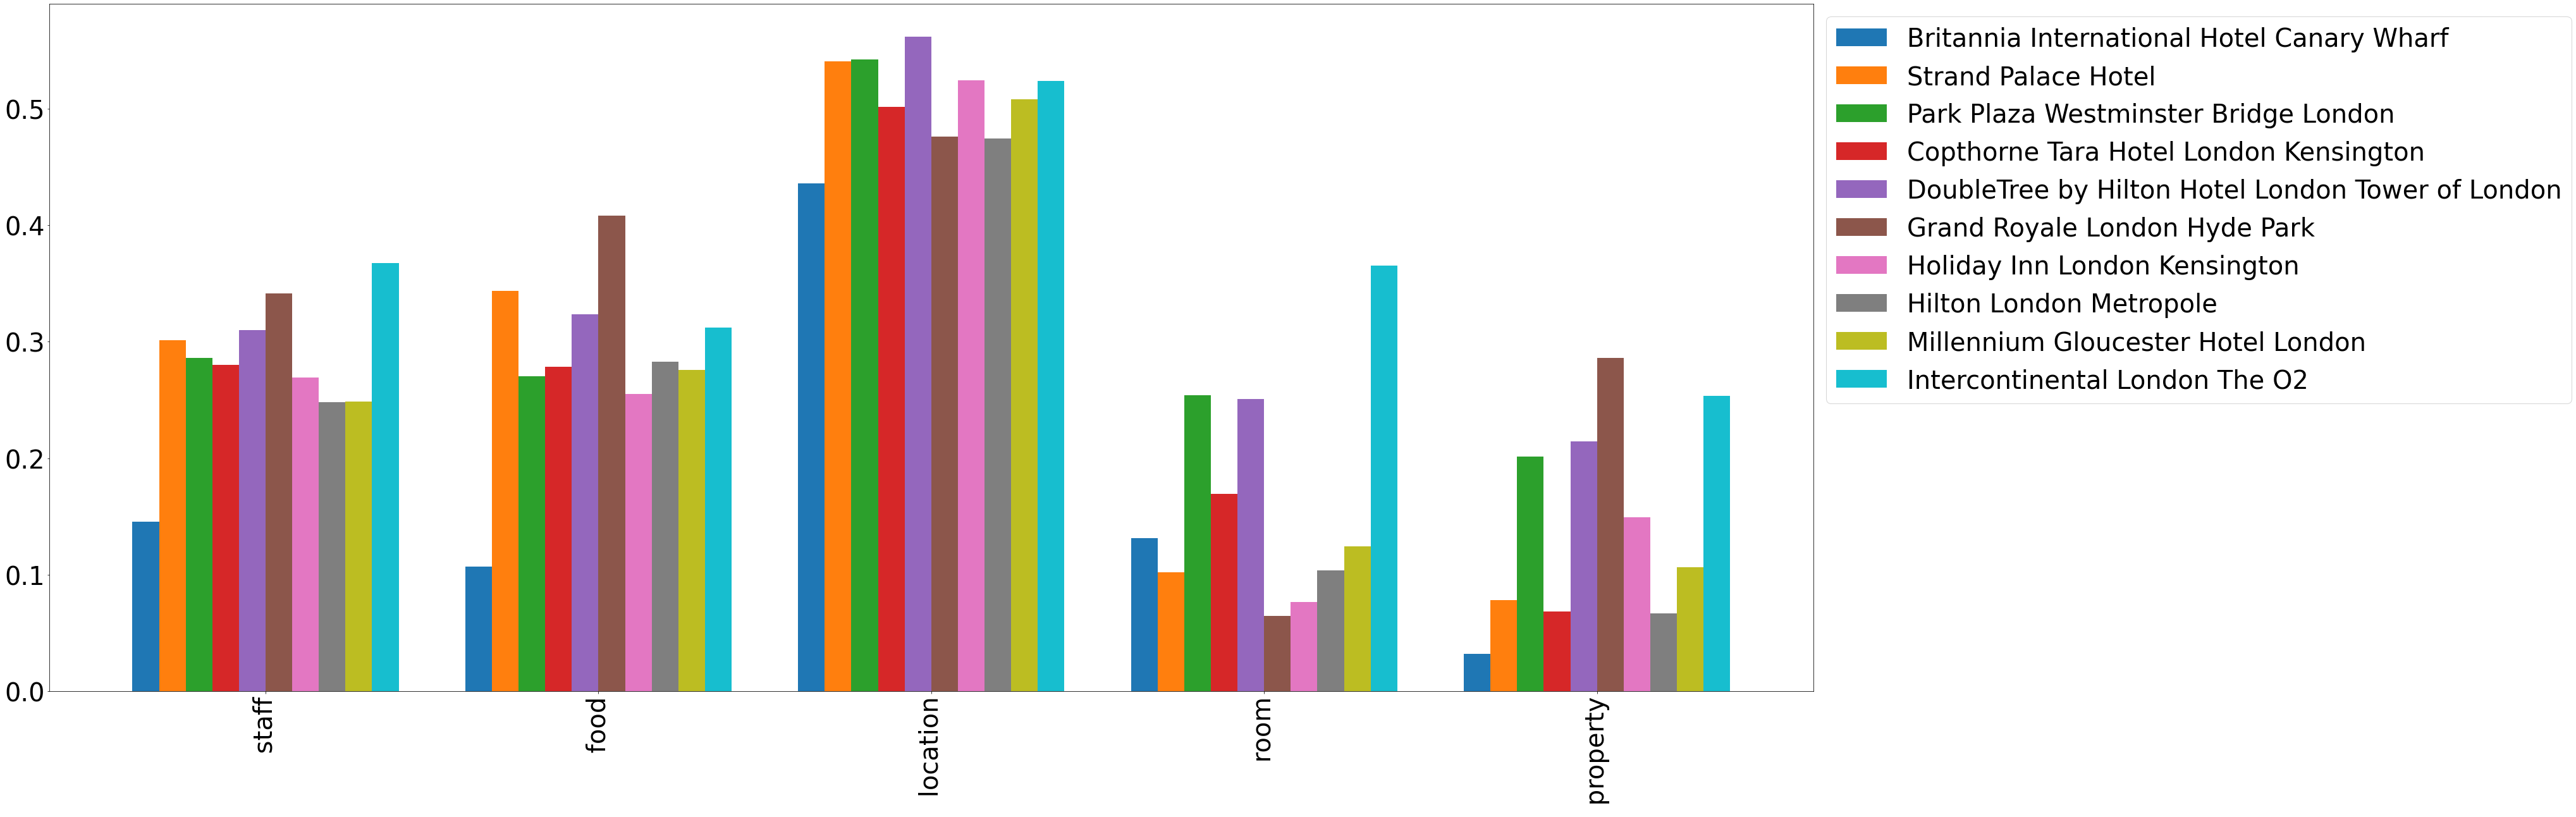

In [292]:
# data lists for sentiment scores of our aspect groups
means = []
staff = []
rooms = []
prop = []
food = []
loc = []

# where to save our data and how to name it (with incrementing id)
path = strPath[0:len(strPath)-5] + '/output/' 
id = 0

# generating plots of our own aspect groups by group with the hotels being color-coded
for name, aspectsTotal, cleanedAspectsPos, countAllAspectsPos, fiveMostCommonPos,  cleanedAspectsNeg, countAllAspectsNeg, fiveMostCommonNeg, sentRoom, sentProperty,  sentFood, sentLocation, sentStaff, sentNationality, sentNegSelf, sentPosSelf in data.values:
    figName = str(id) + "Summed" + ".pdf"
    mean = [sentStaff, sentFood, sentLocation, sentRoom, sentProperty]
    staff.append(sentStaff)
    rooms.append(sentRoom)
    prop.append(sentProperty)
    food.append(sentFood)
    loc.append(sentLocation)
    means.append((name, means))  

    byAspects = [staff, food, loc, rooms, prop]

    df = pd.DataFrame([asp for asp in byAspects], index = [' staff', ' food', ' location', ' room', ' property'])

    plt.rcParams.update({'font.size': 40}) 

    df.plot(kind='bar', legend=True, width=0.8, figsize=(50,20))
    plt.legend([mean[0] for mean in means], bbox_to_anchor=(1.0, 1.0))
    plt.savefig(path + figName)
    #plt.show()
    id += 1

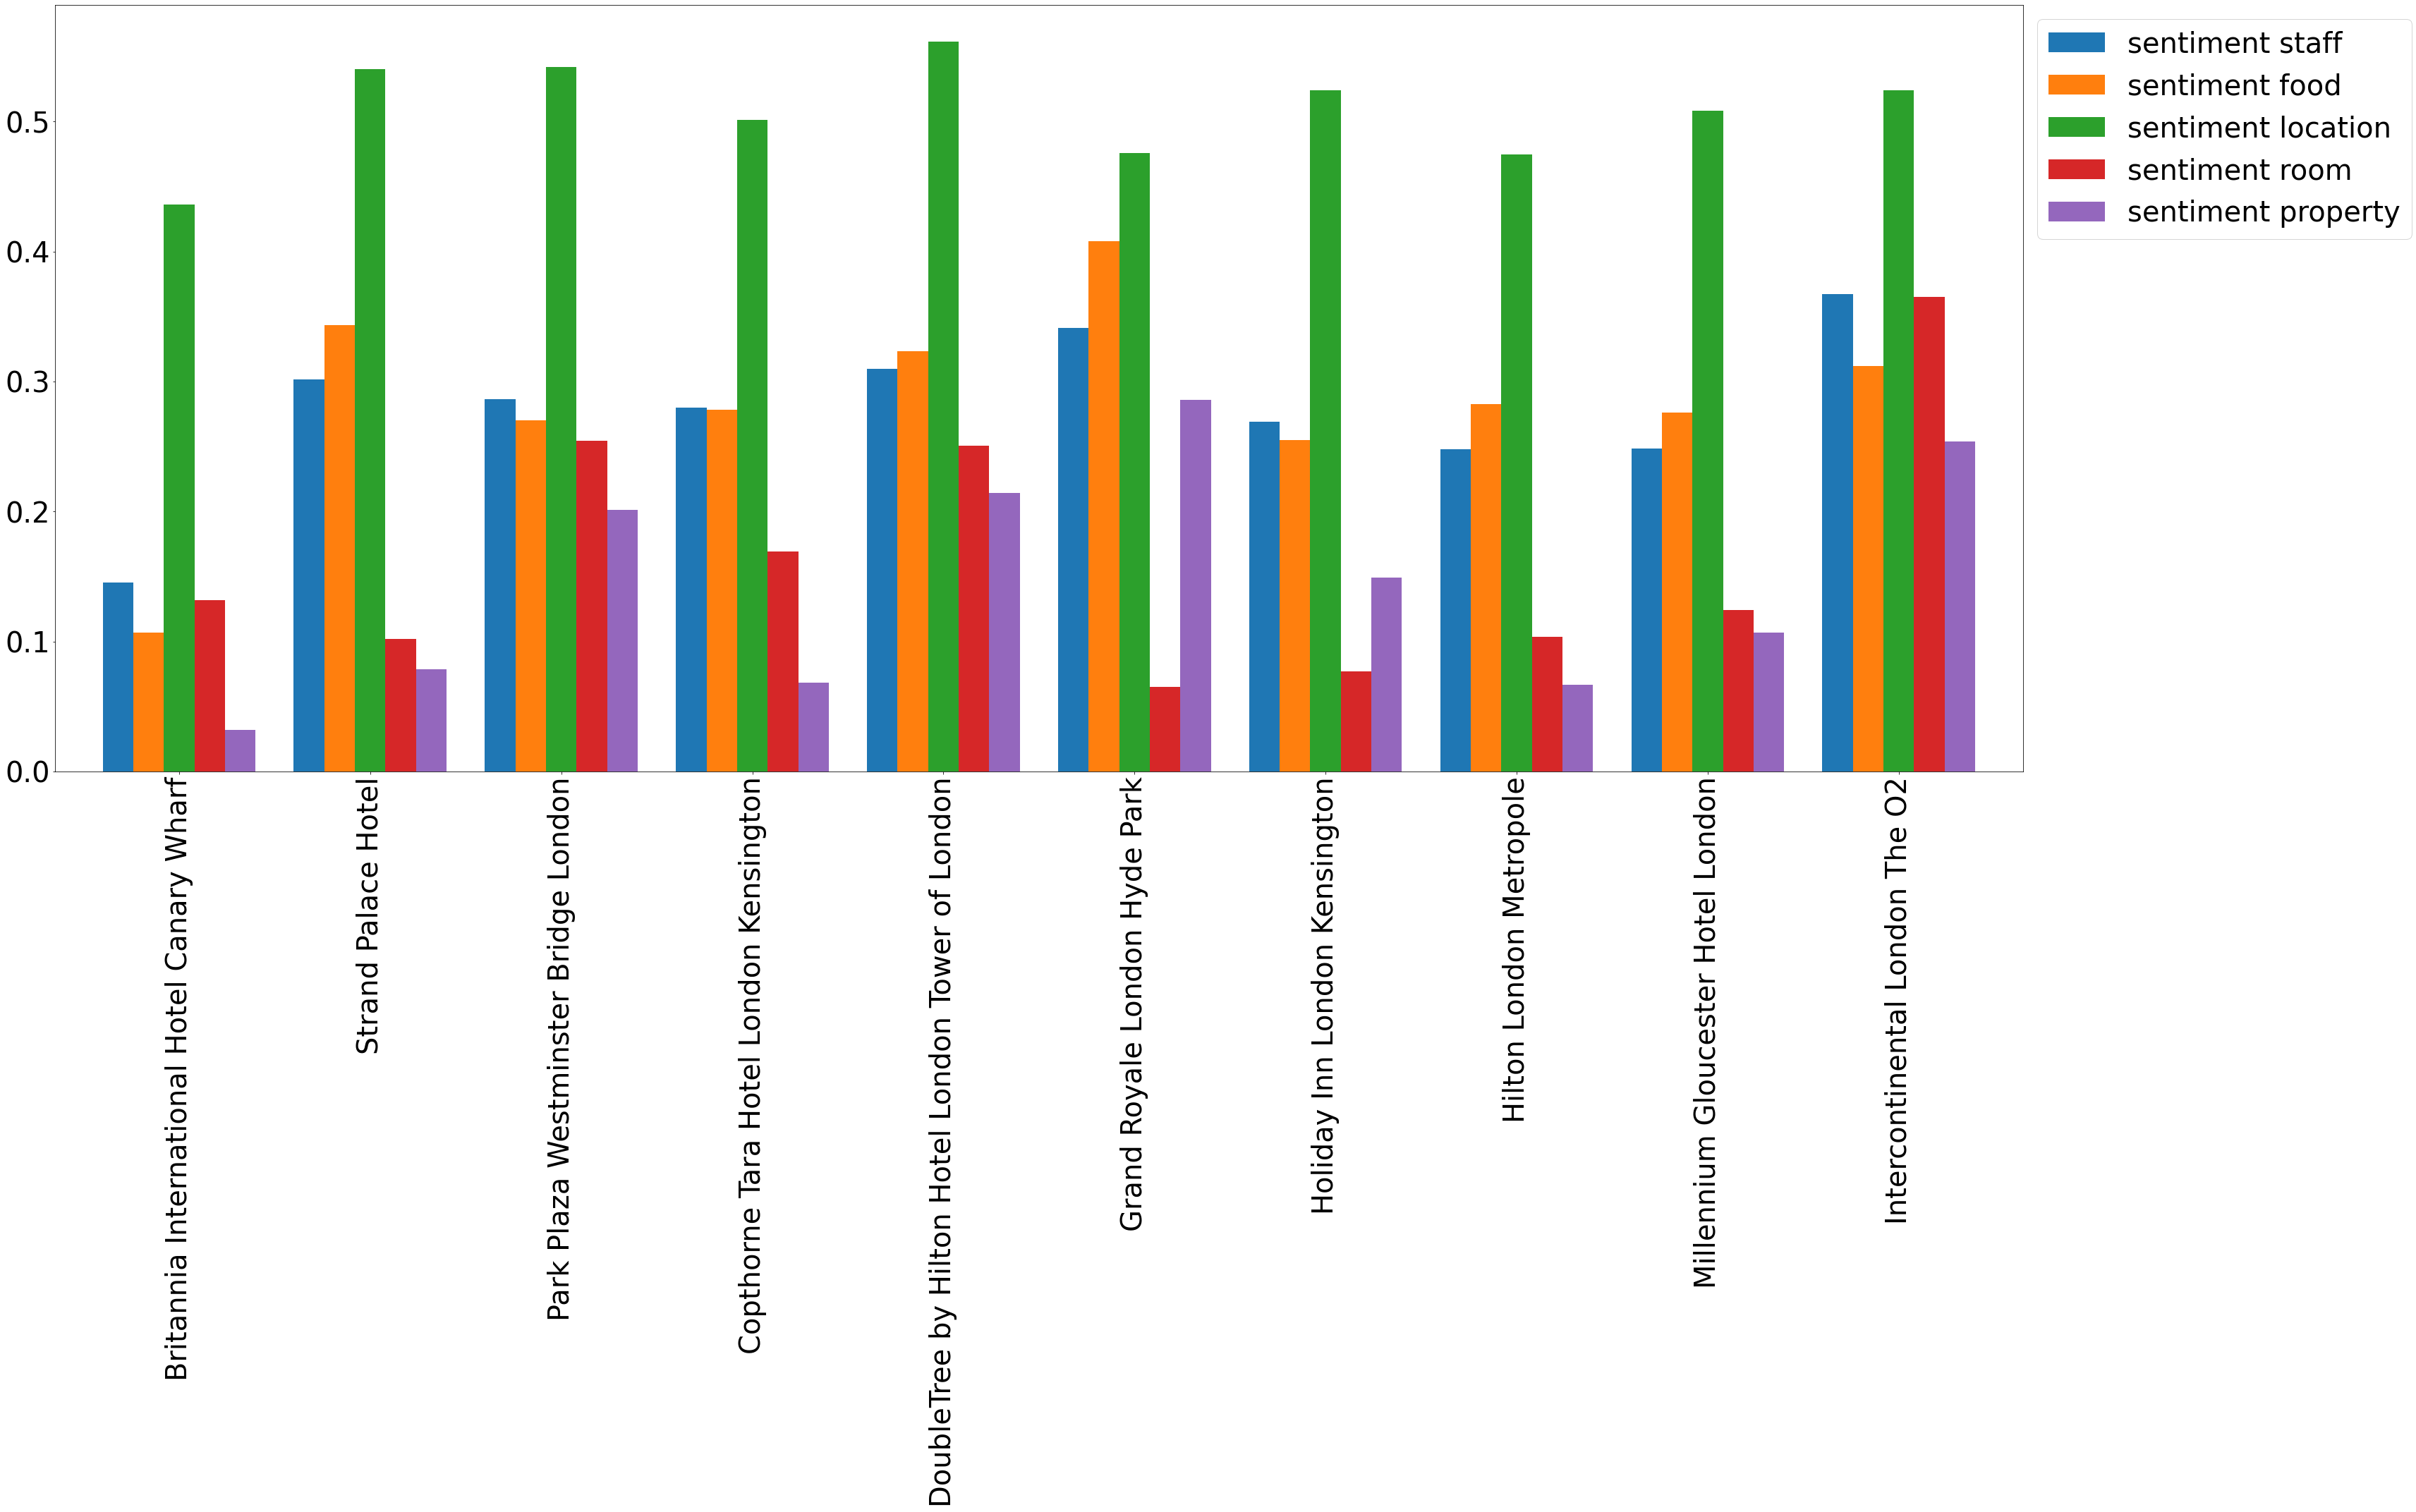

In [293]:
#generating plots of each aspect group by hotel
means = []
path = strPath[0:len(strPath)-5] + '/output/' 
for name, aspectsTotal, cleanedAspectsPos, countAllAspectsPos, fiveMostCommonPos,  cleanedAspectsNeg, countAllAspectsNeg, fiveMostCommonNeg, sentRoom, sentProperty,  sentFood, sentLocation, sentStaff, sentNationality, sentNegSelf, sentPosSelf  in data.values:
   mean = [sentStaff, sentFood, sentLocation, sentRoom, sentProperty]
   means.append((name, mean))  

df = pd.DataFrame([mean[1] for mean in means], index = [mean[0] for mean in means])

plt.rcParams.update({'font.size': 40}) 

df.plot(kind='bar', legend=True, width=0.8, figsize=(50,20))
plt.legend(['sentiment staff', 'sentiment food', 'sentiment location', 'sentiment room', 'sentiment property'], bbox_to_anchor=(1.0, 1.0))
plt.savefig(path + "ByHotel.pdf")
plt.show()


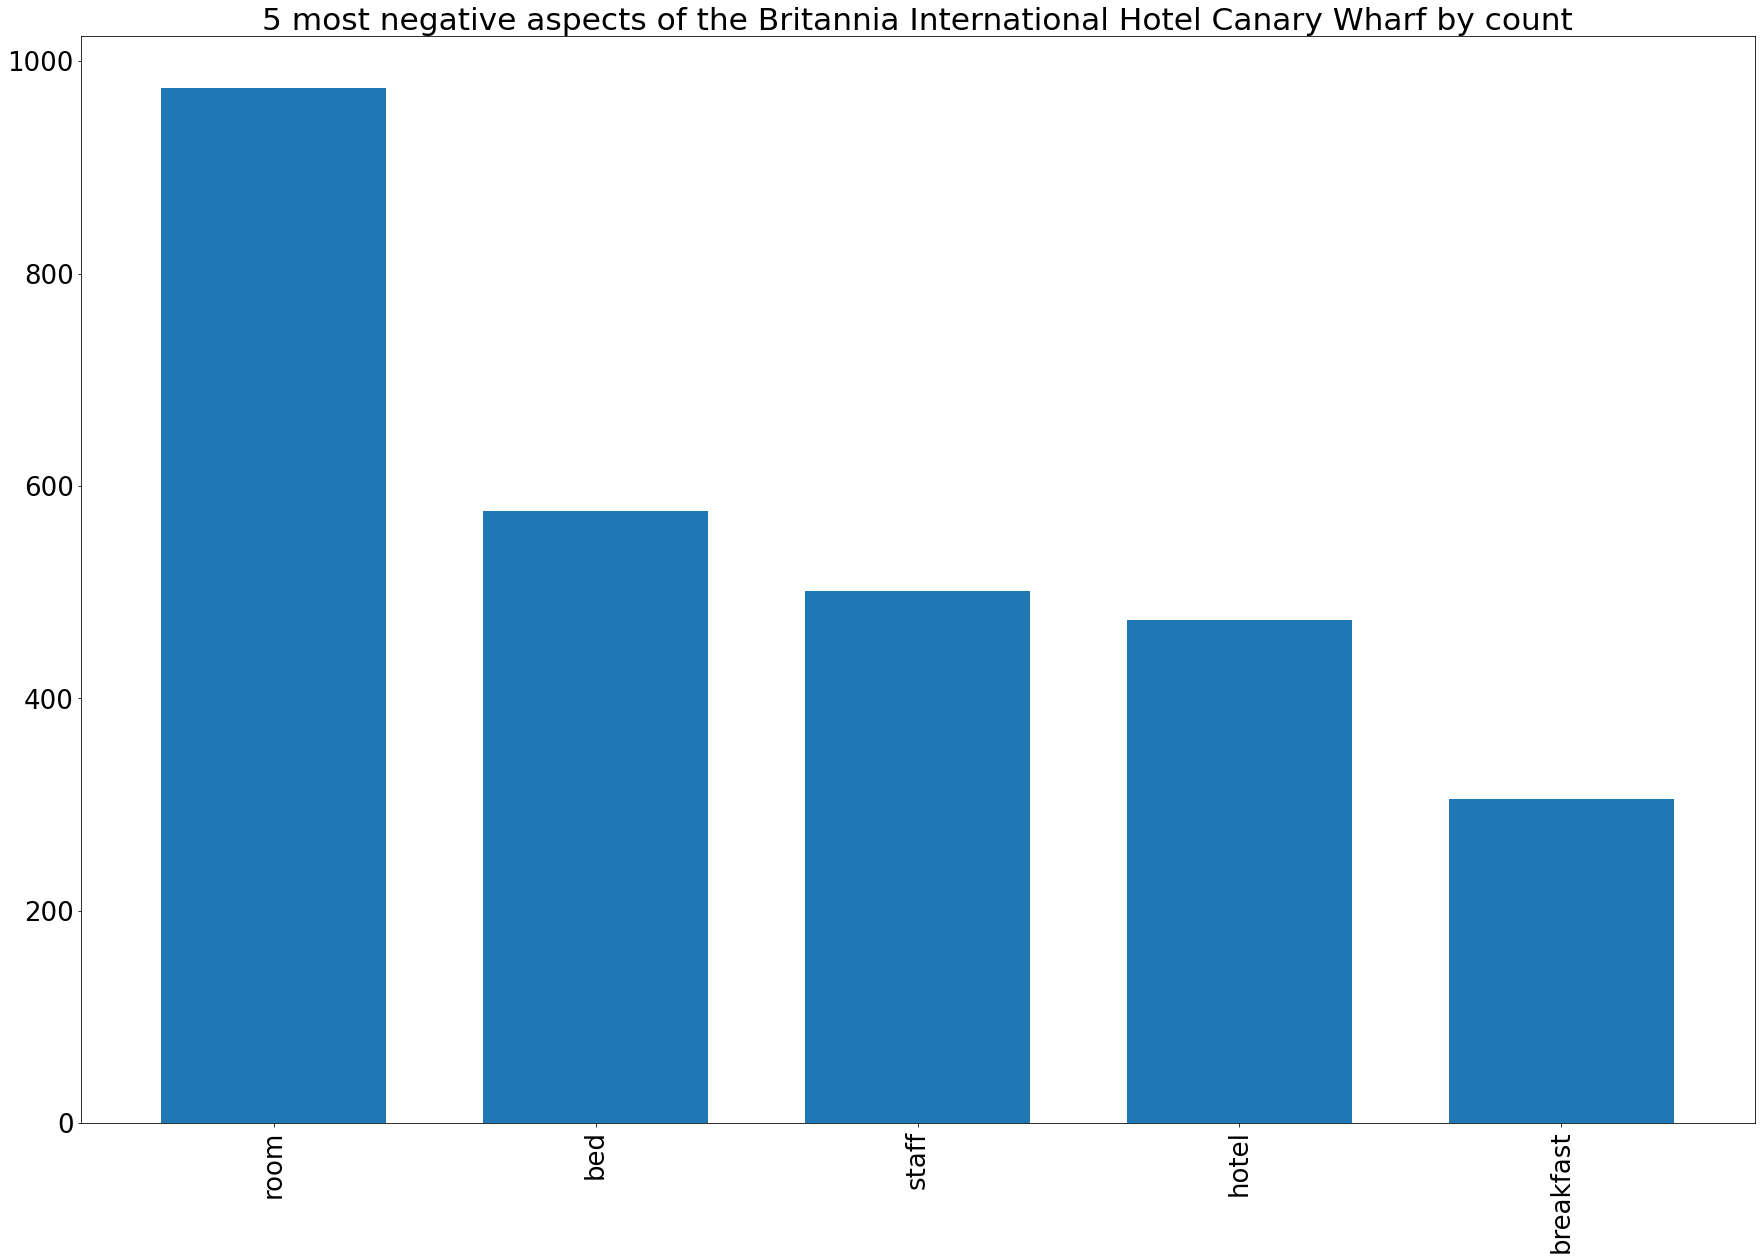

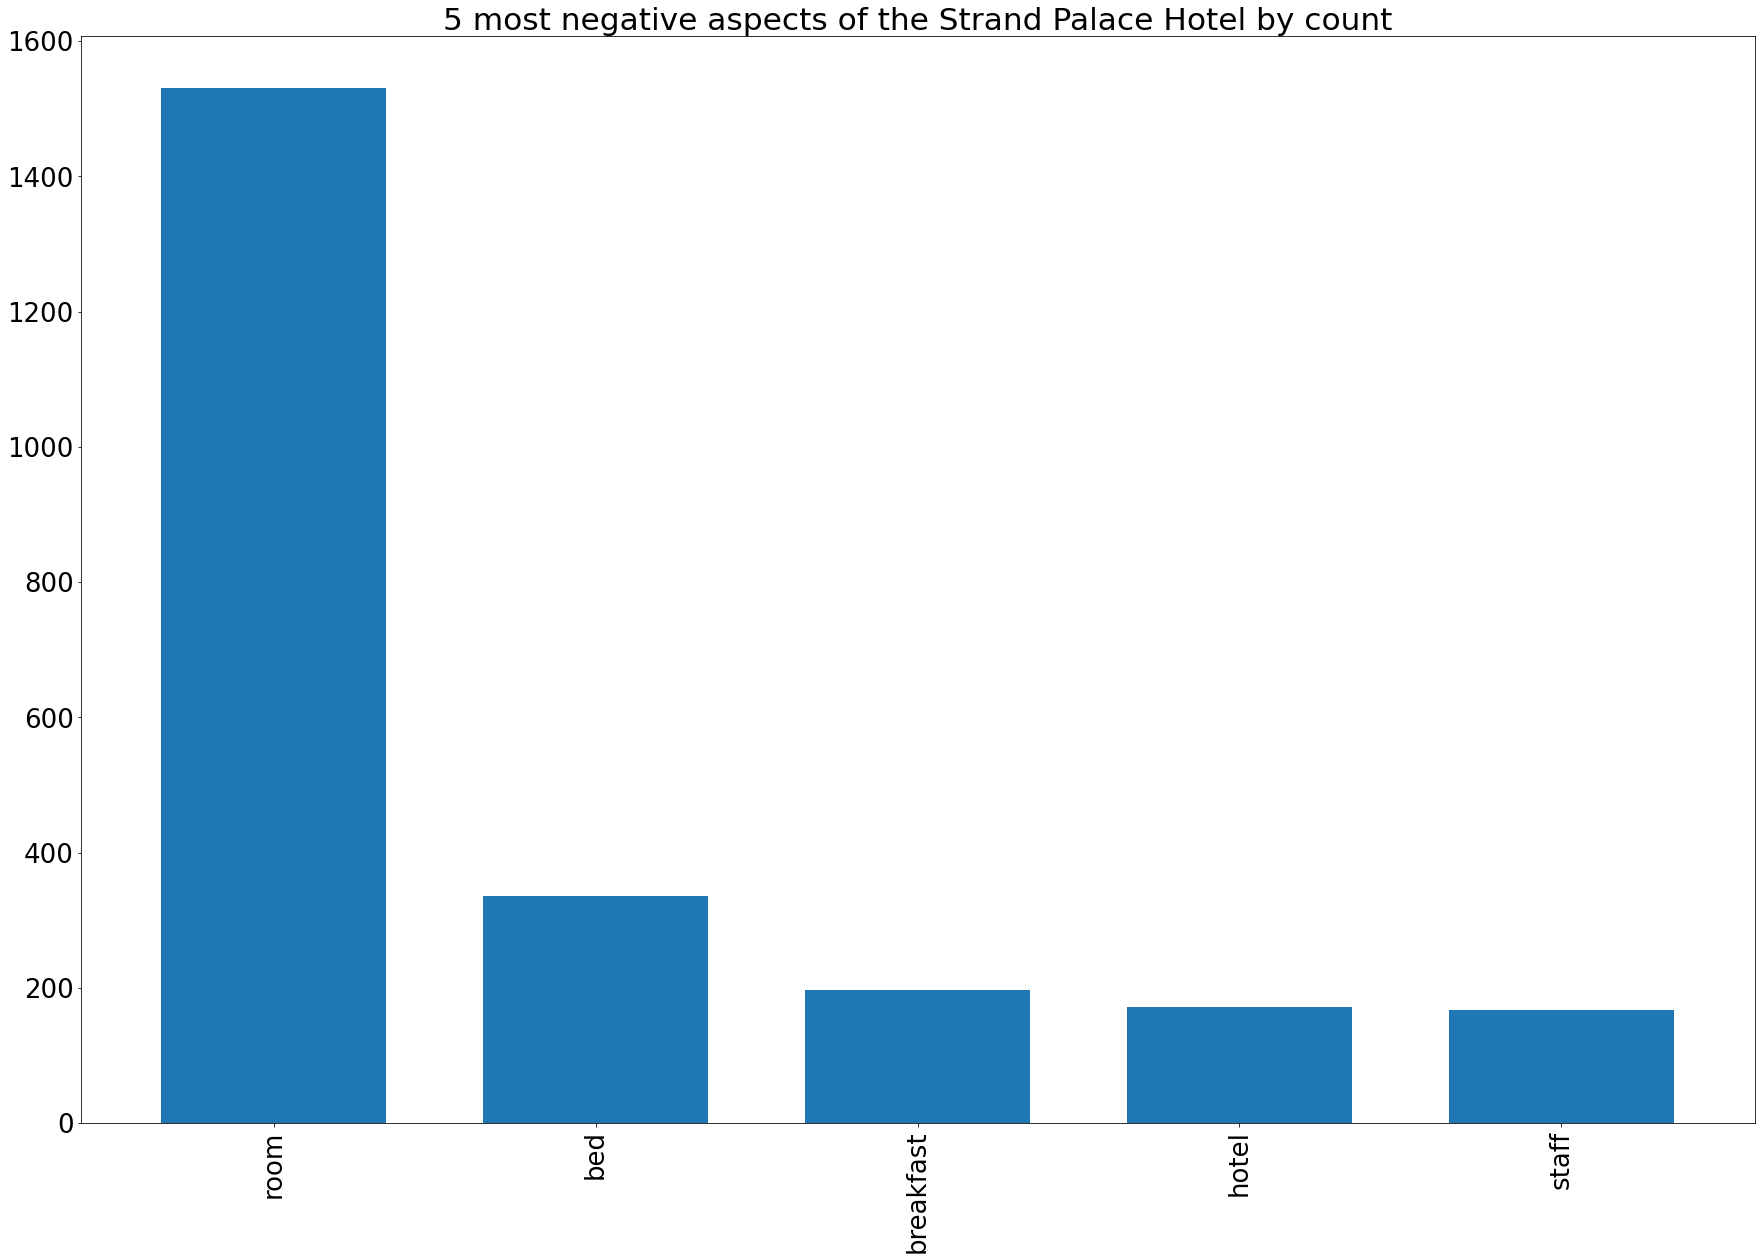

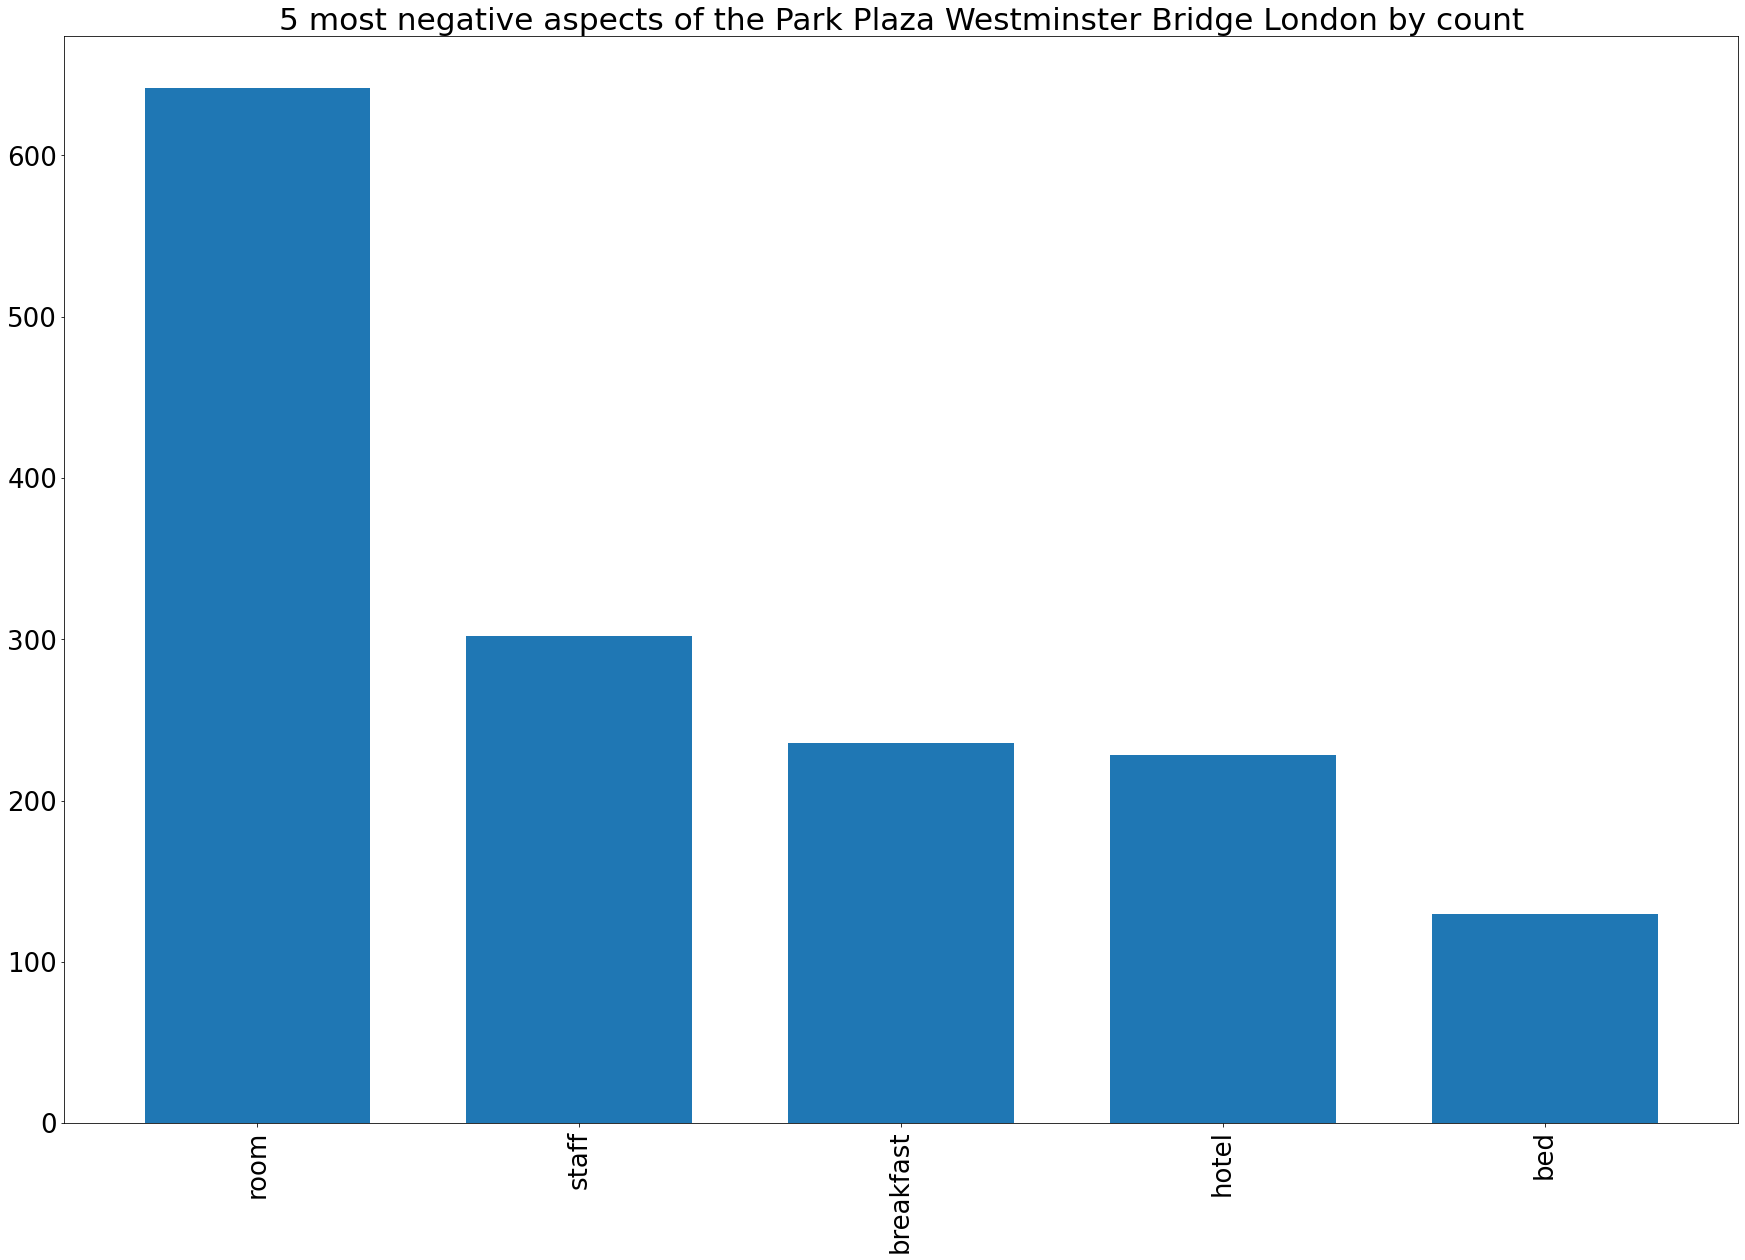

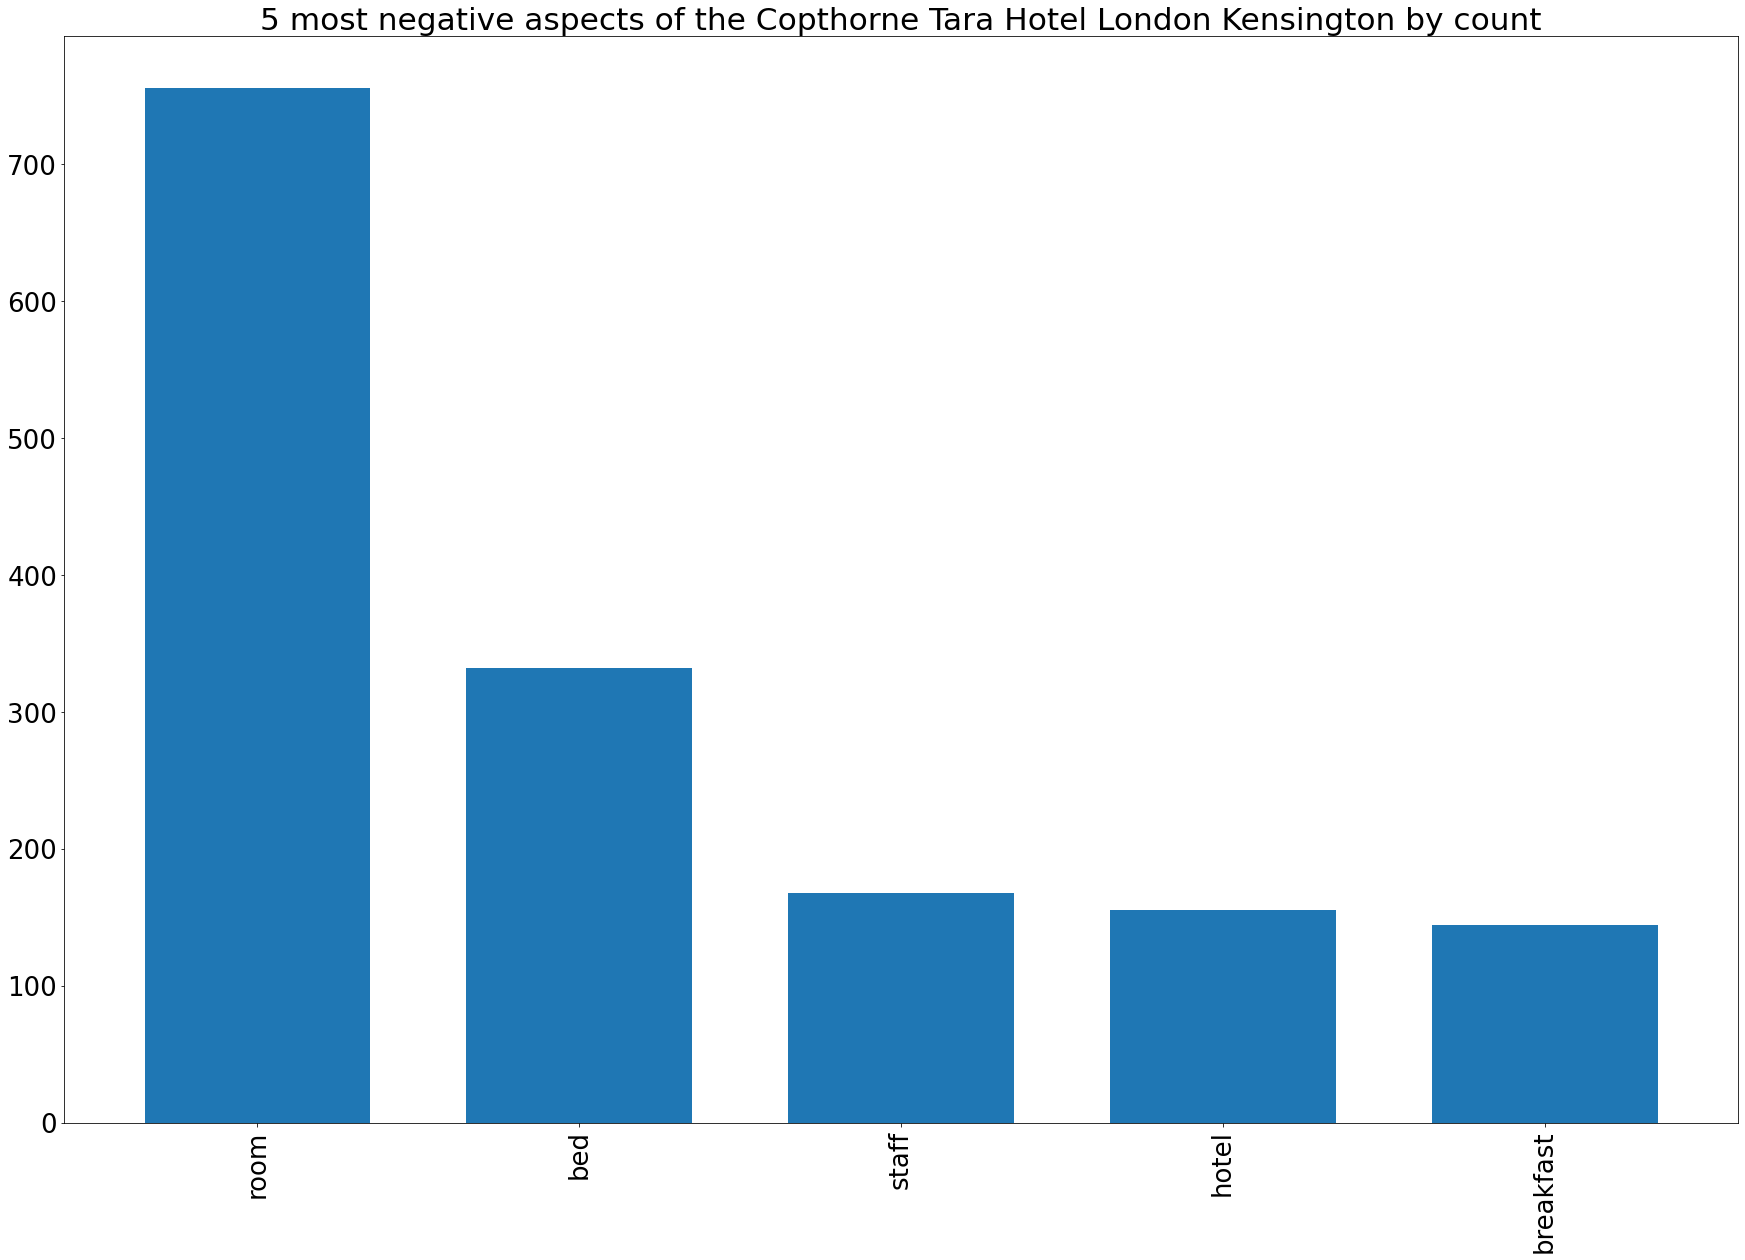

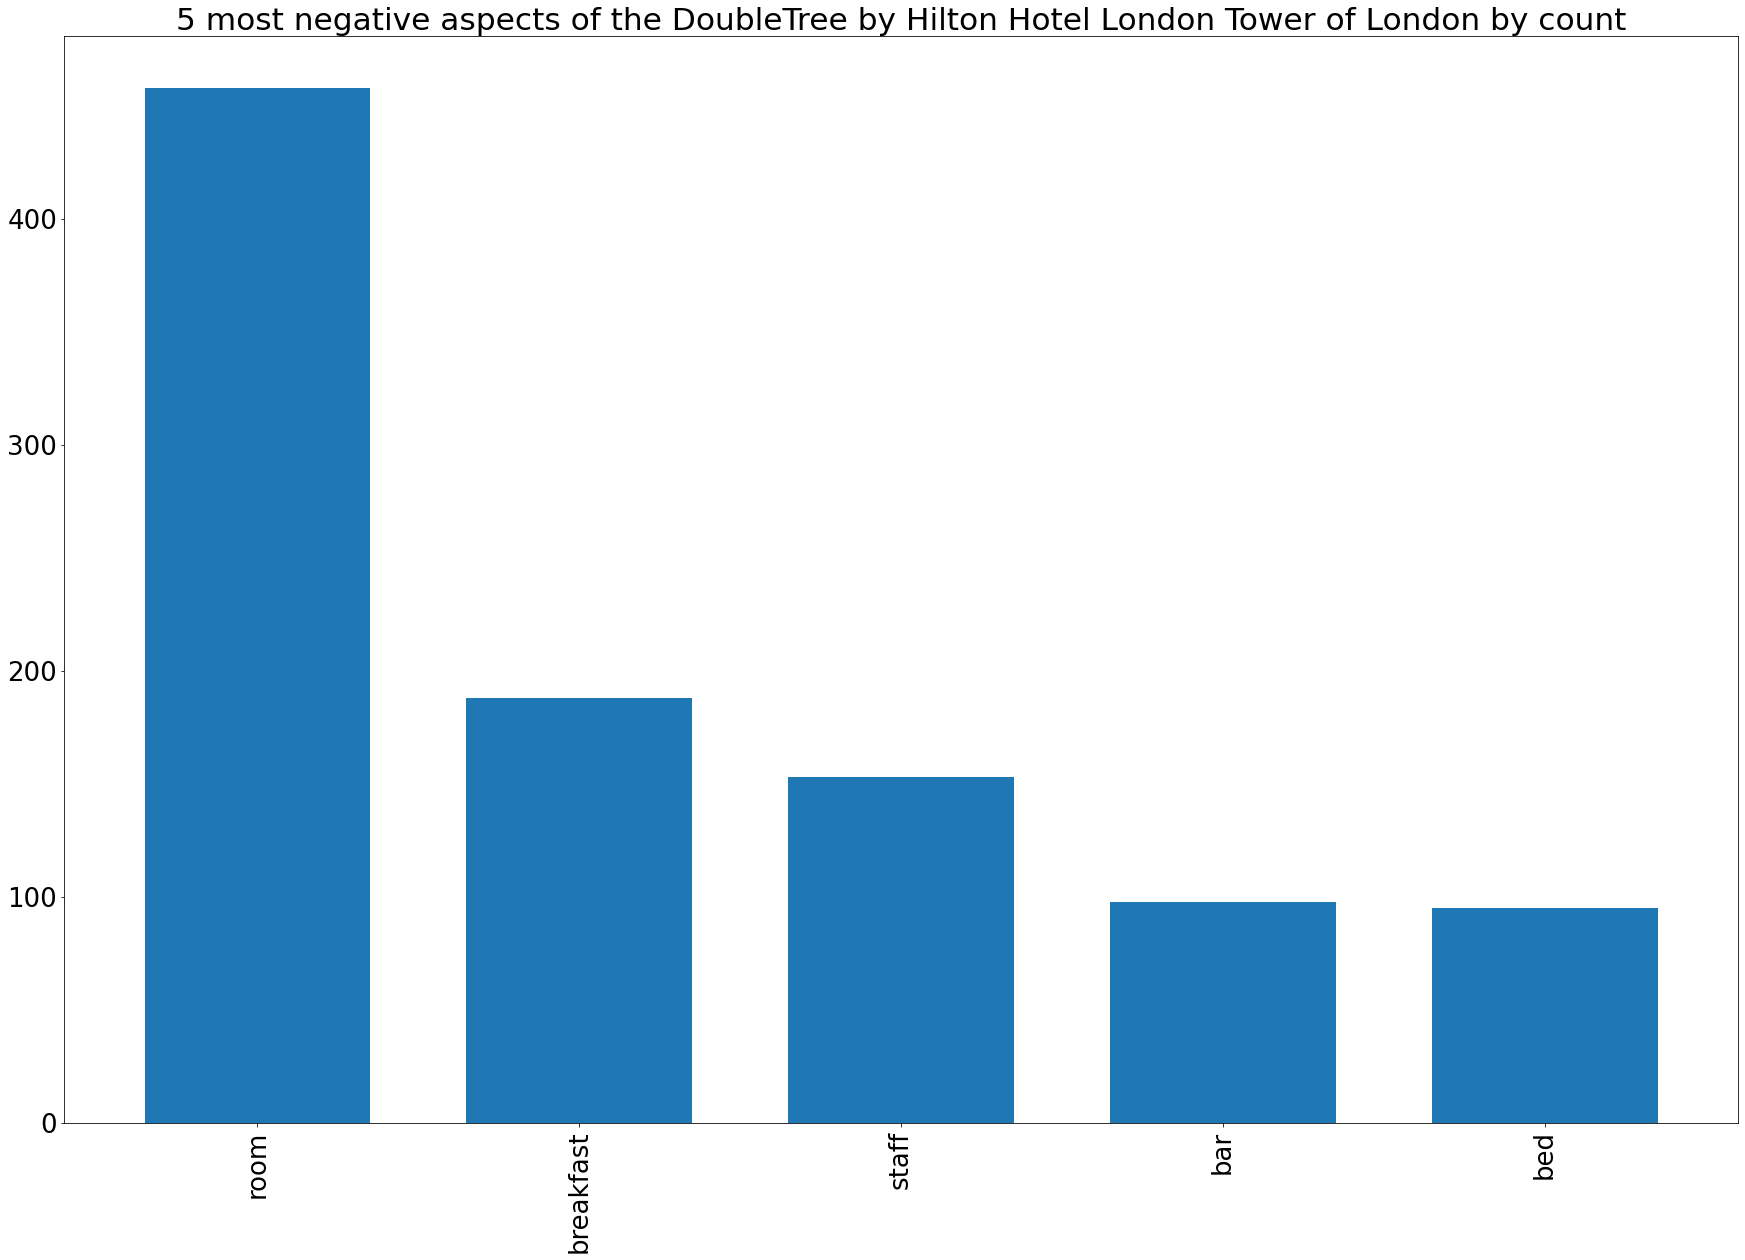

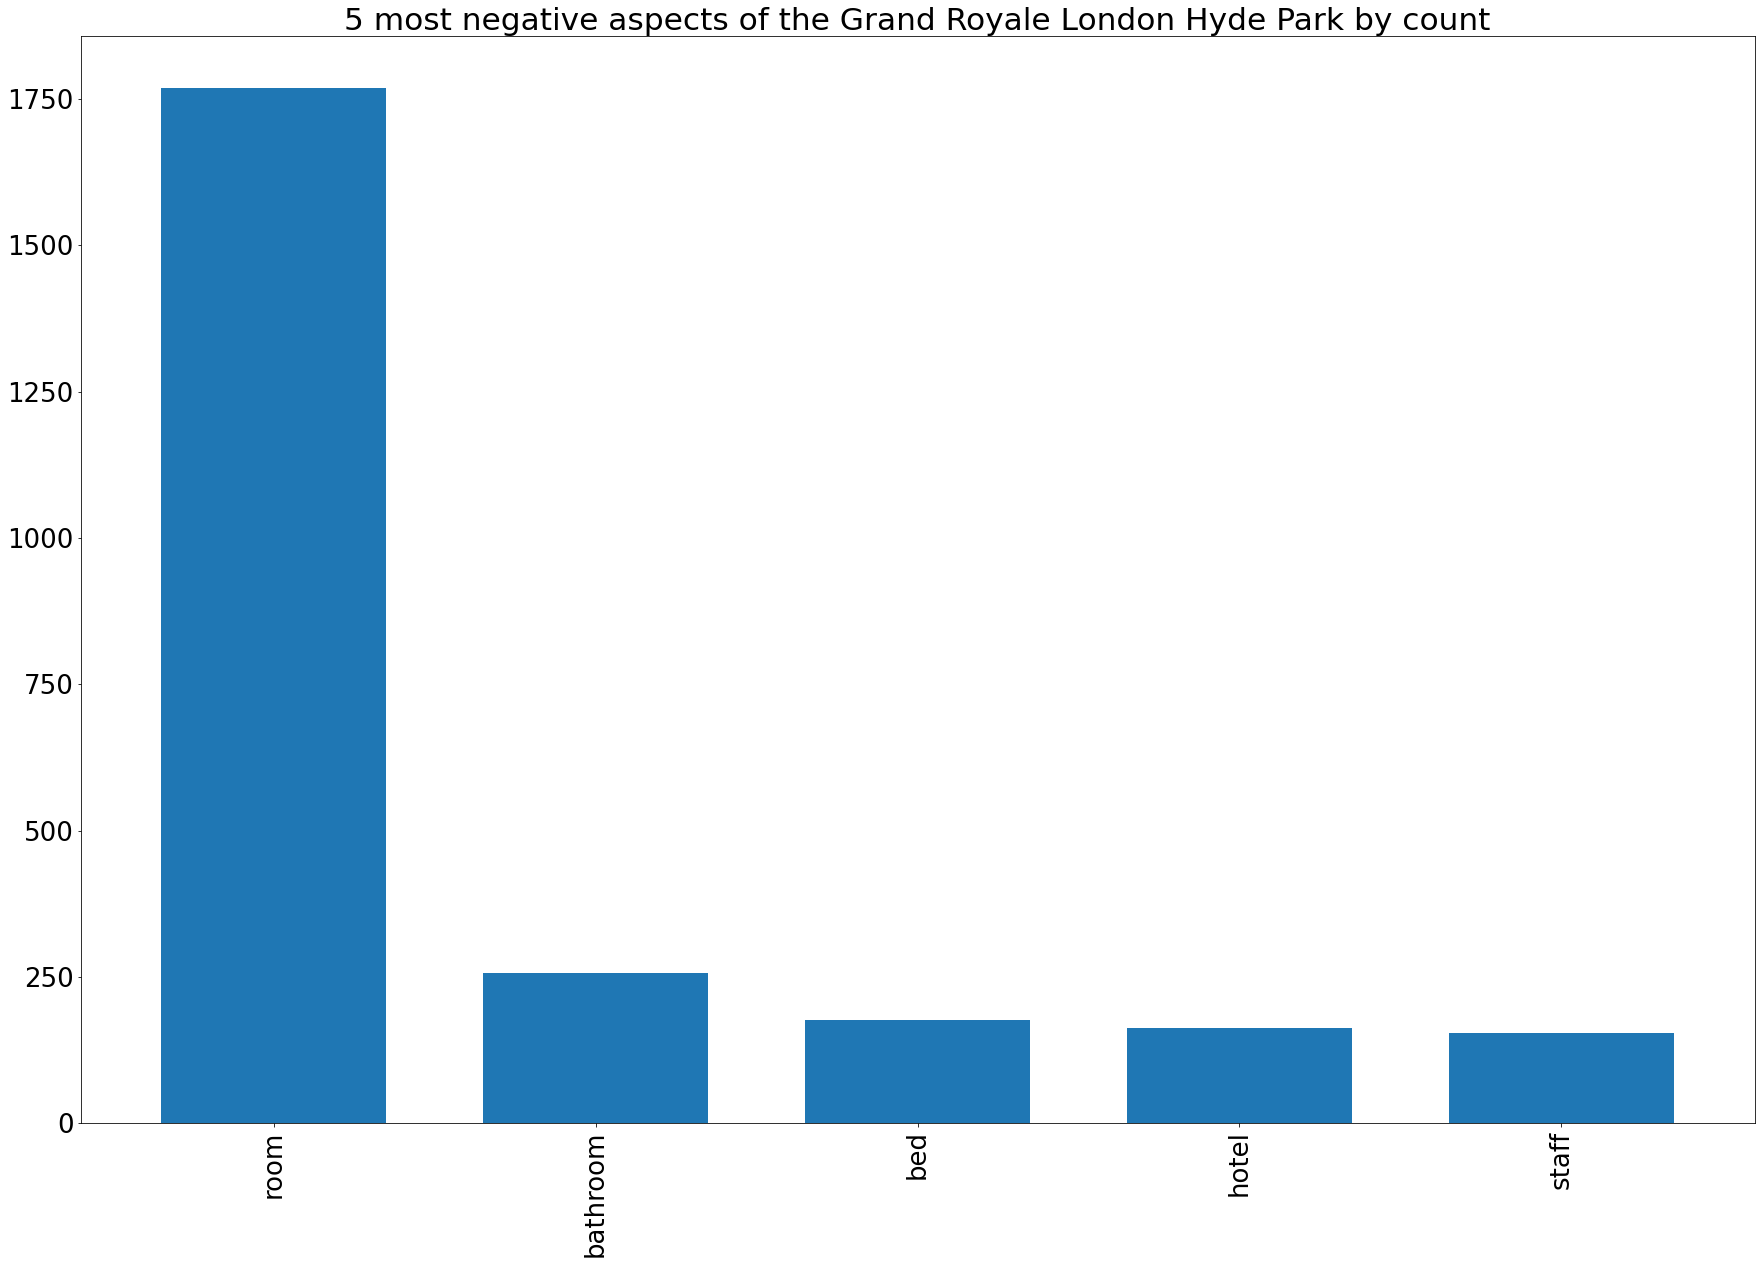

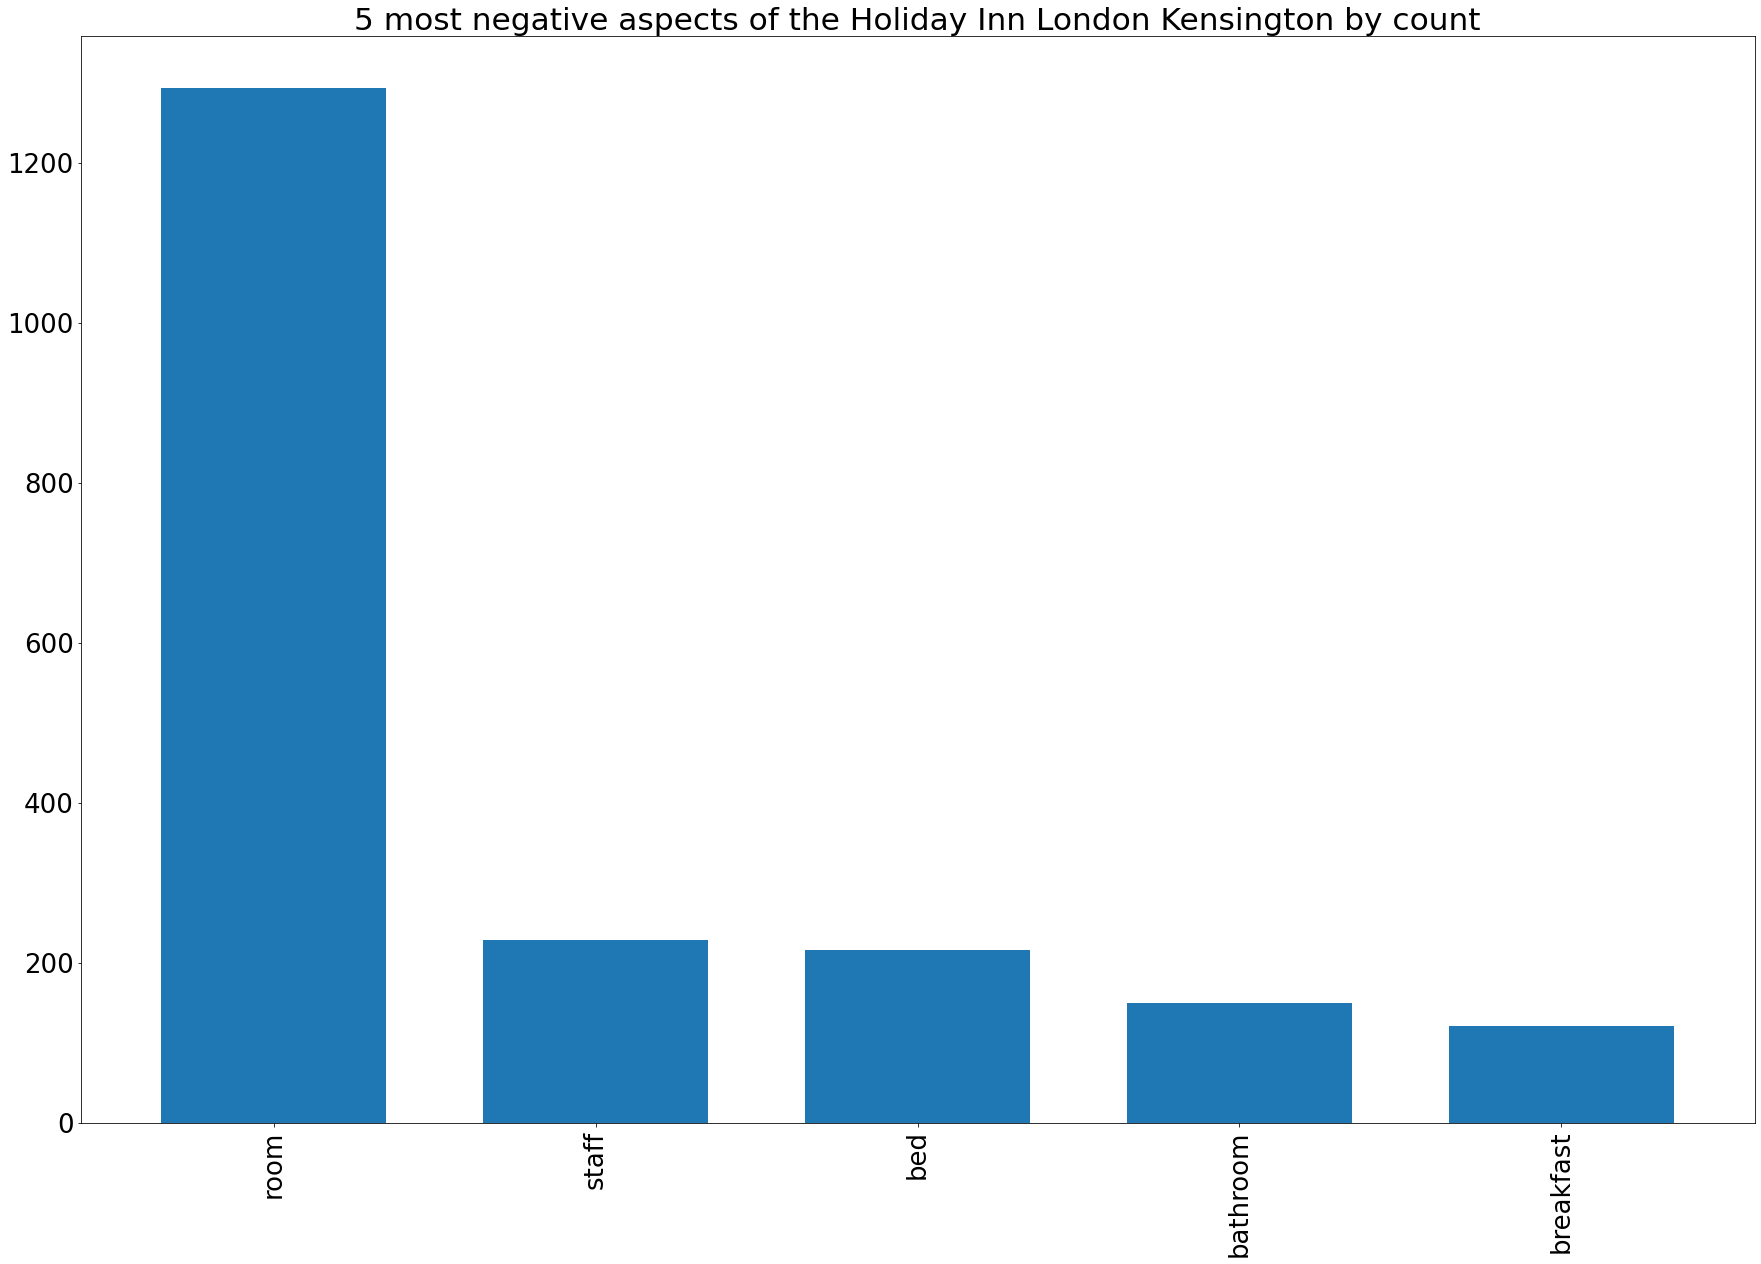

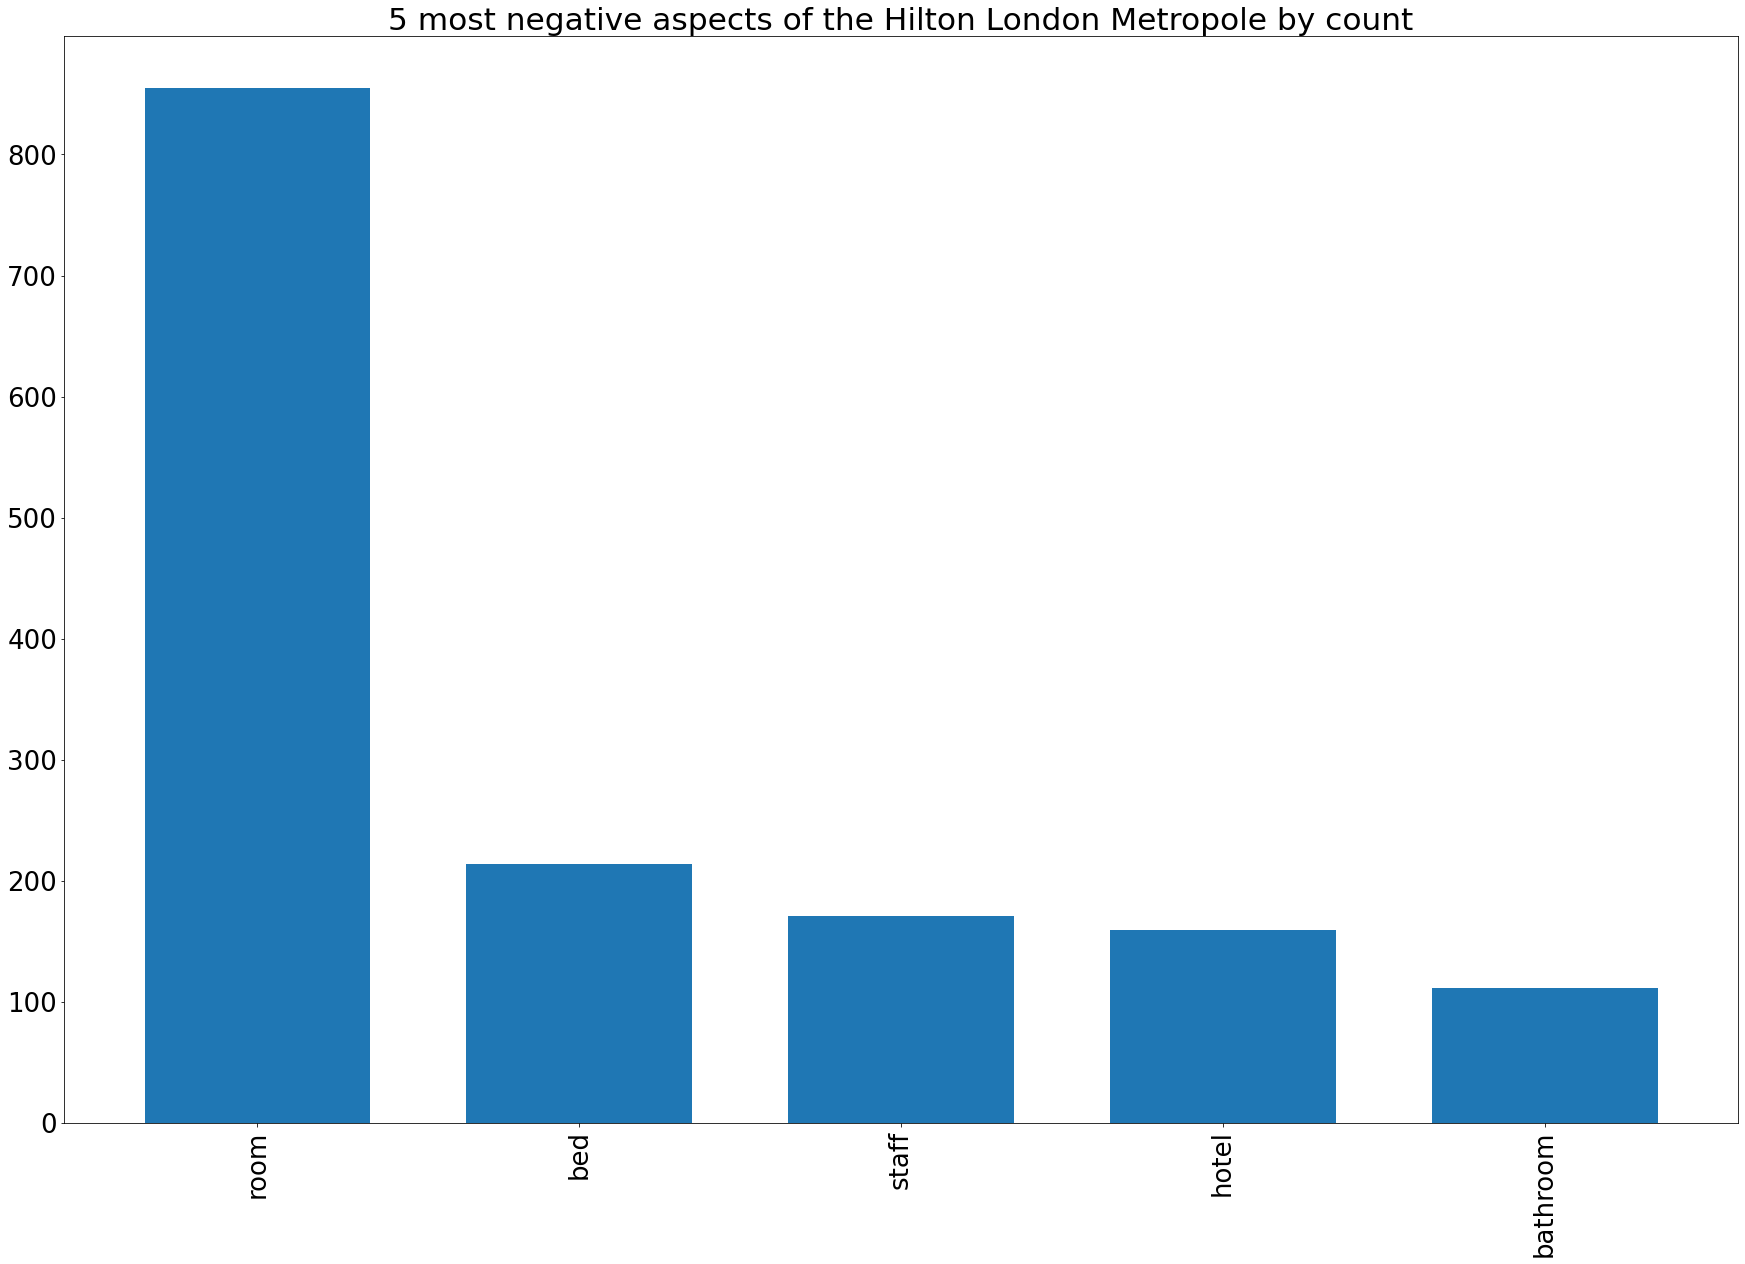

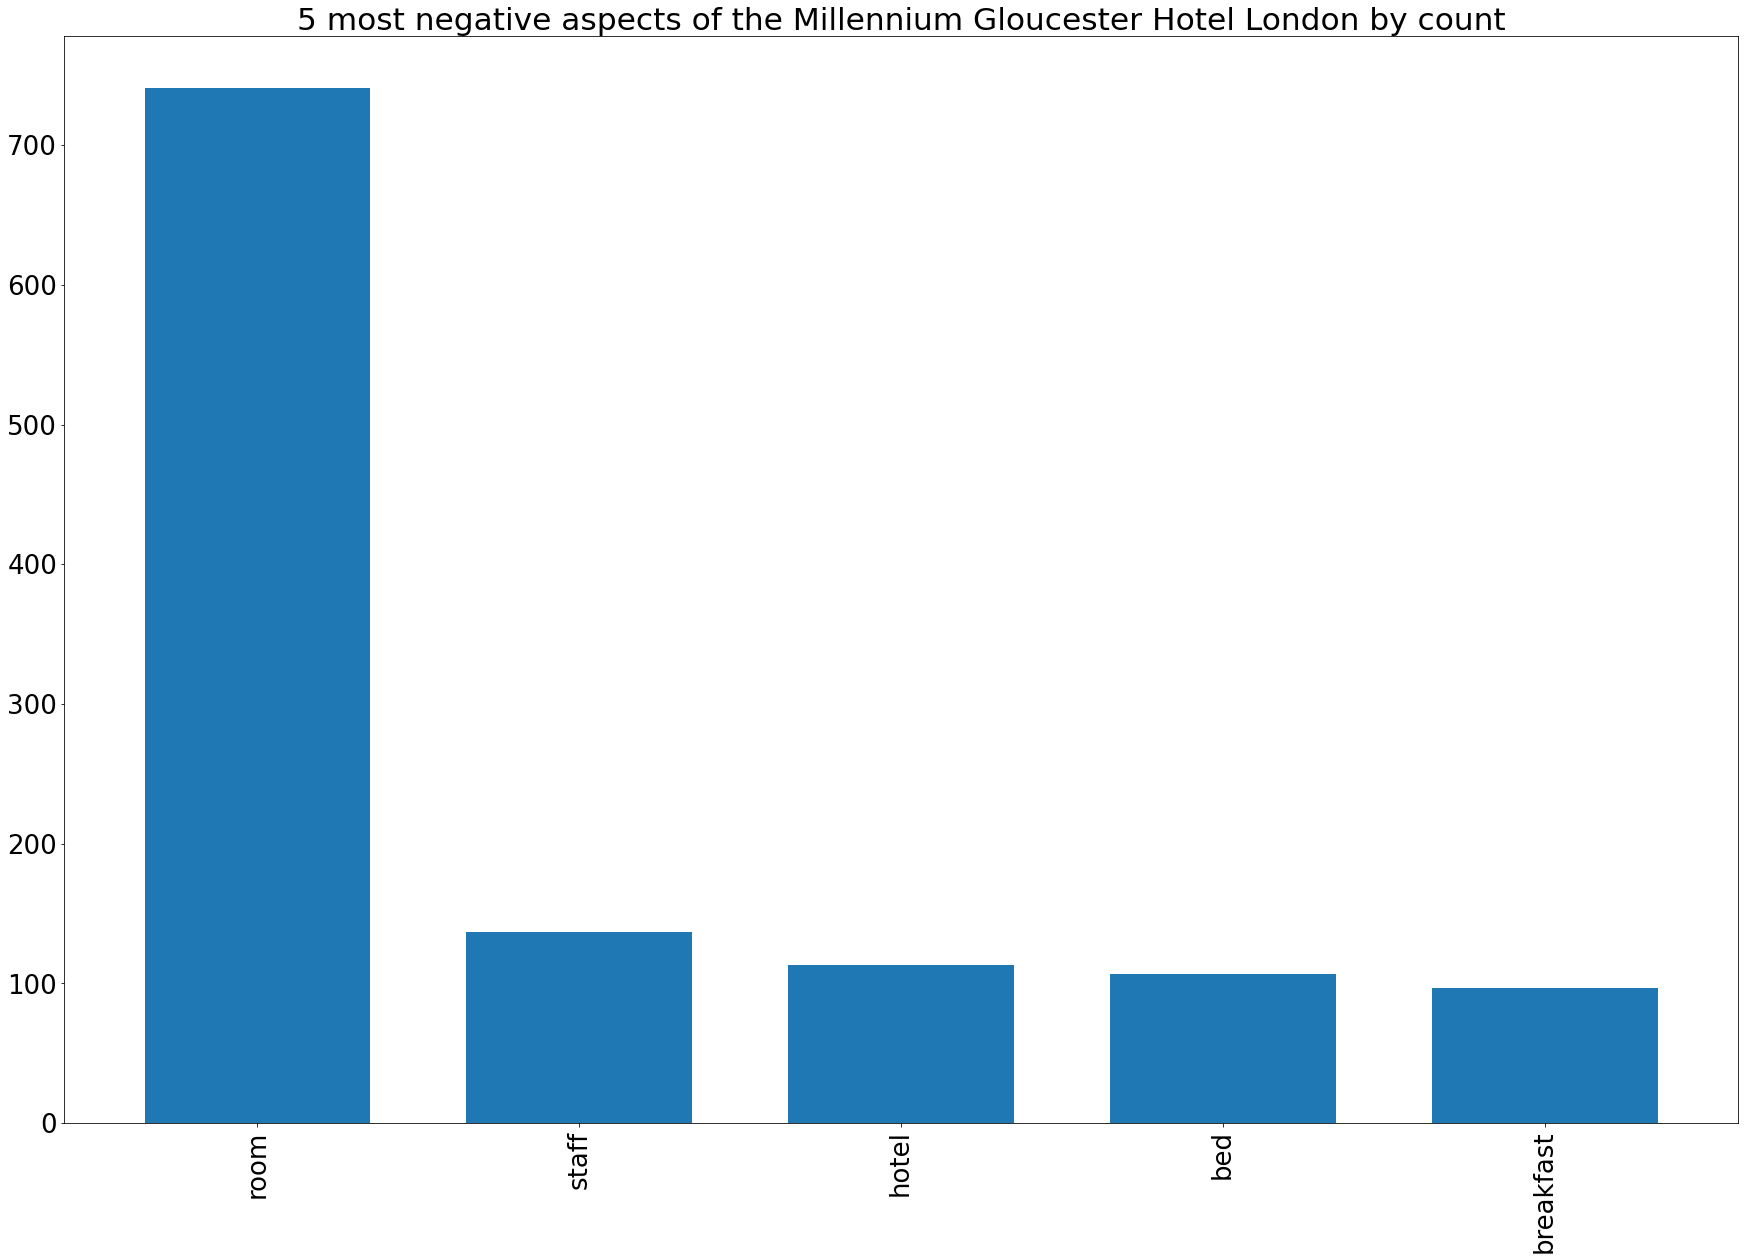

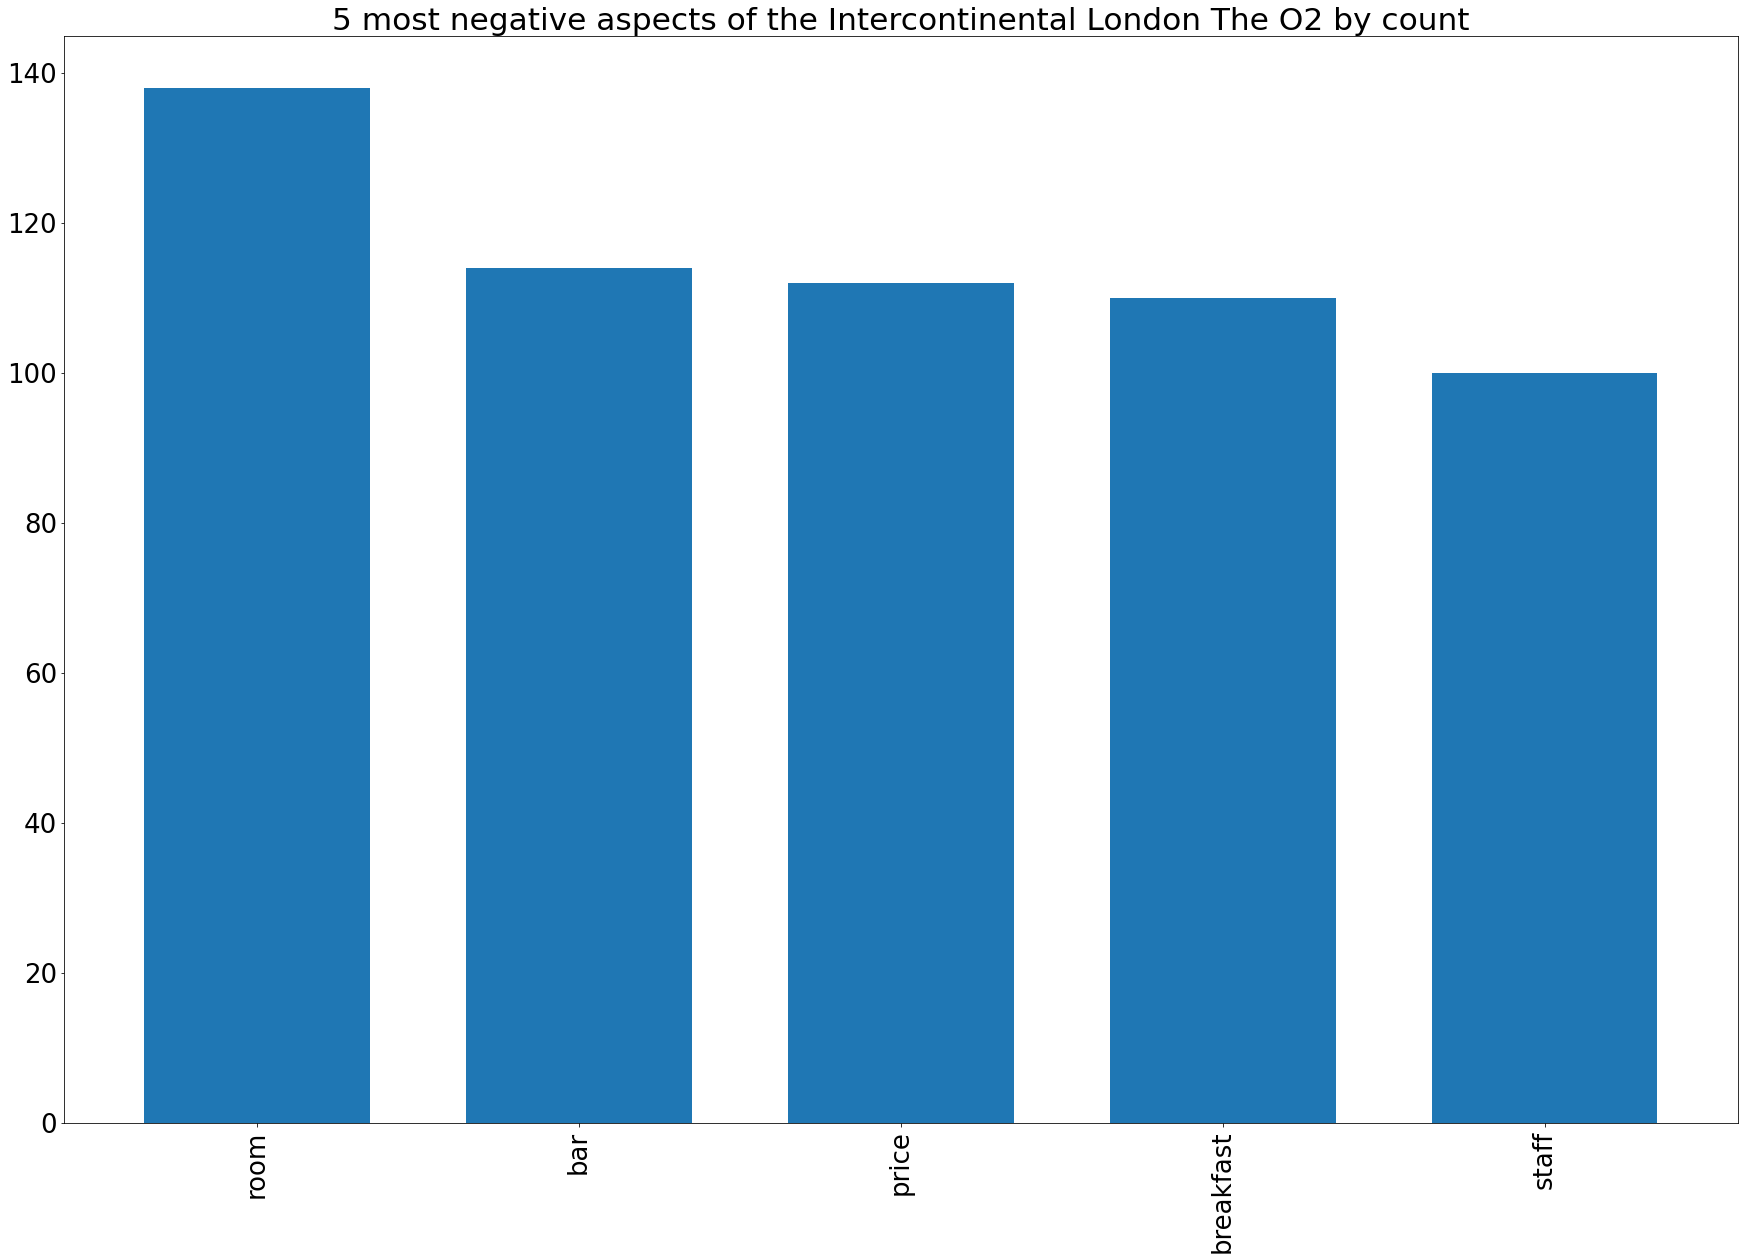

In [294]:
path = strPath[0:len(strPath)-5] + '/output/' 

# this gets us the five most commonly negative mentioned aspects per hotel
for name, aspectsTotal, cleanedAspectsPos, countAllAspectsPos, fiveMostCommonPos,  cleanedAspectsNeg, countAllAspectsNeg, fiveMostCommonNeg, sentRoom, sentProperty,  sentFood, sentLocation, sentStaff, sentNationality, sentNegSelf, sentPosSelf  in data.values:
    figName = "fiveNeg" + name + ".pdf"
    df = pd.DataFrame([asp[1] for asp in fiveMostCommonNeg], index=[asp[0] for asp in fiveMostCommonNeg]) #, index = [' staff', ' food', ' location', ' room', ' property']
    plt.rcParams.update({'font.size': 26}) 
    df.plot(kind='bar', legend=False, width=.7, figsize=(30,20))
    plt.title("5 most negative aspects of the " + name + " by count")
    plt.savefig(path + figName)
    #plt.show()

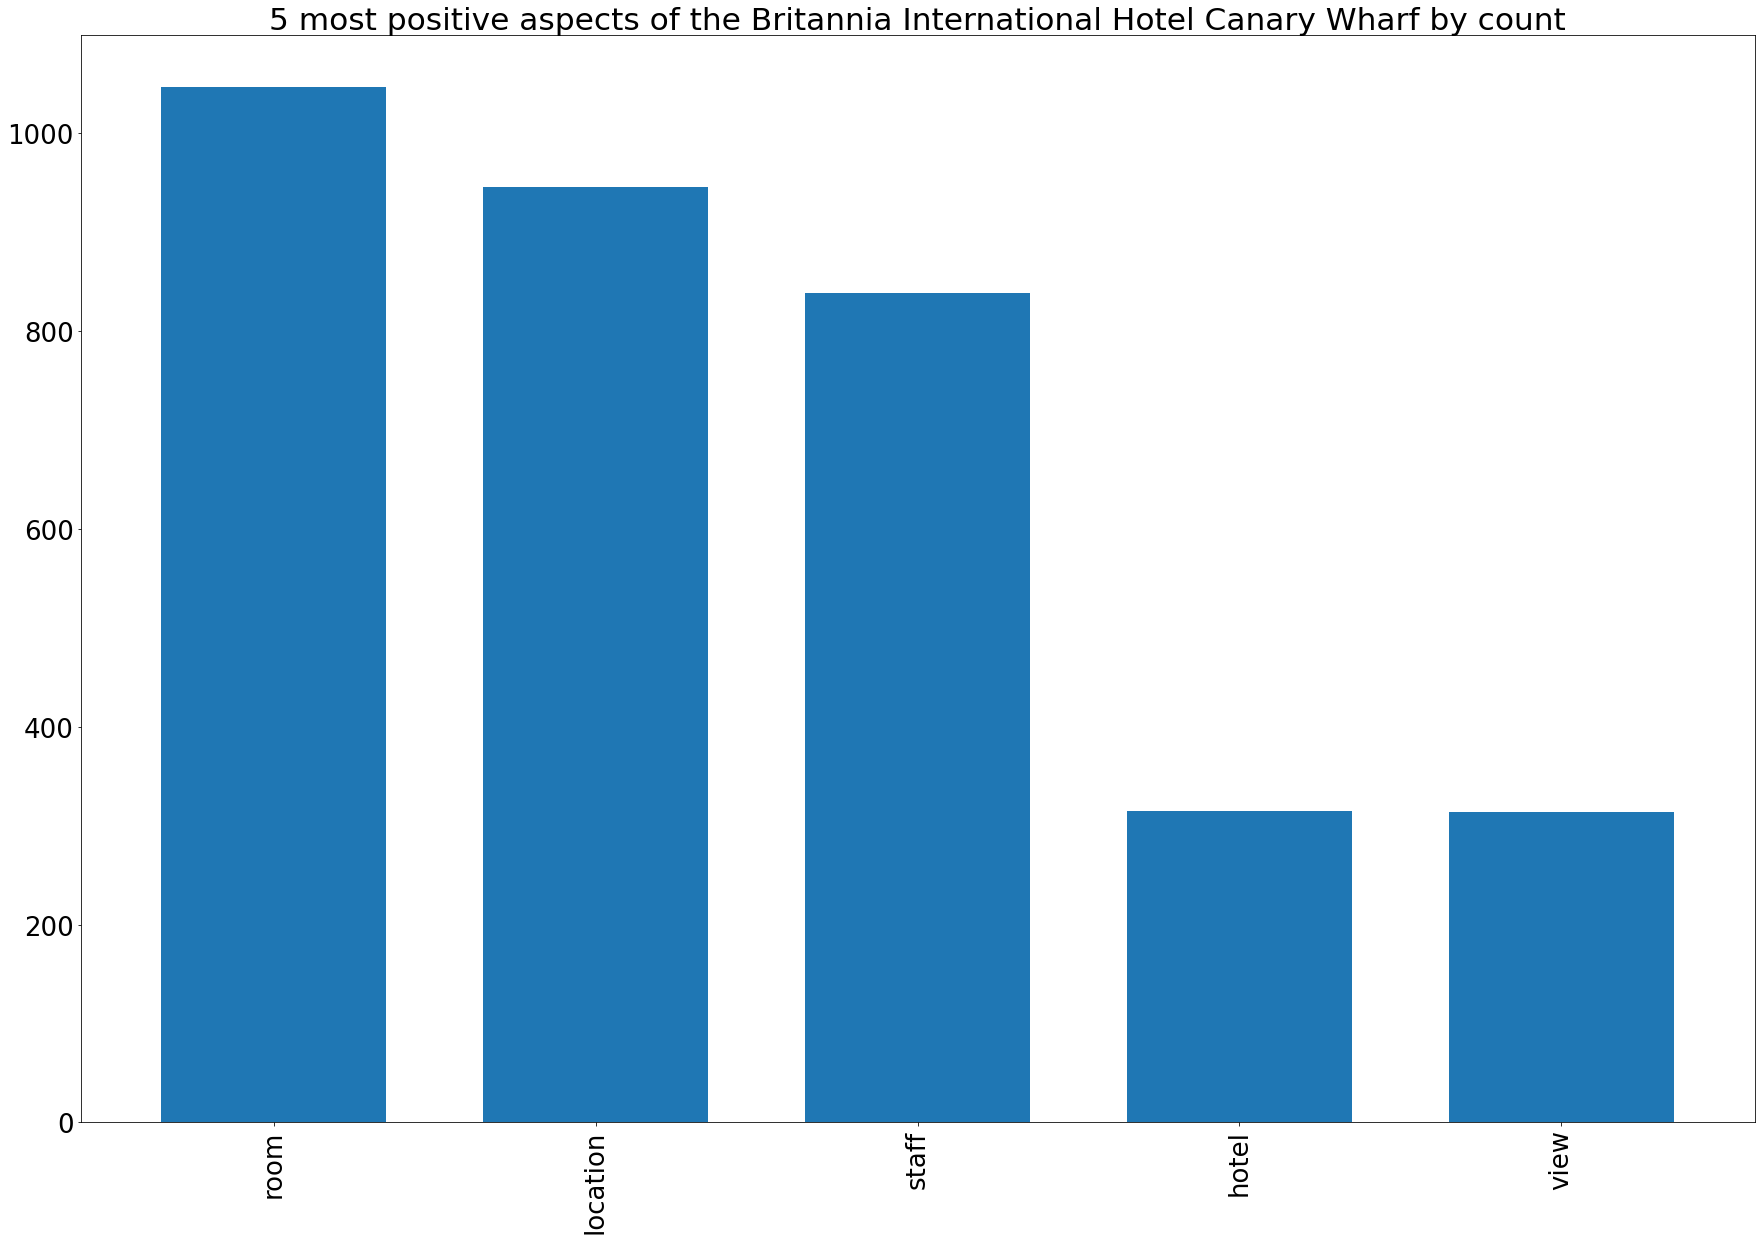

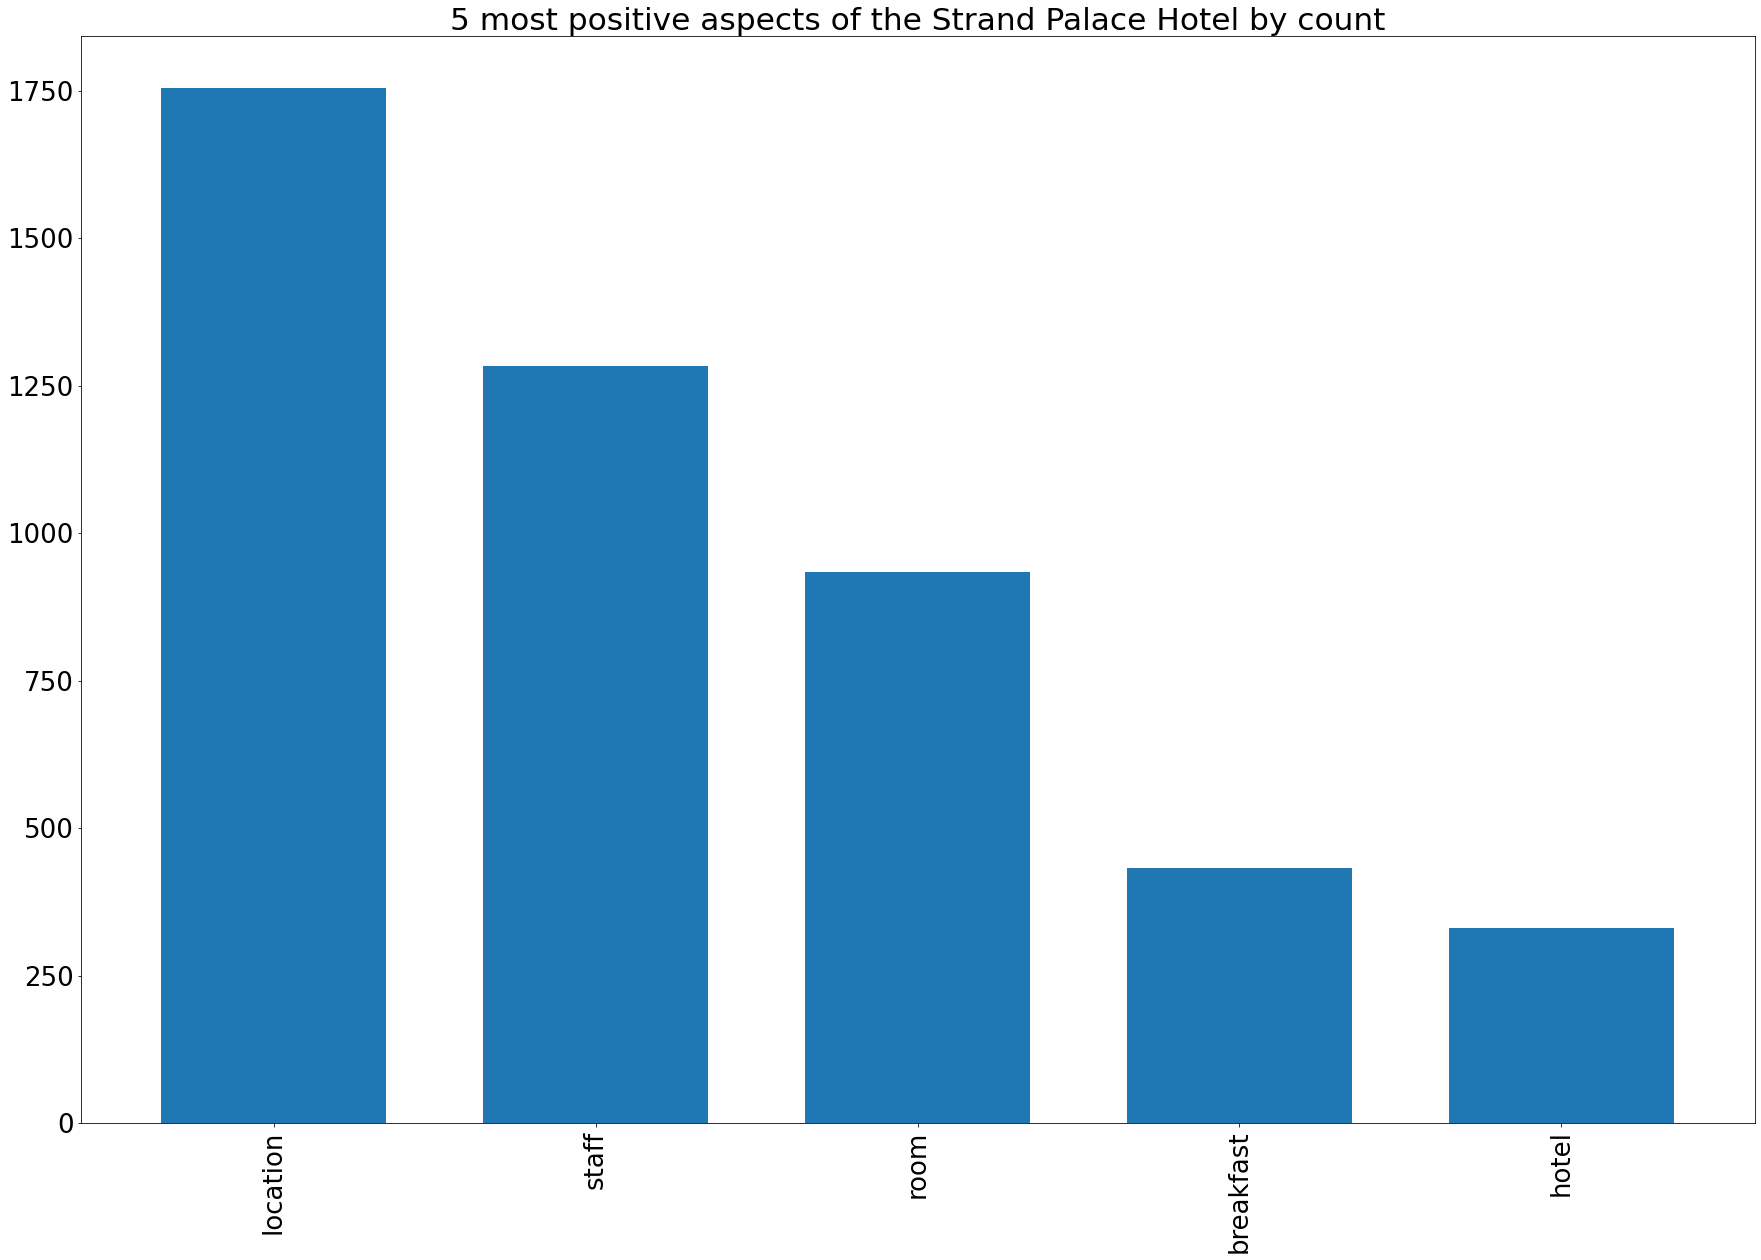

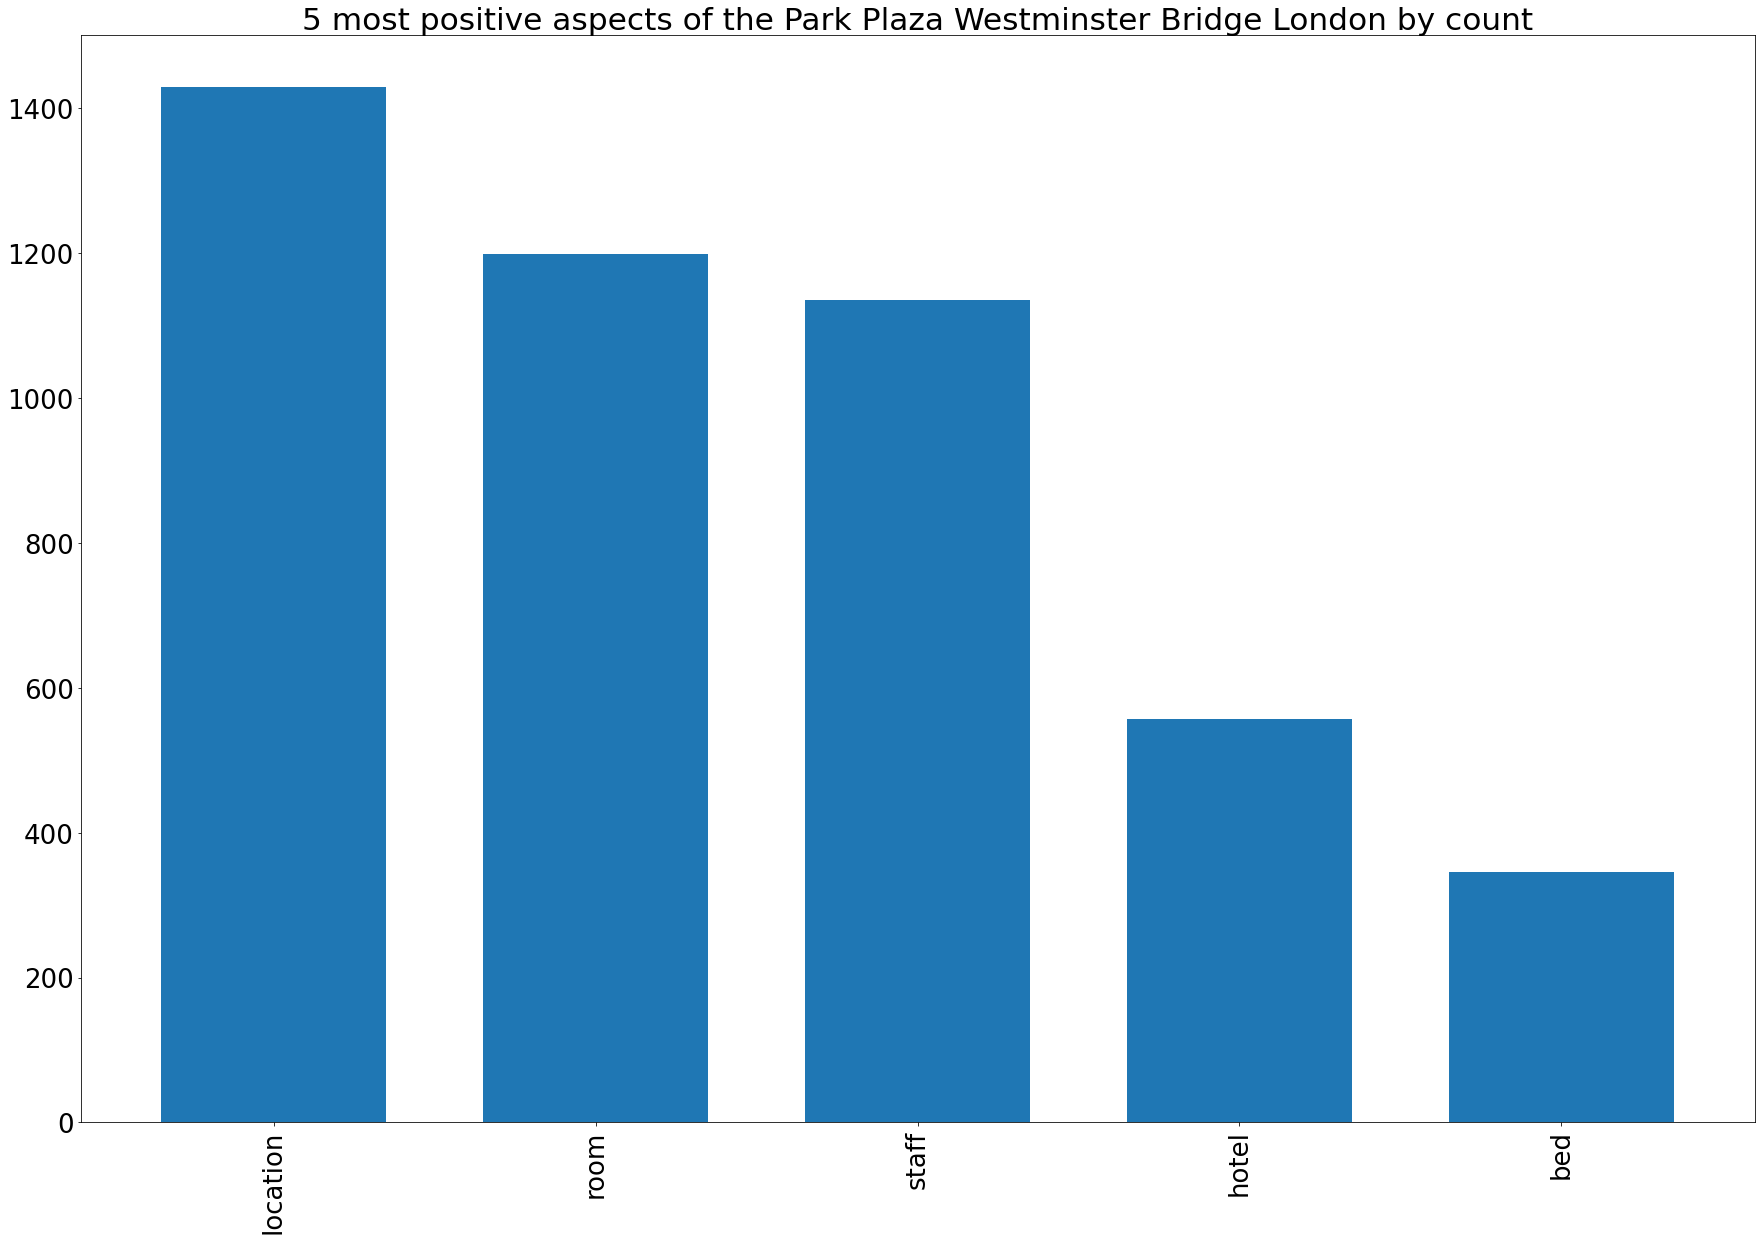

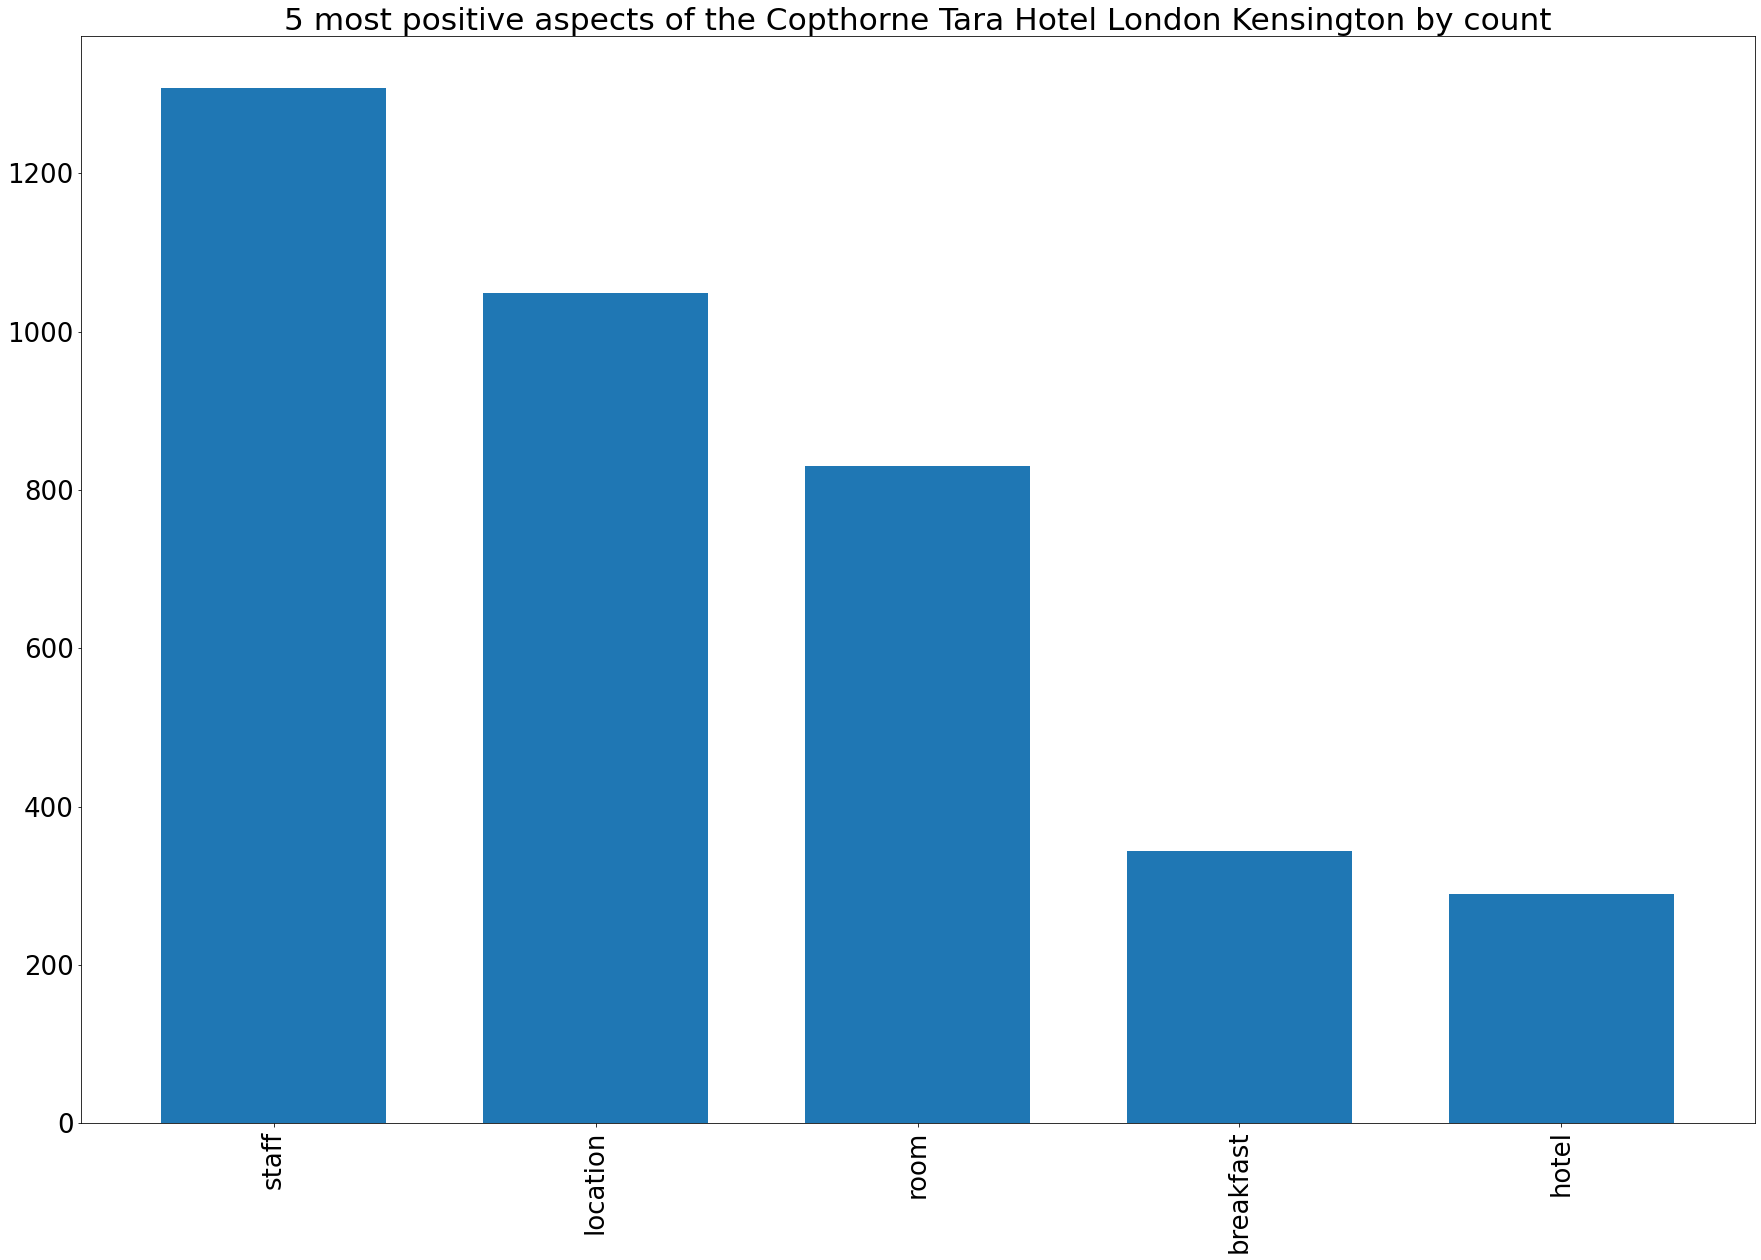

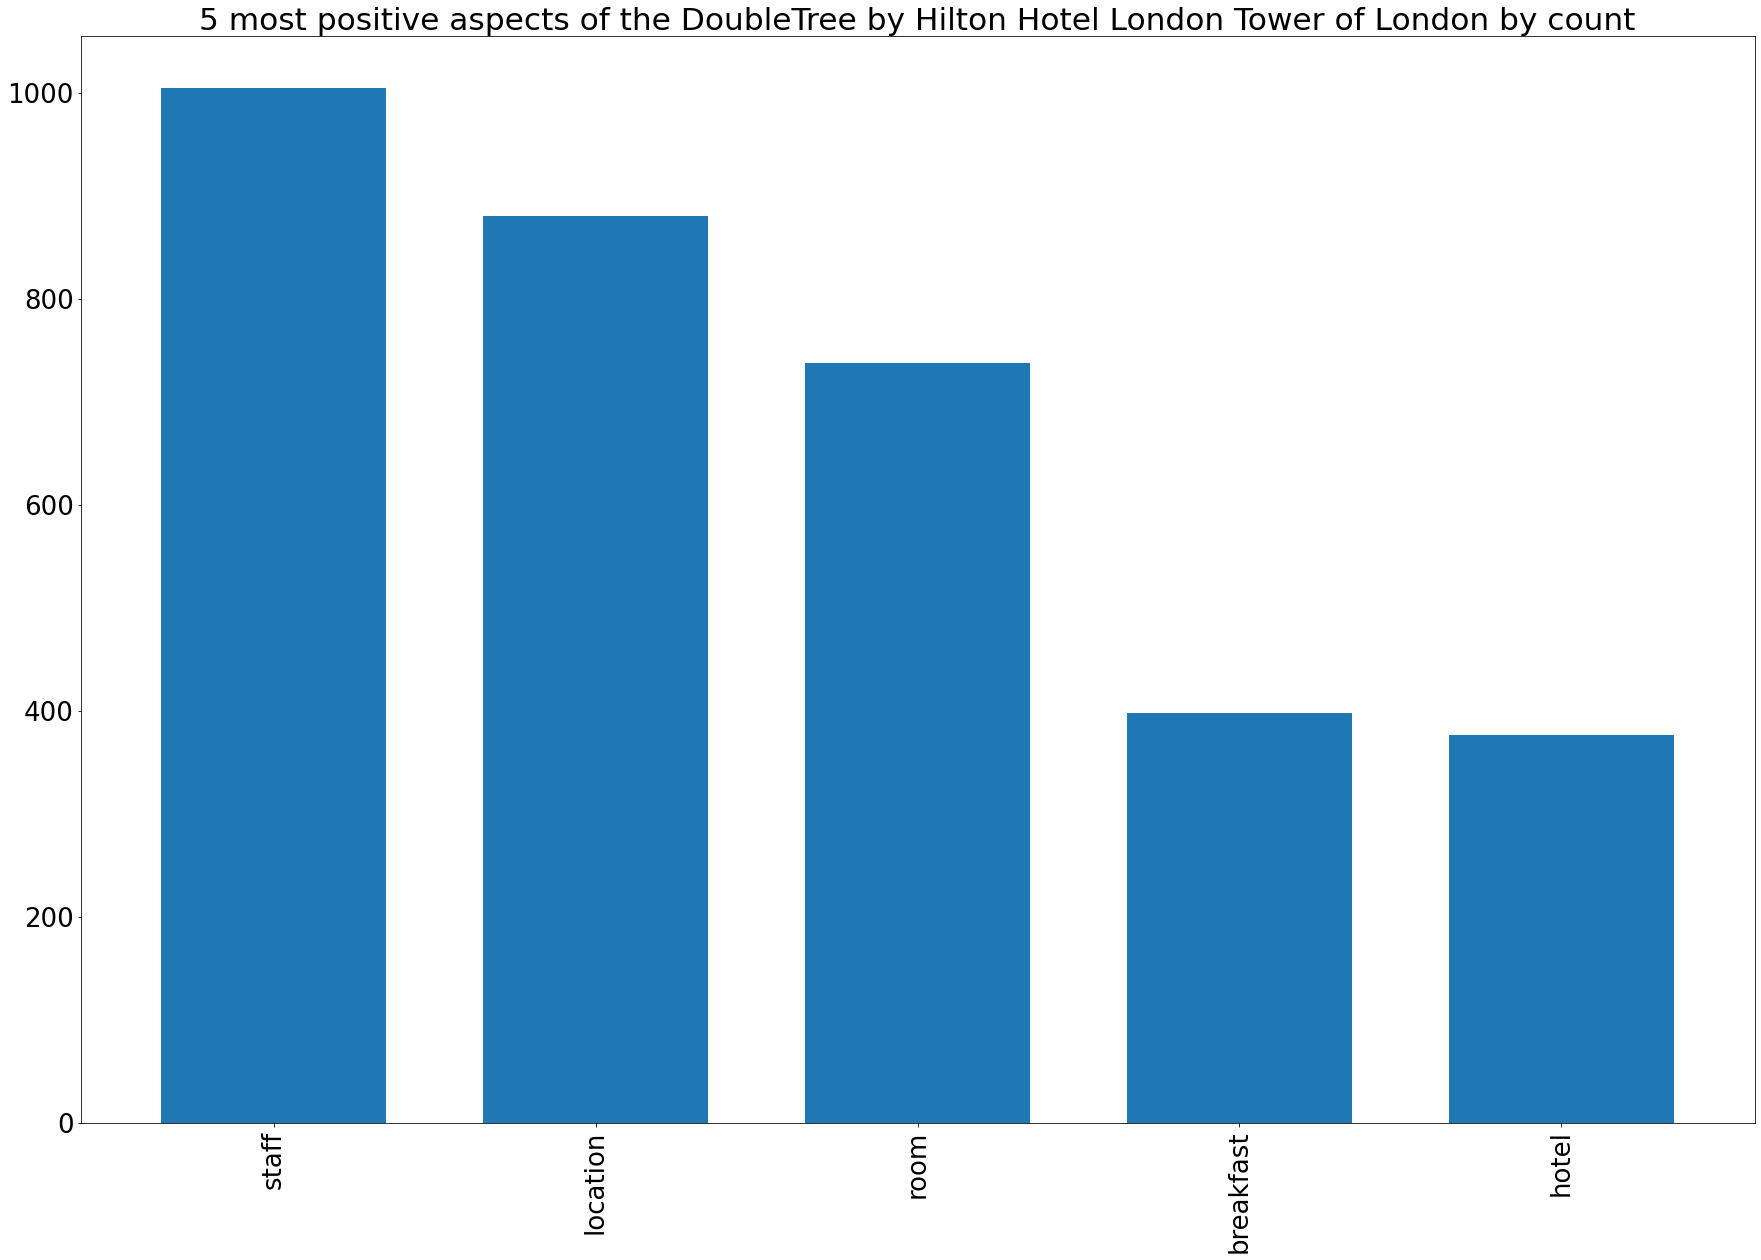

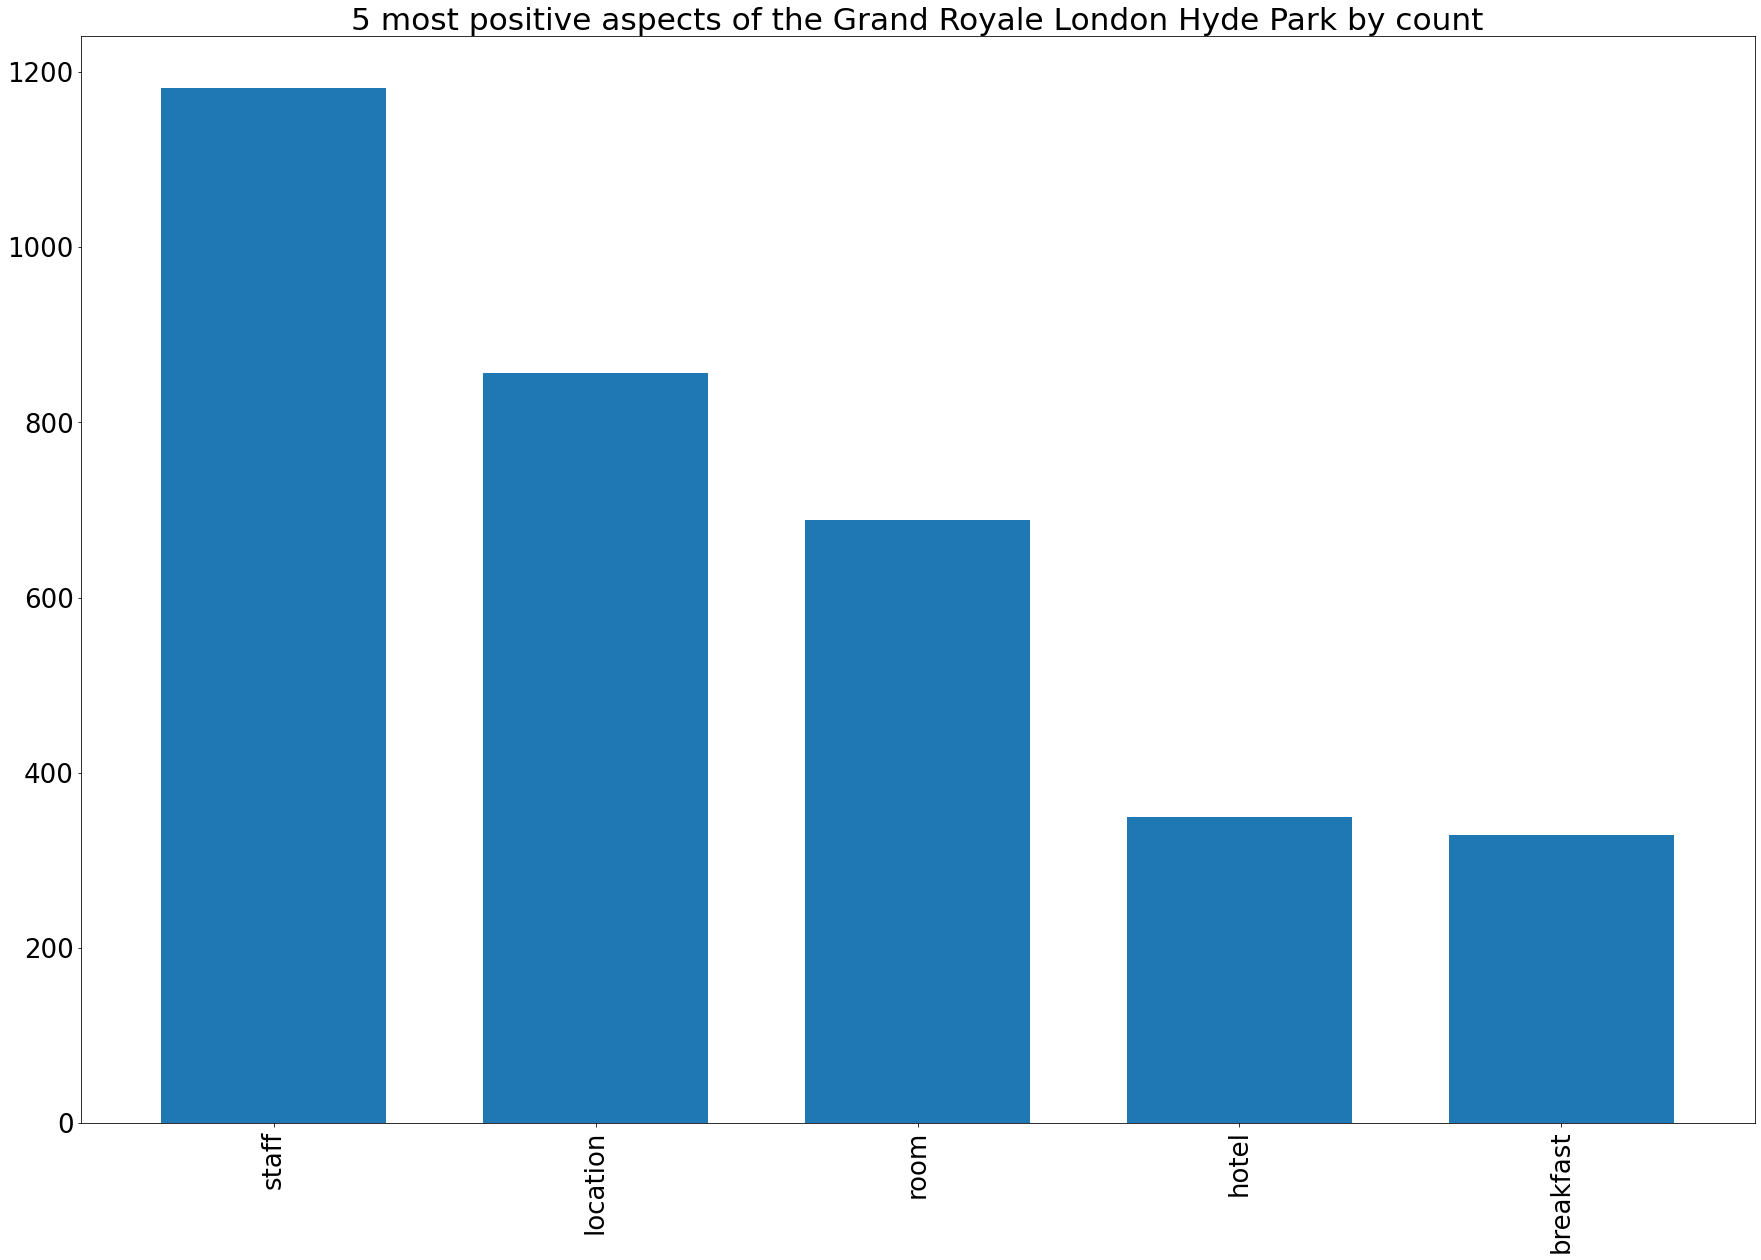

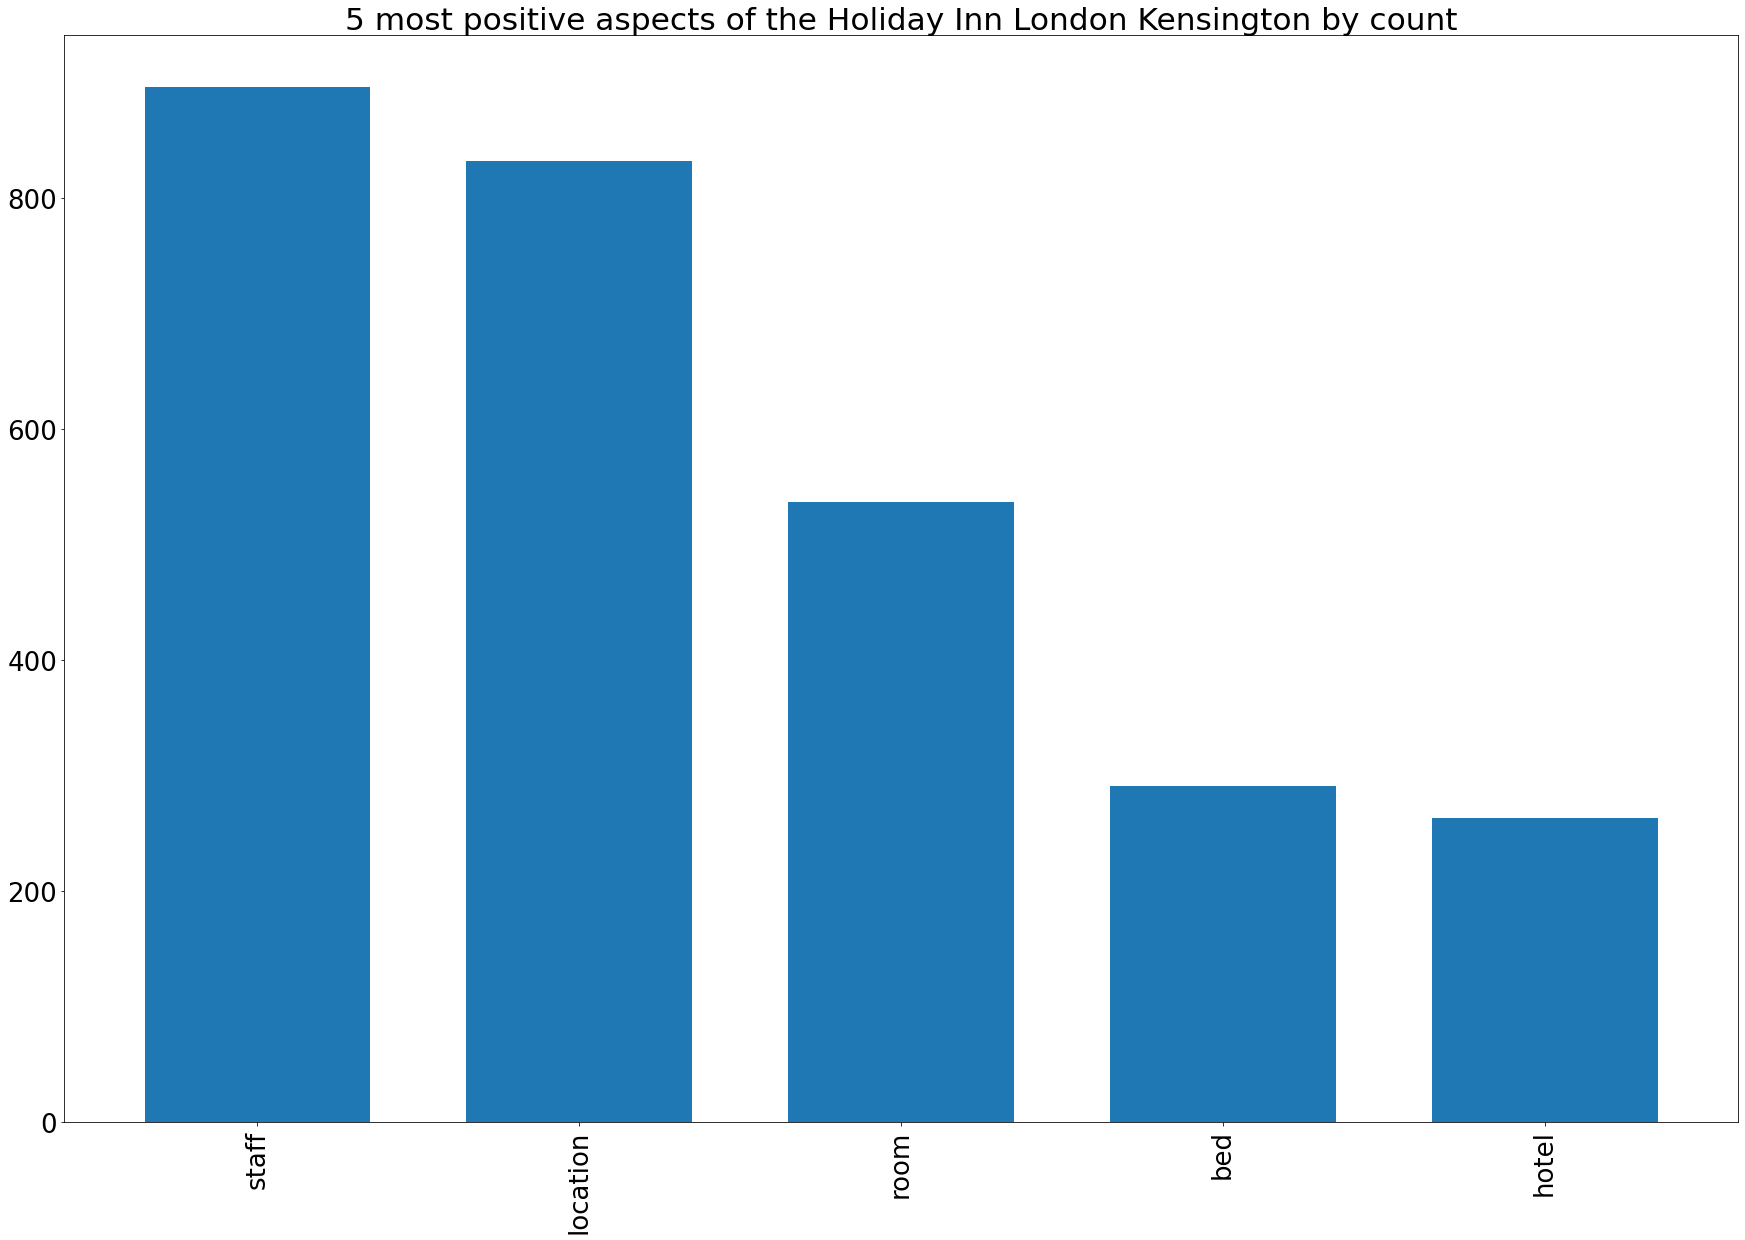

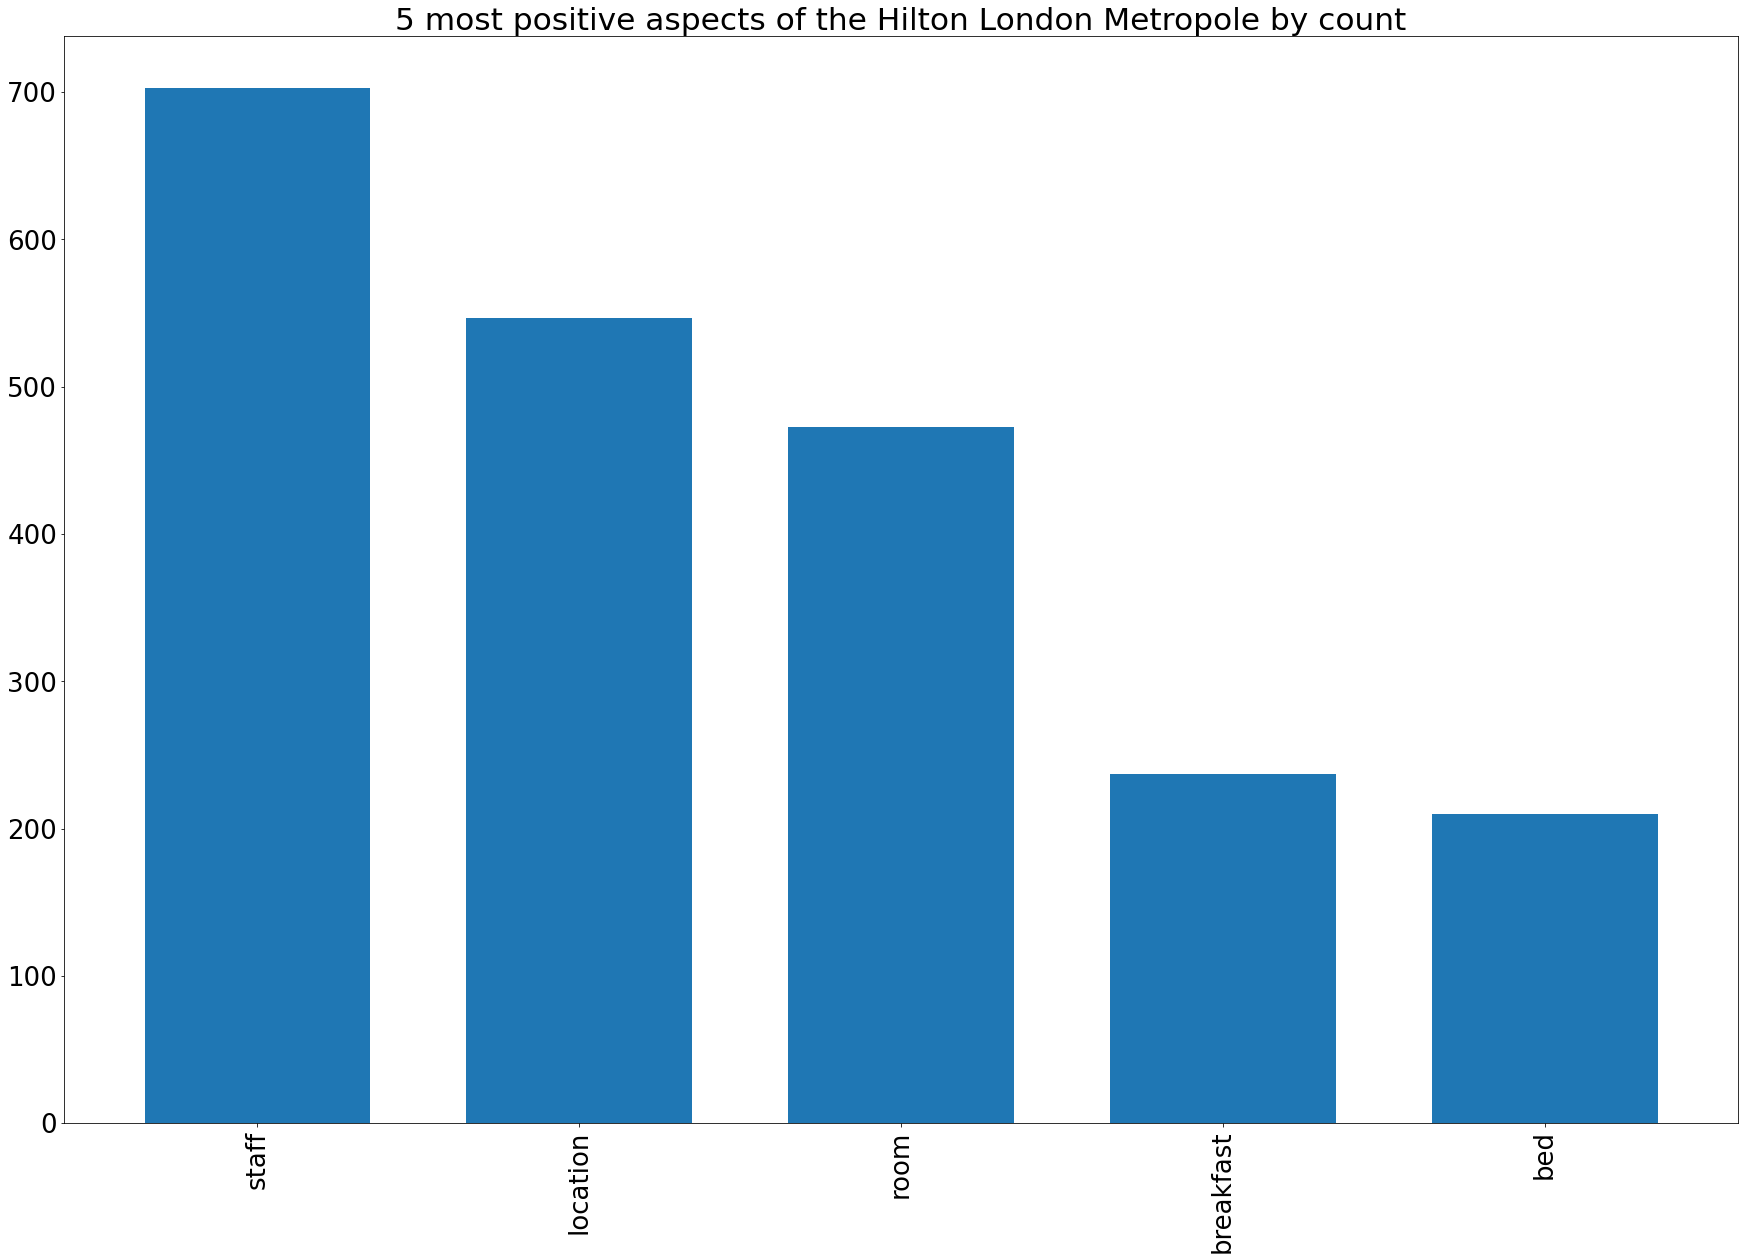

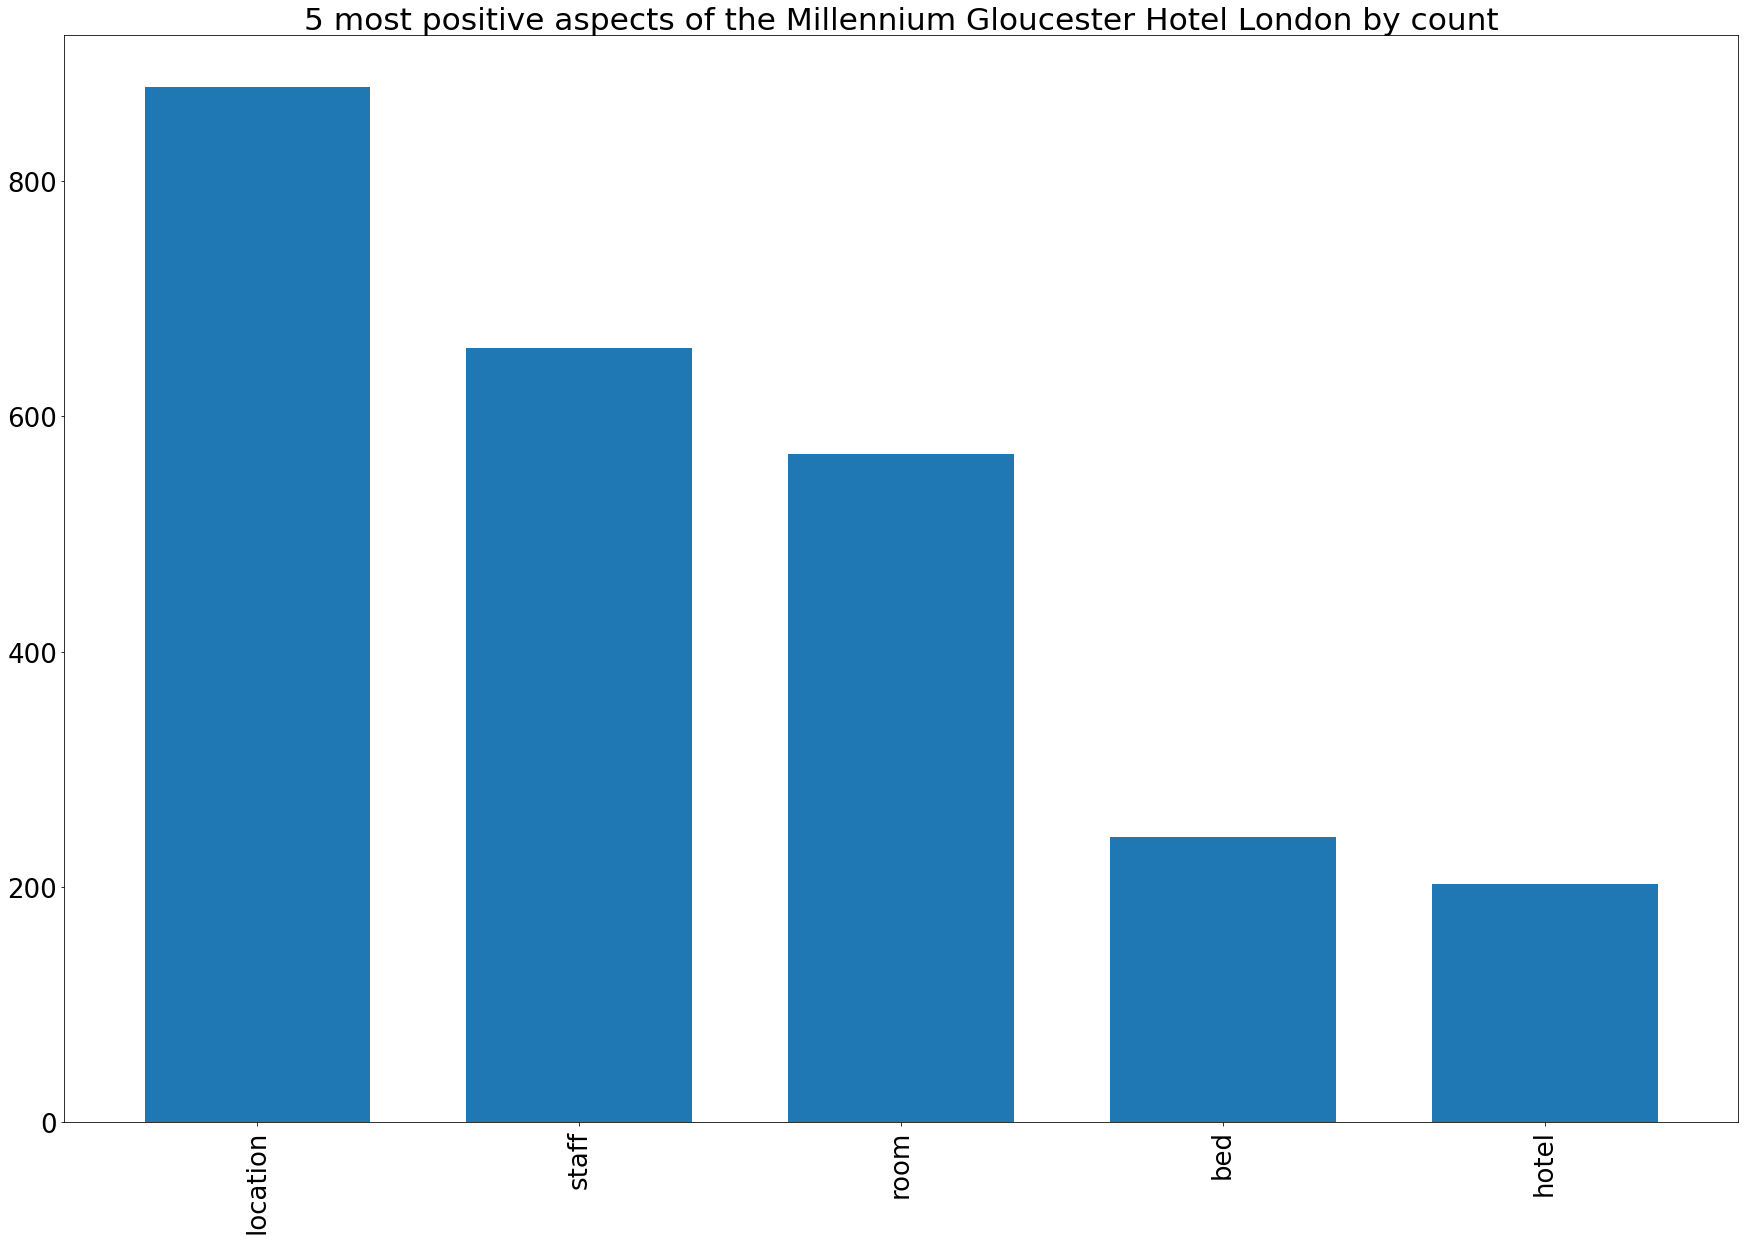

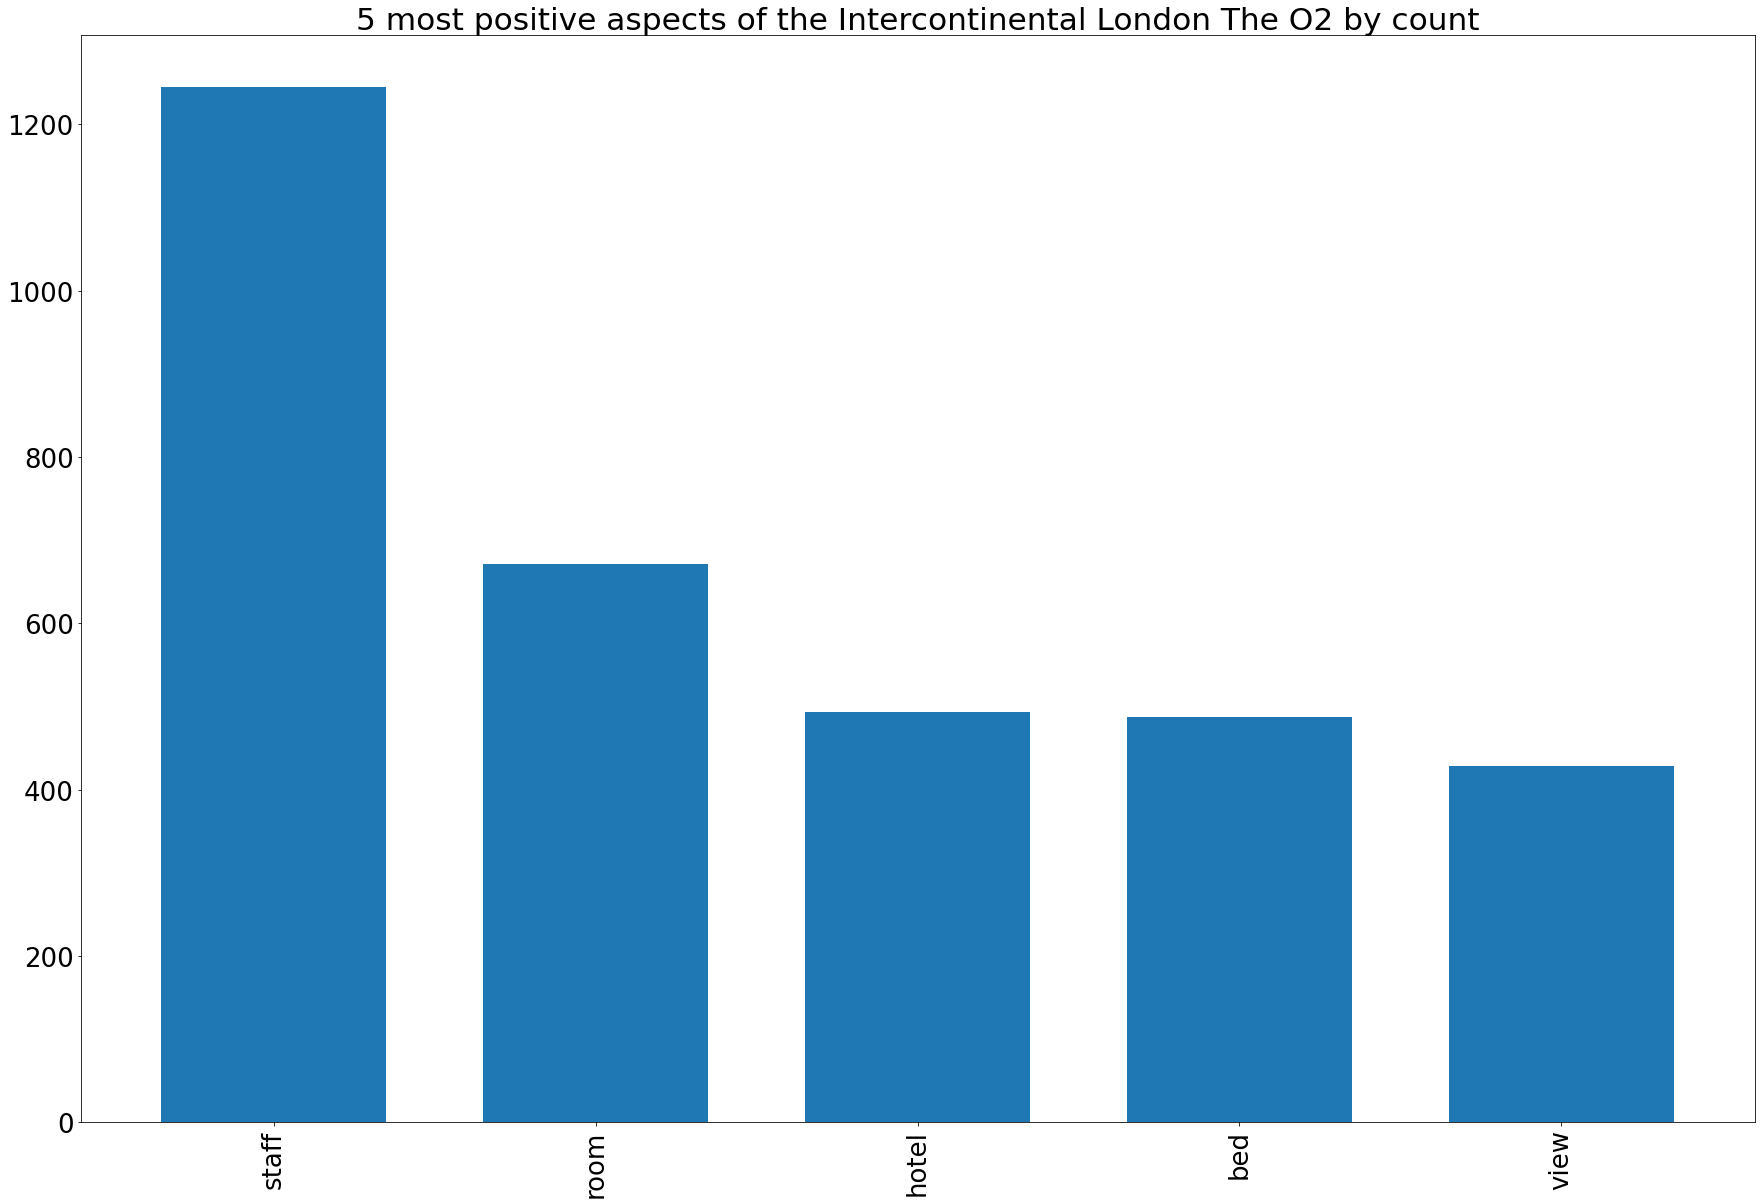

In [295]:
path = strPath[0:len(strPath)-5] + '/output/' 

# this gets us the five most commonly positive mentioned aspects per hotel
for name, aspectsTotal, cleanedAspectsPos, countAllAspectsPos, fiveMostCommonPos,  cleanedAspectsNeg, countAllAspectsNeg, fiveMostCommonNeg, sentRoom, sentProperty,  sentFood, sentLocation, sentStaff in data.values:
    figName = "fivePos" + name + ".pdf"

    df = pd.DataFrame([asp[1] for asp in fiveMostCommonPos], index=[asp[0] for asp in fiveMostCommonPos]) #, index = [' staff', ' food', ' location', ' room', ' property']
    plt.rcParams.update({'font.size': 26}) 
    df.plot(kind='bar', legend=False, width=.7, figsize=(30,20))
    plt.title("5 most positive aspects of the " + name + " by count")
    plt.savefig(path + figName)
    #plt.show()